## 강수량 예측 모델 프로젝트 
* 해당 프로젝트는 GPM Core 위성의 GMI/DPR 센서에서 북서태평양영역에서 관측된 자료를 통해 강수량을 예측하는 모델을 만드는 것을 목표로 함
* 각 데이터는 40*40형태의 subset으로 제공되어지고 있고 세부 내용은 공모전 홈페이지를 참고하기 바람
---
### 전처리
* 샘플데이터를 시각화하여 각 채널과 강수량간의 상관관계를 확인함
* 인공위성 특성상 위치에 따른 상관성이 매우 높을 것으로 예상되어 Test데이터와 공간적으로 매우 근접한 Train데이터 만을 추출하여 사용함
* 전체 7만 6천여개의 Train파일에서 Test데이터와 공간적인 위치가 비슷한 4만여개만 추출함
---
### 모델링
* 강수량예측을 효과적으로 수행하기 위해 추출된 Train파일 중 강수픽셀이 존재하는 데이터만을 학습데이터로 사용함
* 위성 데이터 픽셀의 특징을 추출하기 위해 각 파일을 회전/반전시켜 8배로 학습데이터를 부풀려 사용함
* Loss fuction은 BaseLine코드에서 제공되는 함수를 사용함
* convolution과 residual block만을 사용하여 ResNet모델을 구축하고 사용함
---
### 결과
* 최종순위 28위로 대회가 마무리됨

In [11]:
import glob                     # train, test path을 불러올 떄 사용
import pandas as pd             # submission data frame을 불러올 때 사용
import numpy as np              # train, test datadls .npy data load할 때 사용
import matplotlib.pyplot as plt # 시각화에 사용
import seaborn as sns           # 시각화에 사용
from tqdm import tqdm           # for문에서 진행 정도를 파악하기 위해 사용

import geopandas as gpd         # 전처리에서 사용할 데이터를 추출할 떄 사용
from shapely.geometry import Point, Polygon  # geopandas에서 사용할 구조체

# 1. Data load

* 실행하기 위해서는 train, test, submission data를 홈페이지에서 받아야함.
* https://dacon.io/competitions/official/235591/data/

In [16]:
train_path = './data/train'
train_files = sorted(glob.glob(train_path + '/*'))
train_files = np.array( train_files )

test_path = './data/test'
test_files = sorted(glob.glob(test_path + '/*'))

In [3]:
train = []
for file in tqdm(train_files):
        data = np.load(file).astype('float32')
        train.append(data)
train = np.array(train)

100%|███████████████████████████████████████████████████████████████████████████| 76345/76345 [08:19<00:00, 152.71it/s]


In [4]:
test = []
for file in tqdm(test_files):
    data = np.load(file).astype('float32')
    test.append(data)
test = np.array(test)

100%|█████████████████████████████████████████████████████████████████████████████| 2416/2416 [00:18<00:00, 129.19it/s]


In [5]:
print( 'train shape', train.shape )
print( 'test shape', test.shape )

train shape (76345, 40, 40, 15)
test shape (2416, 40, 40, 14)


In [6]:
beginning_data_amount = len(train)

# 2. EDA (데이터 탐색적 분석)


In [7]:
train[0][0][0]

array([174.67711  ,  97.509834 , 203.54123  , 143.56703  , 241.50075  ,
       222.1719   , 170.15608  , 276.0605   , 259.39996  ,   0.       ,
       159.49438  ,   5.6410155, 159.64146  ,   5.574192 ,   0.       ],
      dtype=float32)

#### data : 픽셀 40 * 40 / 채널 15 
#### 채널
>* GMI에서 관측된 9개의 밝기온도값 - giant magnetic impedance , 마이크로파
>* 지표종류 1개 (앞자리 0: Ocean, 앞자리 1: Land, 앞자리 2: Coastal, 앞자리 3: Inland Water)
>* GMI센서 경도 1개, GMI 센서 위도 1개
>* DPR센서 경도 1개, DPR센서 위도 1개
>* DPR에서 강수량 1개 (mm/h, 결측치는 -9999.xxx 형태의 float 값으로 표기)

##### 강수량  시각화를 위한 데이터 추출

In [8]:
image_sample_rain = train[((train[:,:,:,-1].reshape(-1,40*40,1)>0).sum(axis=1)>=100).flatten()][:5,:,:,:]
image_sample_no_rain = train[((train[:,:,:,-1].reshape(-1,40*40,1)>0).sum(axis=1)==0).flatten()][:5,:,:,:]

print(image_sample_rain.shape)
print(image_sample_no_rain.shape)

(5, 40, 40, 15)
(5, 40, 40, 15)


- image_sample_rain : 파일의 40X40 픽셀중에서 비가 온 픽셀이 100개이상인 5개의 관측자료를 시각화를 위해 추출
- image_sample_no_rain : 파일의 40X40 픽셀중에서 모든 픽셀이 강수량이 없는 5개의 관측자료 추출

#### - 각 밝기온도(ch1~ch9)와 강수량의 상관관계를 시각화를 통해 확인

In [9]:
# 더 두드러진 시각화를 위해 Red, Blue로 색채대비를 활용
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

def show_image(image_sample):
    for row in range(5):
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(30, 30))
        
        
        for i in range(9):
            
            plt.subplot(1,10,i+1)
            plt.imshow(image_sample[row,:,:,i], cmap=color_map)
            plt.title('ch%d'%(i+1))
            plt.axis('off')

            
        plt.subplot(1,10,10)
        plt.imshow(image_sample[row,:,:,-1], cmap = color_map)
        plt.title('precipitation')
        plt.axis('off')
        plt.show()

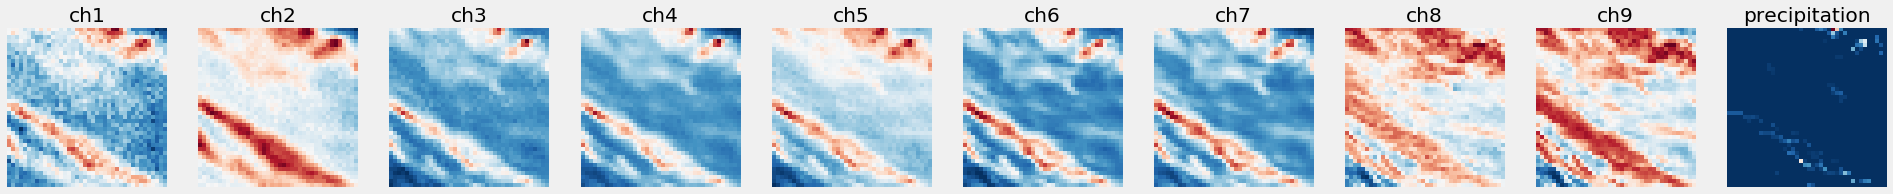

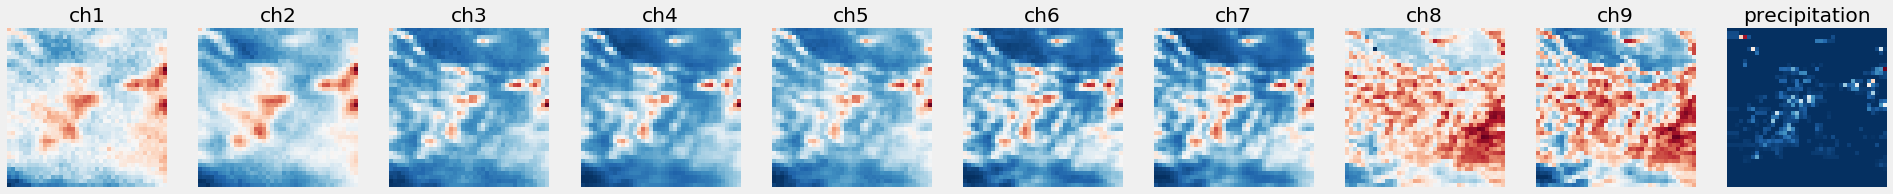

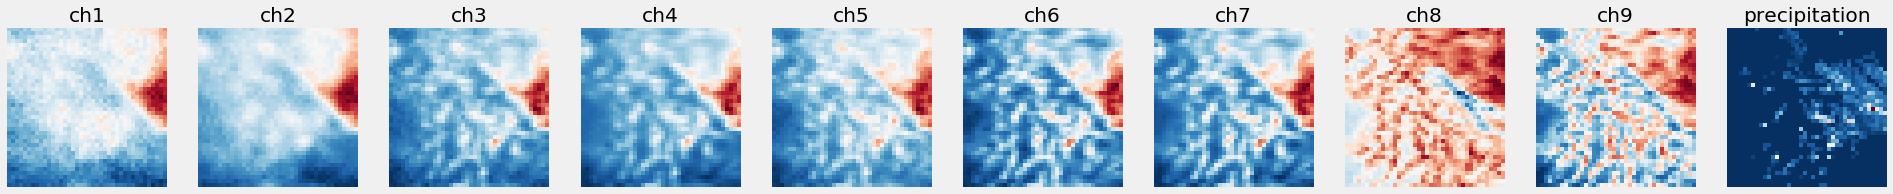

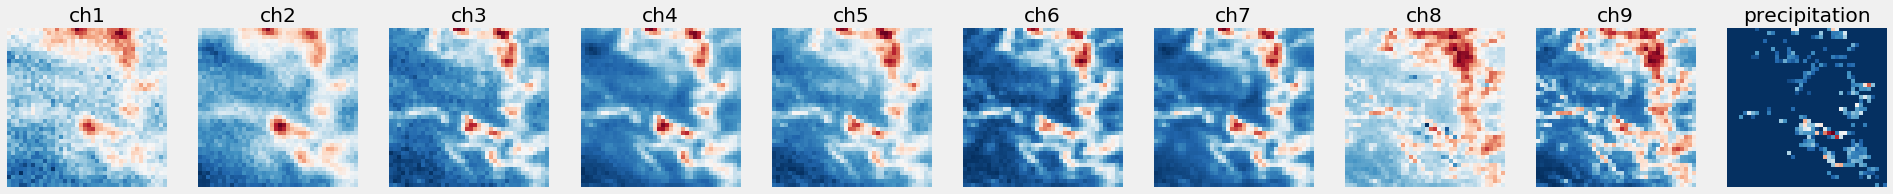

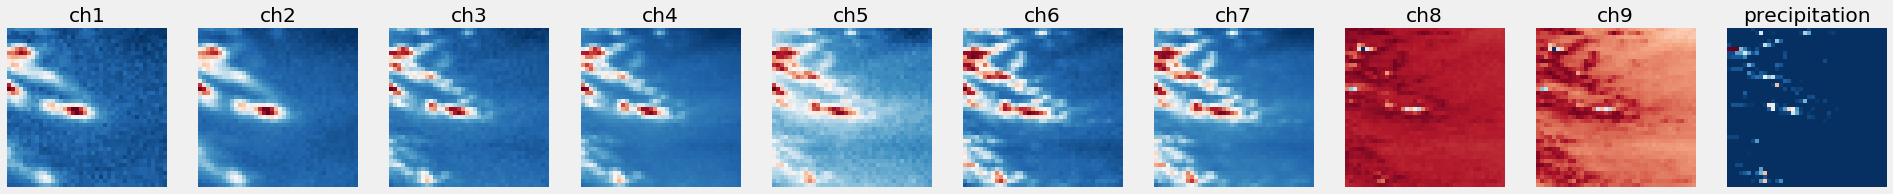

In [11]:
show_image(image_sample_rain)

##### 비가 많이 온 지역의 ch와 강수량 시각화
>* 강수량과 빛의밝기의 상관관계가 존재한다는 것을 알 수 있다.
>* ch 12,3,4,5,6,7이 비슷한 형태를, 8,9가 비슷한 데이터를 보이는 것을 확인 할 수 있다.
>* 강수량의 데이터는 주파수가 가장 높은 ch 9가 가장 잘 표현하는 것으로 보인다. (89.0 GHz 수평H 채널)

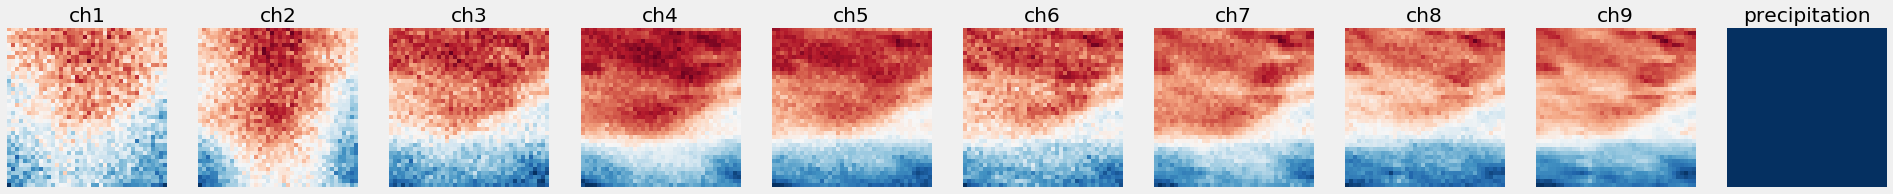

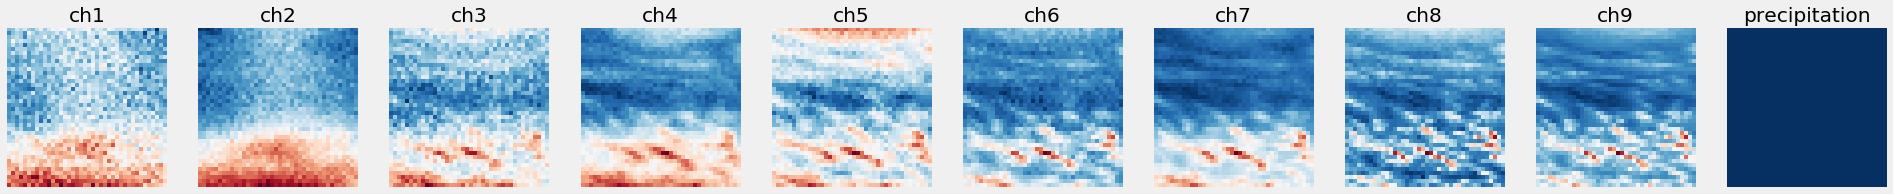

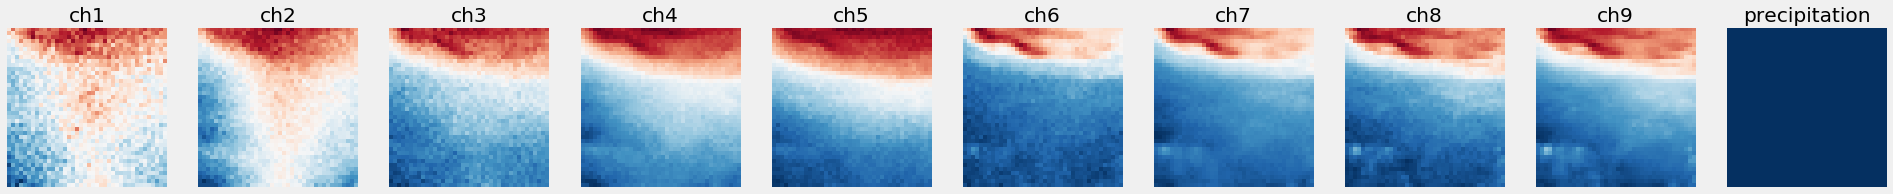

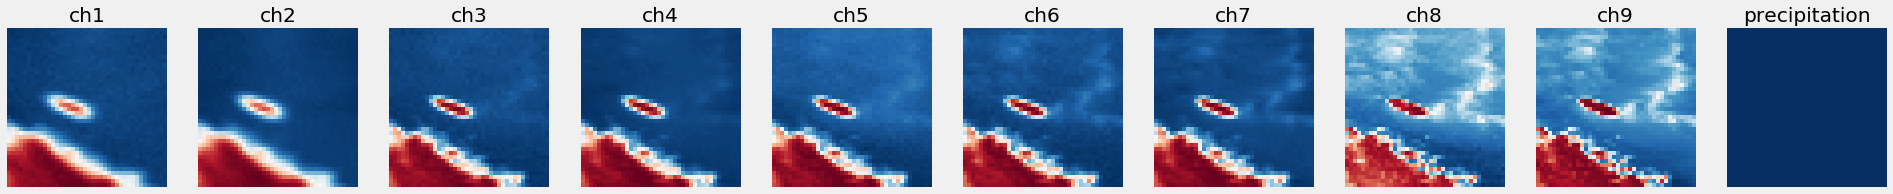

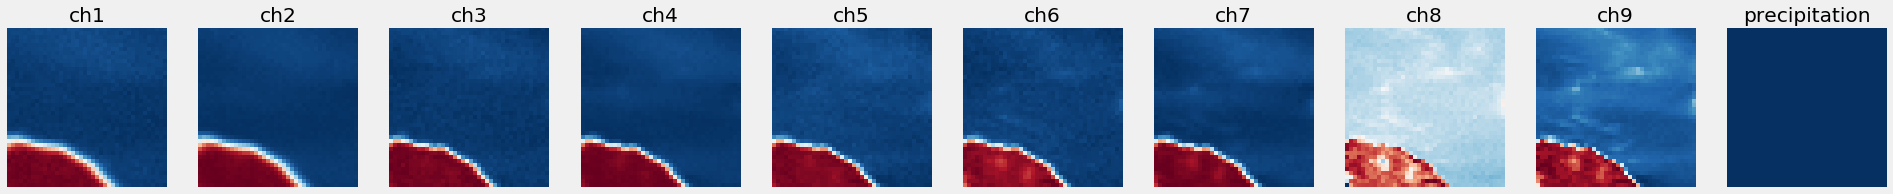

In [12]:
show_image(image_sample_no_rain)

##### 비가 전혀 오지 않은 지역에 대한 ch와 강수량 시각화
>* 각 ch별로 특성이 다르지만, 비교적 상관관계가 있음을 볼 수 있다.
>* 비가 많이 온 지역은 밝기온도의 데이터가 고르지 않으며 , 비가 오지않은 지역은 데이터가 비교적 고르게 분포된 편이다.
>* 주파수가 낮을 수록 공기중의 수중기의 영향을 많이 받아 산란되어 위성사진이 뚜렷하지 못한 것을 확인 할 수 있다.

# 3. 전처리

## 3.1 GMI 경위도를 통해 test data 범위를 벗어난 train data 삭제
* 모든 train data, test data의 좌상단 데이터인 [0, 0] 데이터만을 가지고 비교
* train의 데이터중에서 test의 관측위치가 겹치는 곳들만 추출

In [13]:
# ========================= Load train GMI position =========================
train_GMI_lon = train[:,:1,:1,10].reshape( beginning_data_amount ).tolist()
train_GMI_lat = train[:,:1,:1,11].reshape( beginning_data_amount ).tolist()

# ========================= Load train GMI position =========================
test_GMI_lon = test[:,:1,:1,10].reshape( len(test) ).tolist()
test_GMI_lat = test[:,:1,:1,11].reshape( len(test) ).tolist()

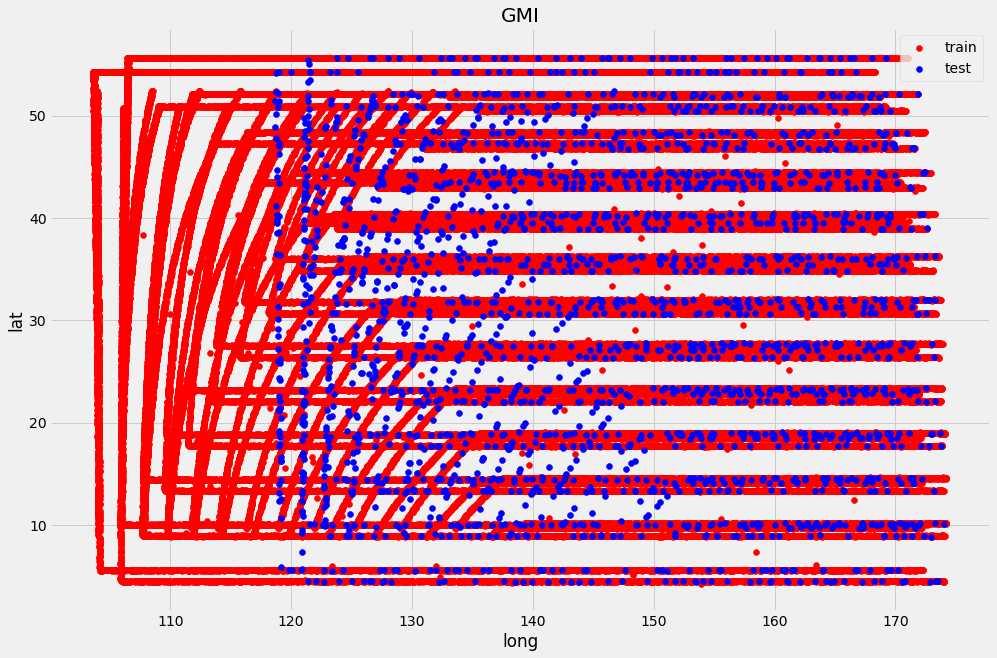

test GMI long 최소값 :  118.66690063476562


In [14]:
plt.figure(figsize = (15,10))
plt.scatter( train_GMI_lon, train_GMI_lat, color = "red", label = 'train')
plt.scatter( test_GMI_lon, test_GMI_lat, color = "blue",label = 'test' )
plt.title('GMI') ; plt.ylabel('lat'); plt.xlabel('long')
plt.legend()
plt.show()

min_GMI_lon = min(test_GMI_lon)
print('test GMI long 최소값 : ', min_GMI_lon)

* test의 GMI longitude최소값은 경도의 118.66임으로 조금 여유롭게 117미만의 데이터는 모두 삭제

In [17]:
train_files = train_files[ np.array( train_GMI_lon ) >= 117 ]
train = train[ np.array( train_GMI_lon ) >= 117 ]
second_data_amount = len( train )
print( 'train 필터 후 갯수 변화', beginning_data_amount, '->', second_data_amount )

train 필터 후 갯수 변화 76345 -> 61689


* 결측치가 하나라도 포함된 데이터 파일은 삭제

In [18]:
train_files = train_files[ ((train[:,:,:,-1].reshape(-1,40*40,1)<0).sum(axis=1)==0).flatten()  ]
train = train[ ((train[:,:,:,-1].reshape(-1,40*40,1)<0).sum(axis=1)==0).flatten()  ]
third_data_amount = len( train )
print( 'train 결측치 제거 후 갯수 변화', second_data_amount, '->', third_data_amount )

train 결측치 제거 후 갯수 변화 61689 -> 61351


## 3.2 Geopandas를 이용한 데이터 분리

* train data를 geopandas Polygon으로 변경

In [43]:
orbit_dict = dict()

file_path_row = 0
while( True ):
    if len(train_files) <= file_path_row:
        print("all loading")
        break
    
    print('*' * 30)
    orbit = train_files[file_path_row].split('_')[1]
    
    start_file_path_row = file_path_row
    while(1):
        try:
            if train_files[file_path_row].split('_')[1] == orbit:
                file_path_row+=1
                continue
            else:
                break
        except:
            break
    
    orbit_dict[orbit] = []
    
    for data_file_path_row in range( start_file_path_row, file_path_row ):
        one_file = train_files[data_file_path_row]
        print( one_file )
        np_data = np.load(one_file)
        point1 = Point( np_data[0][0][10], np_data[0][0][11] )
        point2 = Point( np_data[0][39][10], np_data[0][39][11] )
        point3 = Point( np_data[39][39][10], np_data[39][39][11] )
        point4 = Point( np_data[39][0][10], np_data[39][0][11] )
        orbit_dict[orbit].append( Polygon( [point1, point2, point3, point4] ) )

******************************
./data/train\subset_010462_01.npy
./data/train\subset_010462_02.npy
./data/train\subset_010462_03.npy
./data/train\subset_010462_04.npy
./data/train\subset_010462_05.npy
./data/train\subset_010462_06.npy
./data/train\subset_010462_07.npy
******************************
./data/train\subset_010463_01.npy
./data/train\subset_010463_02.npy
./data/train\subset_010463_03.npy
./data/train\subset_010463_04.npy
./data/train\subset_010463_05.npy
./data/train\subset_010463_06.npy
./data/train\subset_010463_07.npy
./data/train\subset_010463_08.npy
./data/train\subset_010463_09.npy
./data/train\subset_010463_10.npy
./data/train\subset_010463_11.npy
./data/train\subset_010463_12.npy
******************************
./data/train\subset_010464_04.npy
./data/train\subset_010464_05.npy
./data/train\subset_010464_06.npy
./data/train\subset_010464_07.npy
./data/train\subset_010464_08.npy
./data/train\subset_010464_09.npy
./data/train\subset_010464_10.npy
./data/train\subset_010

./data/train\subset_010516_06.npy
./data/train\subset_010516_07.npy
./data/train\subset_010516_08.npy
./data/train\subset_010516_09.npy
./data/train\subset_010516_10.npy
./data/train\subset_010516_11.npy
./data/train\subset_010516_12.npy
******************************
./data/train\subset_010523_01.npy
******************************
./data/train\subset_010524_01.npy
./data/train\subset_010524_02.npy
./data/train\subset_010524_03.npy
./data/train\subset_010524_04.npy
./data/train\subset_010524_05.npy
./data/train\subset_010524_06.npy
./data/train\subset_010524_07.npy
./data/train\subset_010524_08.npy
./data/train\subset_010524_09.npy
./data/train\subset_010524_10.npy
******************************
./data/train\subset_010525_01.npy
./data/train\subset_010525_02.npy
./data/train\subset_010525_03.npy
./data/train\subset_010525_04.npy
./data/train\subset_010525_05.npy
./data/train\subset_010525_06.npy
./data/train\subset_010525_07.npy
./data/train\subset_010525_08.npy
./data/train\subset_010

./data/train\subset_010577_05.npy
./data/train\subset_010577_06.npy
./data/train\subset_010577_07.npy
./data/train\subset_010577_08.npy
./data/train\subset_010577_09.npy
./data/train\subset_010577_10.npy
./data/train\subset_010577_11.npy
./data/train\subset_010577_12.npy
******************************
./data/train\subset_010578_05.npy
./data/train\subset_010578_06.npy
./data/train\subset_010578_07.npy
./data/train\subset_010578_08.npy
./data/train\subset_010578_09.npy
******************************
./data/train\subset_010585_01.npy
./data/train\subset_010585_02.npy
./data/train\subset_010585_03.npy
./data/train\subset_010585_04.npy
./data/train\subset_010585_05.npy
./data/train\subset_010585_06.npy
./data/train\subset_010585_07.npy
******************************
./data/train\subset_010586_01.npy
./data/train\subset_010586_02.npy
./data/train\subset_010586_03.npy
./data/train\subset_010586_04.npy
./data/train\subset_010586_05.npy
./data/train\subset_010586_06.npy
./data/train\subset_010

./data/train\subset_010638_04.npy
./data/train\subset_010638_05.npy
./data/train\subset_010638_06.npy
./data/train\subset_010638_07.npy
./data/train\subset_010638_08.npy
./data/train\subset_010638_09.npy
./data/train\subset_010638_10.npy
./data/train\subset_010638_11.npy
./data/train\subset_010638_12.npy
******************************
./data/train\subset_010639_04.npy
./data/train\subset_010639_05.npy
./data/train\subset_010639_06.npy
./data/train\subset_010639_07.npy
./data/train\subset_010639_08.npy
./data/train\subset_010639_09.npy
./data/train\subset_010639_10.npy
./data/train\subset_010639_11.npy
./data/train\subset_010639_12.npy
******************************
./data/train\subset_010646_01.npy
******************************
./data/train\subset_010647_01.npy
./data/train\subset_010647_02.npy
./data/train\subset_010647_03.npy
./data/train\subset_010647_04.npy
./data/train\subset_010647_05.npy
./data/train\subset_010647_06.npy
./data/train\subset_010647_07.npy
./data/train\subset_010

./data/train\subset_010699_11.npy
******************************
./data/train\subset_010700_01.npy
./data/train\subset_010700_02.npy
./data/train\subset_010700_03.npy
./data/train\subset_010700_04.npy
./data/train\subset_010700_05.npy
./data/train\subset_010700_06.npy
./data/train\subset_010700_07.npy
./data/train\subset_010700_08.npy
./data/train\subset_010700_09.npy
./data/train\subset_010700_10.npy
./data/train\subset_010700_11.npy
./data/train\subset_010700_12.npy
******************************
./data/train\subset_010701_05.npy
./data/train\subset_010701_06.npy
./data/train\subset_010701_07.npy
./data/train\subset_010701_08.npy
./data/train\subset_010701_09.npy
******************************
./data/train\subset_010708_01.npy
./data/train\subset_010708_02.npy
./data/train\subset_010708_03.npy
./data/train\subset_010708_04.npy
./data/train\subset_010708_05.npy
./data/train\subset_010708_06.npy
******************************
./data/train\subset_010709_01.npy
./data/train\subset_010709

./data/train\subset_010761_08.npy
./data/train\subset_010761_09.npy
./data/train\subset_010761_10.npy
./data/train\subset_010761_11.npy
./data/train\subset_010761_12.npy
******************************
./data/train\subset_010762_04.npy
./data/train\subset_010762_05.npy
./data/train\subset_010762_06.npy
./data/train\subset_010762_07.npy
./data/train\subset_010762_08.npy
./data/train\subset_010762_09.npy
./data/train\subset_010762_10.npy
./data/train\subset_010762_11.npy
./data/train\subset_010762_12.npy
******************************
./data/train\subset_010769_01.npy
******************************
./data/train\subset_010770_01.npy
./data/train\subset_010770_02.npy
./data/train\subset_010770_03.npy
./data/train\subset_010770_04.npy
./data/train\subset_010770_05.npy
./data/train\subset_010770_06.npy
./data/train\subset_010770_07.npy
./data/train\subset_010770_08.npy
./data/train\subset_010770_09.npy
./data/train\subset_010770_10.npy
******************************
./data/train\subset_010771

./data/train\subset_010823_06.npy
./data/train\subset_010823_07.npy
./data/train\subset_010823_08.npy
./data/train\subset_010823_09.npy
./data/train\subset_010823_10.npy
./data/train\subset_010823_11.npy
./data/train\subset_010823_12.npy
******************************
./data/train\subset_010824_05.npy
./data/train\subset_010824_06.npy
./data/train\subset_010824_07.npy
./data/train\subset_010824_08.npy
./data/train\subset_010824_09.npy
******************************
./data/train\subset_010831_01.npy
./data/train\subset_010831_02.npy
./data/train\subset_010831_03.npy
./data/train\subset_010831_04.npy
./data/train\subset_010831_05.npy
./data/train\subset_010831_06.npy
******************************
./data/train\subset_010832_01.npy
./data/train\subset_010832_02.npy
./data/train\subset_010832_03.npy
./data/train\subset_010832_04.npy
./data/train\subset_010832_05.npy
./data/train\subset_010832_06.npy
./data/train\subset_010832_07.npy
./data/train\subset_010832_08.npy
./data/train\subset_010

./data/train\subset_010885_11.npy
./data/train\subset_010885_12.npy
******************************
./data/train\subset_010892_01.npy
******************************
./data/train\subset_010893_01.npy
./data/train\subset_010893_02.npy
./data/train\subset_010893_03.npy
./data/train\subset_010893_04.npy
./data/train\subset_010893_05.npy
./data/train\subset_010893_06.npy
./data/train\subset_010893_07.npy
./data/train\subset_010893_08.npy
./data/train\subset_010893_09.npy
./data/train\subset_010893_10.npy
******************************
./data/train\subset_010894_01.npy
./data/train\subset_010894_02.npy
./data/train\subset_010894_03.npy
./data/train\subset_010894_04.npy
./data/train\subset_010894_05.npy
./data/train\subset_010894_06.npy
./data/train\subset_010894_07.npy
./data/train\subset_010894_08.npy
./data/train\subset_010894_09.npy
./data/train\subset_010894_10.npy
./data/train\subset_010894_11.npy
./data/train\subset_010894_12.npy
******************************
./data/train\subset_010895

./data/train\subset_010947_08.npy
./data/train\subset_010947_09.npy
./data/train\subset_010947_10.npy
******************************
./data/train\subset_010954_01.npy
./data/train\subset_010954_02.npy
./data/train\subset_010954_03.npy
./data/train\subset_010954_04.npy
./data/train\subset_010954_05.npy
./data/train\subset_010954_06.npy
******************************
./data/train\subset_010955_01.npy
./data/train\subset_010955_02.npy
./data/train\subset_010955_03.npy
./data/train\subset_010955_04.npy
./data/train\subset_010955_05.npy
./data/train\subset_010955_06.npy
./data/train\subset_010955_07.npy
./data/train\subset_010955_08.npy
./data/train\subset_010955_09.npy
./data/train\subset_010955_10.npy
./data/train\subset_010955_11.npy
./data/train\subset_010955_12.npy
******************************
./data/train\subset_010956_03.npy
./data/train\subset_010956_04.npy
./data/train\subset_010956_05.npy
./data/train\subset_010956_06.npy
./data/train\subset_010956_07.npy
./data/train\subset_010

******************************
./data/train\subset_011017_01.npy
./data/train\subset_011017_02.npy
./data/train\subset_011017_03.npy
./data/train\subset_011017_04.npy
./data/train\subset_011017_05.npy
./data/train\subset_011017_06.npy
./data/train\subset_011017_07.npy
./data/train\subset_011017_08.npy
./data/train\subset_011017_09.npy
./data/train\subset_011017_10.npy
./data/train\subset_011017_11.npy
./data/train\subset_011017_12.npy
******************************
./data/train\subset_011018_07.npy
./data/train\subset_011018_08.npy
./data/train\subset_011018_09.npy
./data/train\subset_011018_10.npy
./data/train\subset_011018_11.npy
******************************
./data/train\subset_011021_01.npy
./data/train\subset_011021_02.npy
******************************
./data/train\subset_011022_01.npy
./data/train\subset_011022_02.npy
./data/train\subset_011022_03.npy
./data/train\subset_011022_04.npy
./data/train\subset_011022_05.npy
./data/train\subset_011022_06.npy
./data/train\subset_011022

******************************
./data/train\subset_011078_01.npy
./data/train\subset_011078_02.npy
./data/train\subset_011078_03.npy
./data/train\subset_011078_04.npy
./data/train\subset_011078_05.npy
./data/train\subset_011078_06.npy
./data/train\subset_011078_07.npy
./data/train\subset_011078_08.npy
./data/train\subset_011078_09.npy
./data/train\subset_011078_10.npy
./data/train\subset_011078_11.npy
./data/train\subset_011078_12.npy
******************************
./data/train\subset_011079_04.npy
./data/train\subset_011079_05.npy
./data/train\subset_011079_06.npy
./data/train\subset_011079_07.npy
./data/train\subset_011079_08.npy
./data/train\subset_011079_09.npy
./data/train\subset_011079_10.npy
./data/train\subset_011079_11.npy
./data/train\subset_011079_12.npy
******************************
./data/train\subset_011080_05.npy
******************************
./data/train\subset_011083_01.npy
./data/train\subset_011083_02.npy
./data/train\subset_011083_03.npy
./data/train\subset_011083

./data/train\subset_011139_02.npy
./data/train\subset_011139_03.npy
./data/train\subset_011139_04.npy
./data/train\subset_011139_05.npy
./data/train\subset_011139_06.npy
./data/train\subset_011139_07.npy
./data/train\subset_011139_08.npy
./data/train\subset_011139_09.npy
./data/train\subset_011139_10.npy
******************************
./data/train\subset_011140_01.npy
./data/train\subset_011140_02.npy
./data/train\subset_011140_03.npy
./data/train\subset_011140_04.npy
./data/train\subset_011140_05.npy
./data/train\subset_011140_06.npy
./data/train\subset_011140_07.npy
./data/train\subset_011140_08.npy
./data/train\subset_011140_09.npy
./data/train\subset_011140_10.npy
./data/train\subset_011140_11.npy
./data/train\subset_011140_12.npy
******************************
./data/train\subset_011141_07.npy
./data/train\subset_011141_08.npy
./data/train\subset_011141_09.npy
./data/train\subset_011141_10.npy
******************************
./data/train\subset_011144_01.npy
./data/train\subset_011

./data/train\subset_011202_05.npy
./data/train\subset_011202_06.npy
./data/train\subset_011202_07.npy
./data/train\subset_011202_08.npy
./data/train\subset_011202_09.npy
./data/train\subset_011202_10.npy
./data/train\subset_011202_11.npy
./data/train\subset_011202_12.npy
******************************
./data/train\subset_011203_05.npy
******************************
./data/train\subset_011206_01.npy
./data/train\subset_011206_02.npy
./data/train\subset_011206_03.npy
./data/train\subset_011206_04.npy
./data/train\subset_011206_05.npy
./data/train\subset_011206_06.npy
./data/train\subset_011206_07.npy
******************************
./data/train\subset_011207_01.npy
./data/train\subset_011207_02.npy
./data/train\subset_011207_03.npy
./data/train\subset_011207_04.npy
./data/train\subset_011207_05.npy
./data/train\subset_011207_06.npy
./data/train\subset_011207_07.npy
./data/train\subset_011207_08.npy
./data/train\subset_011207_09.npy
./data/train\subset_011207_10.npy
./data/train\subset_011

./data/train\subset_011267_03.npy
******************************
./data/train\subset_011268_01.npy
./data/train\subset_011268_02.npy
./data/train\subset_011268_03.npy
./data/train\subset_011268_04.npy
./data/train\subset_011268_05.npy
./data/train\subset_011268_06.npy
./data/train\subset_011268_07.npy
./data/train\subset_011268_08.npy
./data/train\subset_011268_09.npy
./data/train\subset_011268_10.npy
./data/train\subset_011268_11.npy
./data/train\subset_011268_12.npy
******************************
./data/train\subset_011269_02.npy
./data/train\subset_011269_03.npy
./data/train\subset_011269_04.npy
./data/train\subset_011269_05.npy
./data/train\subset_011269_06.npy
./data/train\subset_011269_07.npy
./data/train\subset_011269_08.npy
./data/train\subset_011269_09.npy
./data/train\subset_011269_10.npy
./data/train\subset_011269_11.npy
./data/train\subset_011269_12.npy
******************************
./data/train\subset_011270_06.npy
./data/train\subset_011270_07.npy
./data/train\subset_011

******************************
./data/train\subset_011330_01.npy
./data/train\subset_011330_02.npy
./data/train\subset_011330_03.npy
./data/train\subset_011330_04.npy
./data/train\subset_011330_05.npy
./data/train\subset_011330_06.npy
./data/train\subset_011330_07.npy
./data/train\subset_011330_08.npy
./data/train\subset_011330_09.npy
./data/train\subset_011330_10.npy
./data/train\subset_011330_11.npy
./data/train\subset_011330_12.npy
******************************
./data/train\subset_011331_05.npy
./data/train\subset_011331_06.npy
./data/train\subset_011331_07.npy
./data/train\subset_011331_08.npy
./data/train\subset_011331_09.npy
./data/train\subset_011331_10.npy
./data/train\subset_011331_11.npy
******************************
./data/train\subset_011338_01.npy
./data/train\subset_011338_02.npy
./data/train\subset_011338_03.npy
******************************
./data/train\subset_011339_01.npy
./data/train\subset_011339_02.npy
./data/train\subset_011339_03.npy
./data/train\subset_011339

./data/train\subset_011392_08.npy
./data/train\subset_011392_09.npy
./data/train\subset_011392_10.npy
./data/train\subset_011392_11.npy
./data/train\subset_011392_12.npy
******************************
./data/train\subset_011393_06.npy
./data/train\subset_011393_07.npy
./data/train\subset_011393_08.npy
******************************
./data/train\subset_011400_01.npy
./data/train\subset_011400_02.npy
./data/train\subset_011400_03.npy
./data/train\subset_011400_04.npy
./data/train\subset_011400_05.npy
./data/train\subset_011400_06.npy
./data/train\subset_011400_07.npy
******************************
./data/train\subset_011401_01.npy
./data/train\subset_011401_02.npy
./data/train\subset_011401_03.npy
./data/train\subset_011401_04.npy
./data/train\subset_011401_05.npy
./data/train\subset_011401_06.npy
./data/train\subset_011401_07.npy
./data/train\subset_011401_08.npy
./data/train\subset_011401_09.npy
./data/train\subset_011401_10.npy
./data/train\subset_011401_11.npy
./data/train\subset_011

./data/train\subset_011454_09.npy
./data/train\subset_011454_10.npy
./data/train\subset_011454_11.npy
******************************
./data/train\subset_011461_01.npy
./data/train\subset_011461_02.npy
./data/train\subset_011461_03.npy
******************************
./data/train\subset_011462_01.npy
./data/train\subset_011462_02.npy
./data/train\subset_011462_03.npy
./data/train\subset_011462_04.npy
./data/train\subset_011462_05.npy
./data/train\subset_011462_06.npy
./data/train\subset_011462_07.npy
./data/train\subset_011462_08.npy
./data/train\subset_011462_09.npy
./data/train\subset_011462_10.npy
******************************
./data/train\subset_011463_01.npy
./data/train\subset_011463_02.npy
./data/train\subset_011463_03.npy
./data/train\subset_011463_04.npy
./data/train\subset_011463_05.npy
./data/train\subset_011463_06.npy
./data/train\subset_011463_07.npy
./data/train\subset_011463_08.npy
./data/train\subset_011463_09.npy
./data/train\subset_011463_10.npy
./data/train\subset_011

./data/train\subset_011516_09.npy
******************************
./data/train\subset_011523_01.npy
./data/train\subset_011523_02.npy
./data/train\subset_011523_03.npy
./data/train\subset_011523_04.npy
./data/train\subset_011523_05.npy
./data/train\subset_011523_06.npy
./data/train\subset_011523_07.npy
******************************
./data/train\subset_011524_01.npy
./data/train\subset_011524_02.npy
./data/train\subset_011524_03.npy
./data/train\subset_011524_04.npy
./data/train\subset_011524_05.npy
./data/train\subset_011524_06.npy
./data/train\subset_011524_07.npy
./data/train\subset_011524_08.npy
./data/train\subset_011524_09.npy
./data/train\subset_011524_10.npy
./data/train\subset_011524_11.npy
./data/train\subset_011524_12.npy
******************************
./data/train\subset_011525_04.npy
./data/train\subset_011525_05.npy
./data/train\subset_011525_06.npy
./data/train\subset_011525_07.npy
./data/train\subset_011525_08.npy
./data/train\subset_011525_09.npy
./data/train\subset_011

./data/train\subset_011585_02.npy
./data/train\subset_011585_03.npy
./data/train\subset_011585_04.npy
./data/train\subset_011585_05.npy
./data/train\subset_011585_06.npy
./data/train\subset_011585_07.npy
./data/train\subset_011585_08.npy
./data/train\subset_011585_09.npy
./data/train\subset_011585_10.npy
******************************
./data/train\subset_011586_01.npy
./data/train\subset_011586_02.npy
./data/train\subset_011586_03.npy
./data/train\subset_011586_04.npy
./data/train\subset_011586_05.npy
./data/train\subset_011586_06.npy
./data/train\subset_011586_07.npy
./data/train\subset_011586_08.npy
./data/train\subset_011586_09.npy
./data/train\subset_011586_10.npy
./data/train\subset_011586_11.npy
./data/train\subset_011586_12.npy
******************************
./data/train\subset_011587_06.npy
./data/train\subset_011587_07.npy
./data/train\subset_011587_08.npy
******************************
./data/train\subset_011590_01.npy
./data/train\subset_011590_02.npy
./data/train\subset_011

******************************
./data/train\subset_011639_06.npy
./data/train\subset_011639_07.npy
./data/train\subset_011639_08.npy
******************************
./data/train\subset_011646_01.npy
./data/train\subset_011646_02.npy
./data/train\subset_011646_03.npy
./data/train\subset_011646_04.npy
./data/train\subset_011646_05.npy
./data/train\subset_011646_06.npy
./data/train\subset_011646_07.npy
./data/train\subset_011646_08.npy
******************************
./data/train\subset_011647_01.npy
./data/train\subset_011647_02.npy
./data/train\subset_011647_03.npy
./data/train\subset_011647_04.npy
./data/train\subset_011647_05.npy
./data/train\subset_011647_06.npy
./data/train\subset_011647_07.npy
./data/train\subset_011647_08.npy
./data/train\subset_011647_09.npy
./data/train\subset_011647_10.npy
./data/train\subset_011647_11.npy
./data/train\subset_011647_12.npy
******************************
./data/train\subset_011648_05.npy
./data/train\subset_011648_06.npy
./data/train\subset_011648

./data/train\subset_011708_03.npy
./data/train\subset_011708_04.npy
./data/train\subset_011708_05.npy
./data/train\subset_011708_06.npy
./data/train\subset_011708_07.npy
./data/train\subset_011708_08.npy
./data/train\subset_011708_09.npy
./data/train\subset_011708_10.npy
./data/train\subset_011708_11.npy
******************************
./data/train\subset_011709_01.npy
./data/train\subset_011709_02.npy
./data/train\subset_011709_03.npy
./data/train\subset_011709_04.npy
./data/train\subset_011709_05.npy
./data/train\subset_011709_06.npy
./data/train\subset_011709_07.npy
./data/train\subset_011709_08.npy
./data/train\subset_011709_09.npy
./data/train\subset_011709_10.npy
./data/train\subset_011709_11.npy
./data/train\subset_011709_12.npy
******************************
./data/train\subset_011710_06.npy
./data/train\subset_011710_07.npy
./data/train\subset_011710_08.npy
******************************
./data/train\subset_011713_01.npy
./data/train\subset_011713_02.npy
./data/train\subset_011

./data/train\subset_011762_08.npy
******************************
./data/train\subset_011769_01.npy
./data/train\subset_011769_02.npy
./data/train\subset_011769_03.npy
./data/train\subset_011769_04.npy
./data/train\subset_011769_05.npy
./data/train\subset_011769_06.npy
./data/train\subset_011769_07.npy
./data/train\subset_011769_08.npy
******************************
./data/train\subset_011770_01.npy
./data/train\subset_011770_02.npy
./data/train\subset_011770_03.npy
./data/train\subset_011770_04.npy
./data/train\subset_011770_05.npy
./data/train\subset_011770_06.npy
./data/train\subset_011770_07.npy
./data/train\subset_011770_08.npy
./data/train\subset_011770_09.npy
./data/train\subset_011770_10.npy
./data/train\subset_011770_11.npy
./data/train\subset_011770_12.npy
******************************
./data/train\subset_011771_05.npy
./data/train\subset_011771_06.npy
./data/train\subset_011771_07.npy
./data/train\subset_011771_08.npy
./data/train\subset_011771_09.npy
./data/train\subset_011

./data/train\subset_011832_09.npy
./data/train\subset_011832_10.npy
./data/train\subset_011832_11.npy
./data/train\subset_011832_12.npy
******************************
./data/train\subset_011833_06.npy
./data/train\subset_011833_07.npy
******************************
./data/train\subset_011836_01.npy
./data/train\subset_011836_02.npy
./data/train\subset_011836_03.npy
./data/train\subset_011836_04.npy
******************************
./data/train\subset_011837_01.npy
./data/train\subset_011837_02.npy
./data/train\subset_011837_03.npy
./data/train\subset_011837_04.npy
./data/train\subset_011837_05.npy
./data/train\subset_011837_06.npy
./data/train\subset_011837_07.npy
./data/train\subset_011837_08.npy
./data/train\subset_011837_09.npy
./data/train\subset_011837_10.npy
./data/train\subset_011837_11.npy
./data/train\subset_011837_12.npy
******************************
./data/train\subset_011838_03.npy
./data/train\subset_011838_04.npy
./data/train\subset_011838_05.npy
./data/train\subset_011838

./data/train\subset_011894_08.npy
./data/train\subset_011894_09.npy
./data/train\subset_011894_10.npy
./data/train\subset_011894_11.npy
./data/train\subset_011894_12.npy
******************************
./data/train\subset_011897_01.npy
******************************
./data/train\subset_011898_01.npy
./data/train\subset_011898_02.npy
./data/train\subset_011898_03.npy
./data/train\subset_011898_04.npy
./data/train\subset_011898_05.npy
./data/train\subset_011898_06.npy
./data/train\subset_011898_07.npy
./data/train\subset_011898_08.npy
./data/train\subset_011898_09.npy
./data/train\subset_011898_10.npy
******************************
./data/train\subset_011899_01.npy
./data/train\subset_011899_02.npy
./data/train\subset_011899_03.npy
./data/train\subset_011899_04.npy
./data/train\subset_011899_05.npy
./data/train\subset_011899_06.npy
./data/train\subset_011899_07.npy
./data/train\subset_011899_08.npy
./data/train\subset_011899_09.npy
./data/train\subset_011899_10.npy
./data/train\subset_011

./data/train\subset_011955_02.npy
./data/train\subset_011955_03.npy
./data/train\subset_011955_04.npy
./data/train\subset_011955_05.npy
./data/train\subset_011955_06.npy
./data/train\subset_011955_07.npy
./data/train\subset_011955_08.npy
./data/train\subset_011955_09.npy
./data/train\subset_011955_10.npy
./data/train\subset_011955_11.npy
./data/train\subset_011955_12.npy
******************************
./data/train\subset_011956_06.npy
./data/train\subset_011956_07.npy
******************************
./data/train\subset_011959_01.npy
./data/train\subset_011959_02.npy
./data/train\subset_011959_03.npy
./data/train\subset_011959_04.npy
./data/train\subset_011959_05.npy
******************************
./data/train\subset_011960_01.npy
./data/train\subset_011960_02.npy
./data/train\subset_011960_03.npy
./data/train\subset_011960_04.npy
./data/train\subset_011960_05.npy
./data/train\subset_011960_06.npy
./data/train\subset_011960_07.npy
./data/train\subset_011960_08.npy
./data/train\subset_011

******************************
./data/train\subset_012017_07.npy
./data/train\subset_012017_08.npy
./data/train\subset_012017_09.npy
./data/train\subset_012017_10.npy
./data/train\subset_012017_11.npy
./data/train\subset_012017_12.npy
******************************
./data/train\subset_012020_01.npy
******************************
./data/train\subset_012021_01.npy
./data/train\subset_012021_02.npy
./data/train\subset_012021_03.npy
./data/train\subset_012021_04.npy
./data/train\subset_012021_05.npy
./data/train\subset_012021_06.npy
./data/train\subset_012021_07.npy
./data/train\subset_012021_08.npy
./data/train\subset_012021_09.npy
./data/train\subset_012021_10.npy
******************************
./data/train\subset_012022_01.npy
./data/train\subset_012022_02.npy
./data/train\subset_012022_03.npy
./data/train\subset_012022_04.npy
./data/train\subset_012022_05.npy
./data/train\subset_012022_06.npy
./data/train\subset_012022_07.npy
./data/train\subset_012022_08.npy
./data/train\subset_012022

./data/train\subset_012078_04.npy
./data/train\subset_012078_05.npy
./data/train\subset_012078_06.npy
./data/train\subset_012078_07.npy
./data/train\subset_012078_08.npy
./data/train\subset_012078_09.npy
./data/train\subset_012078_10.npy
./data/train\subset_012078_11.npy
./data/train\subset_012078_12.npy
******************************
./data/train\subset_012079_06.npy
******************************
./data/train\subset_012082_01.npy
./data/train\subset_012082_02.npy
./data/train\subset_012082_03.npy
./data/train\subset_012082_04.npy
./data/train\subset_012082_05.npy
******************************
./data/train\subset_012083_01.npy
./data/train\subset_012083_02.npy
./data/train\subset_012083_03.npy
./data/train\subset_012083_04.npy
./data/train\subset_012083_05.npy
./data/train\subset_012083_06.npy
./data/train\subset_012083_07.npy
./data/train\subset_012083_08.npy
./data/train\subset_012083_09.npy
./data/train\subset_012083_10.npy
./data/train\subset_012083_11.npy
./data/train\subset_012

./data/train\subset_012140_11.npy
./data/train\subset_012140_12.npy
******************************
./data/train\subset_012143_01.npy
./data/train\subset_012143_02.npy
******************************
./data/train\subset_012144_01.npy
./data/train\subset_012144_02.npy
./data/train\subset_012144_03.npy
./data/train\subset_012144_04.npy
./data/train\subset_012144_05.npy
./data/train\subset_012144_06.npy
./data/train\subset_012144_07.npy
./data/train\subset_012144_08.npy
./data/train\subset_012144_09.npy
./data/train\subset_012144_10.npy
./data/train\subset_012144_11.npy
******************************
./data/train\subset_012145_01.npy
./data/train\subset_012145_02.npy
./data/train\subset_012145_03.npy
./data/train\subset_012145_04.npy
./data/train\subset_012145_05.npy
./data/train\subset_012145_06.npy
./data/train\subset_012145_07.npy
./data/train\subset_012145_08.npy
./data/train\subset_012145_09.npy
./data/train\subset_012145_10.npy
./data/train\subset_012145_11.npy
./data/train\subset_012

./data/train\subset_012267_02.npy
./data/train\subset_012267_03.npy
./data/train\subset_012267_04.npy
./data/train\subset_012267_05.npy
./data/train\subset_012267_06.npy
./data/train\subset_012267_07.npy
./data/train\subset_012267_08.npy
./data/train\subset_012267_09.npy
./data/train\subset_012267_10.npy
./data/train\subset_012267_11.npy
./data/train\subset_012267_12.npy
******************************
./data/train\subset_012268_02.npy
./data/train\subset_012268_03.npy
./data/train\subset_012268_04.npy
./data/train\subset_012268_05.npy
./data/train\subset_012268_06.npy
./data/train\subset_012268_07.npy
./data/train\subset_012268_08.npy
./data/train\subset_012268_09.npy
./data/train\subset_012268_10.npy
./data/train\subset_012268_11.npy
./data/train\subset_012268_12.npy
******************************
./data/train\subset_012269_05.npy
./data/train\subset_012269_06.npy
./data/train\subset_012269_07.npy
./data/train\subset_012269_08.npy
./data/train\subset_012269_09.npy
********************

./data/train\subset_012330_10.npy
./data/train\subset_012330_11.npy
******************************
./data/train\subset_012337_01.npy
./data/train\subset_012337_02.npy
******************************
./data/train\subset_012338_01.npy
./data/train\subset_012338_02.npy
./data/train\subset_012338_03.npy
./data/train\subset_012338_04.npy
./data/train\subset_012338_05.npy
./data/train\subset_012338_06.npy
./data/train\subset_012338_07.npy
./data/train\subset_012338_08.npy
./data/train\subset_012338_09.npy
./data/train\subset_012338_10.npy
******************************
./data/train\subset_012339_01.npy
./data/train\subset_012339_02.npy
./data/train\subset_012339_03.npy
./data/train\subset_012339_04.npy
./data/train\subset_012339_05.npy
./data/train\subset_012339_06.npy
./data/train\subset_012339_07.npy
./data/train\subset_012339_08.npy
./data/train\subset_012339_09.npy
./data/train\subset_012339_10.npy
./data/train\subset_012339_11.npy
./data/train\subset_012339_12.npy
***********************

******************************
./data/train\subset_012392_05.npy
./data/train\subset_012392_06.npy
./data/train\subset_012392_07.npy
./data/train\subset_012392_08.npy
./data/train\subset_012392_09.npy
******************************
./data/train\subset_012399_01.npy
./data/train\subset_012399_02.npy
./data/train\subset_012399_03.npy
./data/train\subset_012399_04.npy
./data/train\subset_012399_05.npy
./data/train\subset_012399_06.npy
./data/train\subset_012399_07.npy
******************************
./data/train\subset_012400_01.npy
./data/train\subset_012400_02.npy
./data/train\subset_012400_03.npy
./data/train\subset_012400_04.npy
./data/train\subset_012400_05.npy
./data/train\subset_012400_06.npy
./data/train\subset_012400_07.npy
./data/train\subset_012400_08.npy
./data/train\subset_012400_09.npy
./data/train\subset_012400_10.npy
./data/train\subset_012400_11.npy
./data/train\subset_012400_12.npy
******************************
./data/train\subset_012401_04.npy
./data/train\subset_012401

./data/train\subset_012452_10.npy
./data/train\subset_012452_11.npy
./data/train\subset_012452_12.npy
******************************
./data/train\subset_012453_05.npy
./data/train\subset_012453_06.npy
./data/train\subset_012453_07.npy
./data/train\subset_012453_08.npy
./data/train\subset_012453_09.npy
./data/train\subset_012453_10.npy
./data/train\subset_012453_11.npy
******************************
./data/train\subset_012460_01.npy
./data/train\subset_012460_02.npy
******************************
./data/train\subset_012461_01.npy
./data/train\subset_012461_02.npy
./data/train\subset_012461_03.npy
./data/train\subset_012461_04.npy
./data/train\subset_012461_05.npy
./data/train\subset_012461_06.npy
./data/train\subset_012461_07.npy
./data/train\subset_012461_08.npy
./data/train\subset_012461_09.npy
./data/train\subset_012461_10.npy
******************************
./data/train\subset_012462_01.npy
./data/train\subset_012462_02.npy
./data/train\subset_012462_03.npy
./data/train\subset_012462

./data/train\subset_012523_08.npy
./data/train\subset_012523_09.npy
./data/train\subset_012523_10.npy
./data/train\subset_012523_11.npy
./data/train\subset_012523_12.npy
******************************
./data/train\subset_012524_04.npy
./data/train\subset_012524_05.npy
./data/train\subset_012524_06.npy
./data/train\subset_012524_07.npy
./data/train\subset_012524_08.npy
./data/train\subset_012524_09.npy
./data/train\subset_012524_10.npy
./data/train\subset_012524_11.npy
./data/train\subset_012524_12.npy
******************************
./data/train\subset_012525_04.npy
******************************
./data/train\subset_012527_01.npy
******************************
./data/train\subset_012528_01.npy
./data/train\subset_012528_02.npy
./data/train\subset_012528_03.npy
./data/train\subset_012528_04.npy
./data/train\subset_012528_05.npy
./data/train\subset_012528_06.npy
./data/train\subset_012528_07.npy
./data/train\subset_012528_08.npy
******************************
./data/train\subset_012529_01

******************************
./data/train\subset_012586_06.npy
./data/train\subset_012586_07.npy
./data/train\subset_012586_08.npy
******************************
./data/train\subset_012589_01.npy
./data/train\subset_012589_02.npy
./data/train\subset_012589_03.npy
./data/train\subset_012589_04.npy
******************************
./data/train\subset_012590_01.npy
./data/train\subset_012590_02.npy
./data/train\subset_012590_03.npy
./data/train\subset_012590_04.npy
./data/train\subset_012590_05.npy
./data/train\subset_012590_06.npy
./data/train\subset_012590_07.npy
./data/train\subset_012590_08.npy
./data/train\subset_012590_09.npy
./data/train\subset_012590_10.npy
./data/train\subset_012590_11.npy
./data/train\subset_012590_12.npy
******************************
./data/train\subset_012591_03.npy
./data/train\subset_012591_04.npy
./data/train\subset_012591_05.npy
./data/train\subset_012591_06.npy
./data/train\subset_012591_07.npy
./data/train\subset_012591_08.npy
./data/train\subset_012591

./data/train\subset_012646_12.npy
******************************
./data/train\subset_012647_05.npy
./data/train\subset_012647_06.npy
./data/train\subset_012647_07.npy
./data/train\subset_012647_08.npy
./data/train\subset_012647_09.npy
./data/train\subset_012647_10.npy
./data/train\subset_012647_11.npy
./data/train\subset_012647_12.npy
******************************
./data/train\subset_012650_01.npy
******************************
./data/train\subset_012651_01.npy
./data/train\subset_012651_02.npy
./data/train\subset_012651_03.npy
./data/train\subset_012651_04.npy
./data/train\subset_012651_05.npy
./data/train\subset_012651_06.npy
./data/train\subset_012651_07.npy
./data/train\subset_012651_08.npy
******************************
./data/train\subset_012652_01.npy
./data/train\subset_012652_02.npy
./data/train\subset_012652_03.npy
./data/train\subset_012652_04.npy
./data/train\subset_012652_05.npy
./data/train\subset_012652_06.npy
./data/train\subset_012652_07.npy
./data/train\subset_012652

./data/train\subset_012712_04.npy
******************************
./data/train\subset_012713_01.npy
./data/train\subset_012713_02.npy
./data/train\subset_012713_03.npy
./data/train\subset_012713_04.npy
./data/train\subset_012713_05.npy
./data/train\subset_012713_06.npy
./data/train\subset_012713_07.npy
./data/train\subset_012713_08.npy
./data/train\subset_012713_09.npy
./data/train\subset_012713_10.npy
./data/train\subset_012713_11.npy
./data/train\subset_012713_12.npy
******************************
./data/train\subset_012714_03.npy
./data/train\subset_012714_04.npy
./data/train\subset_012714_05.npy
./data/train\subset_012714_06.npy
./data/train\subset_012714_07.npy
./data/train\subset_012714_08.npy
./data/train\subset_012714_09.npy
./data/train\subset_012714_10.npy
./data/train\subset_012714_11.npy
./data/train\subset_012714_12.npy
******************************
./data/train\subset_012715_07.npy
******************************
./data/train\subset_012722_01.npy
./data/train\subset_012722

./data/train\subset_012774_05.npy
./data/train\subset_012774_06.npy
./data/train\subset_012774_07.npy
./data/train\subset_012774_08.npy
./data/train\subset_012774_09.npy
******************************
./data/train\subset_012775_01.npy
./data/train\subset_012775_02.npy
./data/train\subset_012775_09.npy
./data/train\subset_012775_10.npy
./data/train\subset_012775_11.npy
./data/train\subset_012775_12.npy
******************************
./data/train\subset_012776_05.npy
./data/train\subset_012776_06.npy
./data/train\subset_012776_07.npy
./data/train\subset_012776_08.npy
./data/train\subset_012776_09.npy
./data/train\subset_012776_10.npy
******************************
./data/train\subset_012783_01.npy
./data/train\subset_012783_02.npy
./data/train\subset_012783_03.npy
./data/train\subset_012783_04.npy
./data/train\subset_012783_05.npy
******************************
./data/train\subset_012784_01.npy
./data/train\subset_012784_02.npy
./data/train\subset_012784_03.npy
./data/train\subset_012784

./data/train\subset_012836_02.npy
./data/train\subset_012836_03.npy
./data/train\subset_012836_04.npy
./data/train\subset_012836_05.npy
./data/train\subset_012836_06.npy
./data/train\subset_012836_07.npy
./data/train\subset_012836_08.npy
./data/train\subset_012836_09.npy
./data/train\subset_012836_10.npy
./data/train\subset_012836_11.npy
./data/train\subset_012836_12.npy
******************************
./data/train\subset_012837_03.npy
./data/train\subset_012837_04.npy
./data/train\subset_012837_05.npy
./data/train\subset_012837_06.npy
./data/train\subset_012837_07.npy
./data/train\subset_012837_08.npy
./data/train\subset_012837_09.npy
./data/train\subset_012837_10.npy
./data/train\subset_012837_11.npy
./data/train\subset_012837_12.npy
******************************
./data/train\subset_012838_07.npy
******************************
./data/train\subset_012845_01.npy
./data/train\subset_012845_02.npy
./data/train\subset_012845_03.npy
./data/train\subset_012845_04.npy
./data/train\subset_012

./data/train\subset_012899_06.npy
./data/train\subset_012899_07.npy
./data/train\subset_012899_08.npy
./data/train\subset_012899_09.npy
./data/train\subset_012899_10.npy
******************************
./data/train\subset_012906_01.npy
./data/train\subset_012906_02.npy
./data/train\subset_012906_03.npy
./data/train\subset_012906_04.npy
./data/train\subset_012906_05.npy
******************************
./data/train\subset_012907_01.npy
./data/train\subset_012907_02.npy
./data/train\subset_012907_03.npy
./data/train\subset_012907_04.npy
./data/train\subset_012907_05.npy
./data/train\subset_012907_06.npy
./data/train\subset_012907_07.npy
./data/train\subset_012907_08.npy
./data/train\subset_012907_09.npy
./data/train\subset_012907_10.npy
./data/train\subset_012907_11.npy
./data/train\subset_012907_12.npy
******************************
./data/train\subset_012908_01.npy
./data/train\subset_012908_02.npy
./data/train\subset_012908_03.npy
./data/train\subset_012908_04.npy
./data/train\subset_012

./data/train\subset_012968_02.npy
./data/train\subset_012968_03.npy
./data/train\subset_012968_04.npy
./data/train\subset_012968_05.npy
./data/train\subset_012968_06.npy
./data/train\subset_012968_07.npy
./data/train\subset_012968_08.npy
./data/train\subset_012968_09.npy
******************************
./data/train\subset_012969_01.npy
./data/train\subset_012969_02.npy
./data/train\subset_012969_03.npy
./data/train\subset_012969_04.npy
./data/train\subset_012969_05.npy
./data/train\subset_012969_06.npy
./data/train\subset_012969_07.npy
./data/train\subset_012969_08.npy
./data/train\subset_012969_09.npy
./data/train\subset_012969_10.npy
./data/train\subset_012969_11.npy
./data/train\subset_012969_12.npy
******************************
./data/train\subset_012970_07.npy
./data/train\subset_012970_08.npy
./data/train\subset_012970_09.npy
./data/train\subset_012970_10.npy
./data/train\subset_012970_11.npy
******************************
./data/train\subset_012973_01.npy
./data/train\subset_012

******************************
./data/train\subset_013030_01.npy
./data/train\subset_013030_02.npy
./data/train\subset_013030_03.npy
./data/train\subset_013030_04.npy
./data/train\subset_013030_05.npy
./data/train\subset_013030_06.npy
./data/train\subset_013030_07.npy
./data/train\subset_013030_08.npy
./data/train\subset_013030_09.npy
./data/train\subset_013030_10.npy
./data/train\subset_013030_11.npy
./data/train\subset_013030_12.npy
******************************
./data/train\subset_013031_02.npy
./data/train\subset_013031_03.npy
./data/train\subset_013031_04.npy
./data/train\subset_013031_05.npy
./data/train\subset_013031_06.npy
./data/train\subset_013031_07.npy
./data/train\subset_013031_08.npy
./data/train\subset_013031_09.npy
./data/train\subset_013031_10.npy
./data/train\subset_013031_11.npy
./data/train\subset_013031_12.npy
******************************
./data/train\subset_013032_05.npy
******************************
./data/train\subset_013035_01.npy
./data/train\subset_013035

./data/train\subset_013091_08.npy
./data/train\subset_013091_09.npy
./data/train\subset_013091_10.npy
******************************
./data/train\subset_013092_01.npy
./data/train\subset_013092_02.npy
./data/train\subset_013092_03.npy
./data/train\subset_013092_04.npy
./data/train\subset_013092_05.npy
./data/train\subset_013092_06.npy
./data/train\subset_013092_07.npy
./data/train\subset_013092_08.npy
./data/train\subset_013092_09.npy
./data/train\subset_013092_10.npy
./data/train\subset_013092_11.npy
./data/train\subset_013092_12.npy
******************************
./data/train\subset_013093_07.npy
./data/train\subset_013093_08.npy
./data/train\subset_013093_09.npy
./data/train\subset_013093_10.npy
******************************
./data/train\subset_013096_01.npy
./data/train\subset_013096_02.npy
./data/train\subset_013096_03.npy
******************************
./data/train\subset_013097_01.npy
./data/train\subset_013097_02.npy
./data/train\subset_013097_03.npy
./data/train\subset_013097

./data/train\subset_013153_05.npy
./data/train\subset_013153_06.npy
./data/train\subset_013153_07.npy
./data/train\subset_013153_08.npy
./data/train\subset_013153_09.npy
./data/train\subset_013153_10.npy
./data/train\subset_013153_11.npy
./data/train\subset_013153_12.npy
******************************
./data/train\subset_013154_04.npy
./data/train\subset_013154_05.npy
./data/train\subset_013154_06.npy
./data/train\subset_013154_07.npy
./data/train\subset_013154_08.npy
./data/train\subset_013154_09.npy
./data/train\subset_013154_10.npy
./data/train\subset_013154_11.npy
./data/train\subset_013154_12.npy
******************************
./data/train\subset_013158_01.npy
./data/train\subset_013158_02.npy
./data/train\subset_013158_03.npy
./data/train\subset_013158_04.npy
./data/train\subset_013158_05.npy
./data/train\subset_013158_06.npy
./data/train\subset_013158_07.npy
******************************
./data/train\subset_013159_01.npy
./data/train\subset_013159_02.npy
./data/train\subset_013

./data/train\subset_013220_04.npy
./data/train\subset_013220_05.npy
./data/train\subset_013220_06.npy
./data/train\subset_013220_07.npy
./data/train\subset_013220_08.npy
./data/train\subset_013220_09.npy
./data/train\subset_013220_10.npy
./data/train\subset_013220_11.npy
./data/train\subset_013220_12.npy
******************************
./data/train\subset_013221_02.npy
./data/train\subset_013221_03.npy
./data/train\subset_013221_04.npy
./data/train\subset_013221_05.npy
./data/train\subset_013221_06.npy
./data/train\subset_013221_07.npy
./data/train\subset_013221_08.npy
./data/train\subset_013221_09.npy
./data/train\subset_013221_10.npy
./data/train\subset_013221_11.npy
./data/train\subset_013221_12.npy
******************************
./data/train\subset_013222_06.npy
./data/train\subset_013222_07.npy
./data/train\subset_013222_08.npy
******************************
./data/train\subset_013229_01.npy
./data/train\subset_013229_02.npy
./data/train\subset_013229_03.npy
./data/train\subset_013

./data/train\subset_013282_11.npy
./data/train\subset_013282_12.npy
******************************
./data/train\subset_013283_04.npy
./data/train\subset_013283_05.npy
./data/train\subset_013283_06.npy
./data/train\subset_013283_07.npy
./data/train\subset_013283_08.npy
./data/train\subset_013283_09.npy
./data/train\subset_013283_10.npy
./data/train\subset_013283_11.npy
******************************
./data/train\subset_013290_01.npy
./data/train\subset_013290_02.npy
./data/train\subset_013290_03.npy
./data/train\subset_013290_04.npy
******************************
./data/train\subset_013291_01.npy
./data/train\subset_013291_02.npy
./data/train\subset_013291_03.npy
./data/train\subset_013291_04.npy
./data/train\subset_013291_05.npy
./data/train\subset_013291_06.npy
./data/train\subset_013291_07.npy
./data/train\subset_013291_08.npy
./data/train\subset_013291_09.npy
./data/train\subset_013291_10.npy
./data/train\subset_013291_11.npy
******************************
./data/train\subset_013292

./data/train\subset_013345_08.npy
******************************
./data/train\subset_013352_01.npy
./data/train\subset_013352_02.npy
./data/train\subset_013352_03.npy
./data/train\subset_013352_04.npy
./data/train\subset_013352_05.npy
./data/train\subset_013352_06.npy
./data/train\subset_013352_07.npy
./data/train\subset_013352_08.npy
******************************
./data/train\subset_013353_01.npy
./data/train\subset_013353_02.npy
./data/train\subset_013353_03.npy
./data/train\subset_013353_04.npy
./data/train\subset_013353_05.npy
./data/train\subset_013353_06.npy
./data/train\subset_013353_07.npy
./data/train\subset_013353_08.npy
./data/train\subset_013353_09.npy
./data/train\subset_013353_10.npy
./data/train\subset_013353_11.npy
./data/train\subset_013353_12.npy
******************************
./data/train\subset_013354_07.npy
./data/train\subset_013354_08.npy
./data/train\subset_013354_09.npy
./data/train\subset_013354_10.npy
./data/train\subset_013354_11.npy
./data/train\subset_013

******************************
./data/train\subset_013415_01.npy
./data/train\subset_013415_02.npy
./data/train\subset_013415_03.npy
./data/train\subset_013415_04.npy
./data/train\subset_013415_05.npy
./data/train\subset_013415_06.npy
./data/train\subset_013415_07.npy
./data/train\subset_013415_08.npy
./data/train\subset_013415_09.npy
./data/train\subset_013415_10.npy
./data/train\subset_013415_11.npy
./data/train\subset_013415_12.npy
******************************
./data/train\subset_013416_06.npy
./data/train\subset_013416_07.npy
******************************
./data/train\subset_013419_01.npy
./data/train\subset_013419_02.npy
./data/train\subset_013419_03.npy
./data/train\subset_013419_04.npy
./data/train\subset_013419_05.npy
******************************
./data/train\subset_013420_01.npy
./data/train\subset_013420_02.npy
./data/train\subset_013420_03.npy
./data/train\subset_013420_04.npy
./data/train\subset_013420_05.npy
./data/train\subset_013420_06.npy
./data/train\subset_013420

./data/train\subset_013476_08.npy
./data/train\subset_013476_09.npy
./data/train\subset_013476_10.npy
./data/train\subset_013476_11.npy
./data/train\subset_013476_12.npy
******************************
./data/train\subset_013477_07.npy
./data/train\subset_013477_08.npy
./data/train\subset_013477_09.npy
./data/train\subset_013477_10.npy
./data/train\subset_013477_11.npy
./data/train\subset_013477_12.npy
******************************
./data/train\subset_013480_01.npy
******************************
./data/train\subset_013481_01.npy
./data/train\subset_013481_02.npy
./data/train\subset_013481_03.npy
./data/train\subset_013481_04.npy
./data/train\subset_013481_05.npy
./data/train\subset_013481_06.npy
./data/train\subset_013481_07.npy
./data/train\subset_013481_08.npy
./data/train\subset_013481_09.npy
./data/train\subset_013481_10.npy
******************************
./data/train\subset_013482_01.npy
./data/train\subset_013482_02.npy
./data/train\subset_013482_03.npy
./data/train\subset_013482

./data/train\subset_013537_06.npy
./data/train\subset_013537_07.npy
./data/train\subset_013537_08.npy
./data/train\subset_013537_09.npy
./data/train\subset_013537_10.npy
./data/train\subset_013537_11.npy
******************************
./data/train\subset_013538_01.npy
./data/train\subset_013538_02.npy
./data/train\subset_013538_03.npy
./data/train\subset_013538_04.npy
./data/train\subset_013538_05.npy
./data/train\subset_013538_06.npy
./data/train\subset_013538_07.npy
./data/train\subset_013538_08.npy
./data/train\subset_013538_09.npy
./data/train\subset_013538_10.npy
./data/train\subset_013538_11.npy
./data/train\subset_013538_12.npy
******************************
./data/train\subset_013539_06.npy
******************************
./data/train\subset_013542_01.npy
./data/train\subset_013542_02.npy
./data/train\subset_013542_03.npy
./data/train\subset_013542_04.npy
./data/train\subset_013542_05.npy
******************************
./data/train\subset_013543_01.npy
./data/train\subset_013543

******************************
./data/train\subset_013600_08.npy
./data/train\subset_013600_09.npy
./data/train\subset_013600_10.npy
./data/train\subset_013600_11.npy
./data/train\subset_013600_12.npy
******************************
./data/train\subset_013603_01.npy
./data/train\subset_013603_02.npy
******************************
./data/train\subset_013604_01.npy
./data/train\subset_013604_02.npy
./data/train\subset_013604_03.npy
./data/train\subset_013604_04.npy
./data/train\subset_013604_05.npy
./data/train\subset_013604_06.npy
./data/train\subset_013604_07.npy
./data/train\subset_013604_08.npy
./data/train\subset_013604_09.npy
./data/train\subset_013604_10.npy
./data/train\subset_013604_11.npy
******************************
./data/train\subset_013605_01.npy
./data/train\subset_013605_02.npy
./data/train\subset_013605_03.npy
./data/train\subset_013605_04.npy
./data/train\subset_013605_05.npy
./data/train\subset_013605_06.npy
./data/train\subset_013605_07.npy
./data/train\subset_013605

./data/train\subset_013665_04.npy
./data/train\subset_013665_05.npy
******************************
./data/train\subset_013666_01.npy
./data/train\subset_013666_02.npy
./data/train\subset_013666_03.npy
./data/train\subset_013666_04.npy
./data/train\subset_013666_05.npy
./data/train\subset_013666_06.npy
./data/train\subset_013666_07.npy
./data/train\subset_013666_08.npy
./data/train\subset_013666_09.npy
./data/train\subset_013666_10.npy
./data/train\subset_013666_11.npy
./data/train\subset_013666_12.npy
******************************
./data/train\subset_013667_04.npy
./data/train\subset_013667_05.npy
./data/train\subset_013667_06.npy
./data/train\subset_013667_07.npy
./data/train\subset_013667_08.npy
./data/train\subset_013667_09.npy
./data/train\subset_013667_10.npy
./data/train\subset_013667_11.npy
./data/train\subset_013667_12.npy
******************************
./data/train\subset_013674_01.npy
******************************
./data/train\subset_013675_01.npy
./data/train\subset_013675

./data/train\subset_013728_03.npy
./data/train\subset_013728_04.npy
./data/train\subset_013728_05.npy
./data/train\subset_013728_06.npy
./data/train\subset_013728_07.npy
./data/train\subset_013728_08.npy
./data/train\subset_013728_09.npy
./data/train\subset_013728_10.npy
./data/train\subset_013728_11.npy
./data/train\subset_013728_12.npy
******************************
./data/train\subset_013729_06.npy
./data/train\subset_013729_07.npy
./data/train\subset_013729_08.npy
./data/train\subset_013729_09.npy
******************************
./data/train\subset_013736_01.npy
./data/train\subset_013736_02.npy
./data/train\subset_013736_03.npy
./data/train\subset_013736_04.npy
./data/train\subset_013736_05.npy
./data/train\subset_013736_06.npy
./data/train\subset_013736_07.npy
******************************
./data/train\subset_013737_01.npy
./data/train\subset_013737_02.npy
./data/train\subset_013737_03.npy
./data/train\subset_013737_04.npy
./data/train\subset_013737_05.npy
./data/train\subset_013

******************************
./data/train\subset_013798_01.npy
./data/train\subset_013798_02.npy
./data/train\subset_013798_03.npy
./data/train\subset_013798_04.npy
./data/train\subset_013798_05.npy
./data/train\subset_013798_06.npy
./data/train\subset_013798_07.npy
./data/train\subset_013798_08.npy
./data/train\subset_013798_09.npy
./data/train\subset_013798_10.npy
******************************
./data/train\subset_013799_01.npy
./data/train\subset_013799_02.npy
./data/train\subset_013799_03.npy
./data/train\subset_013799_04.npy
./data/train\subset_013799_05.npy
./data/train\subset_013799_06.npy
./data/train\subset_013799_07.npy
./data/train\subset_013799_08.npy
./data/train\subset_013799_09.npy
./data/train\subset_013799_10.npy
./data/train\subset_013799_11.npy
./data/train\subset_013799_12.npy
******************************
./data/train\subset_013800_06.npy
./data/train\subset_013800_07.npy
./data/train\subset_013800_08.npy
./data/train\subset_013800_09.npy
***********************

./data/train\subset_013860_07.npy
./data/train\subset_013860_08.npy
./data/train\subset_013860_09.npy
./data/train\subset_013860_10.npy
./data/train\subset_013860_11.npy
./data/train\subset_013860_12.npy
******************************
./data/train\subset_013861_04.npy
./data/train\subset_013861_05.npy
./data/train\subset_013861_06.npy
./data/train\subset_013861_07.npy
./data/train\subset_013861_08.npy
./data/train\subset_013861_09.npy
./data/train\subset_013861_10.npy
./data/train\subset_013861_11.npy
./data/train\subset_013861_12.npy
******************************
./data/train\subset_013862_04.npy
******************************
./data/train\subset_013865_01.npy
./data/train\subset_013865_02.npy
./data/train\subset_013865_03.npy
./data/train\subset_013865_04.npy
./data/train\subset_013865_05.npy
./data/train\subset_013865_06.npy
./data/train\subset_013865_07.npy
./data/train\subset_013865_08.npy
******************************
./data/train\subset_013866_01.npy
./data/train\subset_013866

******************************
./data/train\subset_013926_01.npy
./data/train\subset_013926_02.npy
./data/train\subset_013926_03.npy
******************************
./data/train\subset_013927_01.npy
./data/train\subset_013927_02.npy
./data/train\subset_013927_03.npy
./data/train\subset_013927_04.npy
./data/train\subset_013927_05.npy
./data/train\subset_013927_06.npy
./data/train\subset_013927_07.npy
./data/train\subset_013927_08.npy
./data/train\subset_013927_09.npy
./data/train\subset_013927_10.npy
./data/train\subset_013927_11.npy
./data/train\subset_013927_12.npy
******************************
./data/train\subset_013928_03.npy
./data/train\subset_013928_04.npy
./data/train\subset_013928_05.npy
./data/train\subset_013928_06.npy
./data/train\subset_013928_07.npy
./data/train\subset_013928_08.npy
./data/train\subset_013928_09.npy
./data/train\subset_013928_10.npy
./data/train\subset_013928_11.npy
./data/train\subset_013928_12.npy
******************************
./data/train\subset_013929

./data/train\subset_013988_03.npy
./data/train\subset_013988_04.npy
./data/train\subset_013988_05.npy
./data/train\subset_013988_06.npy
./data/train\subset_013988_07.npy
./data/train\subset_013988_08.npy
******************************
./data/train\subset_013989_01.npy
./data/train\subset_013989_02.npy
./data/train\subset_013989_03.npy
./data/train\subset_013989_04.npy
./data/train\subset_013989_05.npy
./data/train\subset_013989_06.npy
./data/train\subset_013989_07.npy
./data/train\subset_013989_08.npy
./data/train\subset_013989_09.npy
./data/train\subset_013989_10.npy
./data/train\subset_013989_11.npy
./data/train\subset_013989_12.npy
******************************
./data/train\subset_013990_05.npy
./data/train\subset_013990_06.npy
./data/train\subset_013990_07.npy
./data/train\subset_013990_08.npy
./data/train\subset_013990_09.npy
./data/train\subset_013990_10.npy
******************************
./data/train\subset_013997_01.npy
./data/train\subset_013997_02.npy
./data/train\subset_013

./data/train\subset_014051_05.npy
./data/train\subset_014051_06.npy
./data/train\subset_014051_07.npy
./data/train\subset_014051_08.npy
./data/train\subset_014051_09.npy
./data/train\subset_014051_10.npy
./data/train\subset_014051_11.npy
./data/train\subset_014051_12.npy
******************************
./data/train\subset_014052_07.npy
******************************
./data/train\subset_014059_01.npy
./data/train\subset_014059_02.npy
./data/train\subset_014059_03.npy
./data/train\subset_014059_04.npy
./data/train\subset_014059_05.npy
./data/train\subset_014059_06.npy
./data/train\subset_014059_07.npy
./data/train\subset_014059_08.npy
./data/train\subset_014059_09.npy
******************************
./data/train\subset_014060_01.npy
./data/train\subset_014060_02.npy
./data/train\subset_014060_03.npy
./data/train\subset_014060_04.npy
./data/train\subset_014060_05.npy
./data/train\subset_014060_06.npy
./data/train\subset_014060_07.npy
./data/train\subset_014060_08.npy
./data/train\subset_014

./data/train\subset_014113_09.npy
./data/train\subset_014113_10.npy
******************************
./data/train\subset_014120_01.npy
./data/train\subset_014120_02.npy
./data/train\subset_014120_03.npy
./data/train\subset_014120_04.npy
./data/train\subset_014120_05.npy
******************************
./data/train\subset_014121_01.npy
./data/train\subset_014121_02.npy
./data/train\subset_014121_03.npy
./data/train\subset_014121_04.npy
./data/train\subset_014121_05.npy
./data/train\subset_014121_06.npy
./data/train\subset_014121_07.npy
./data/train\subset_014121_08.npy
./data/train\subset_014121_09.npy
./data/train\subset_014121_10.npy
./data/train\subset_014121_11.npy
******************************
./data/train\subset_014122_01.npy
./data/train\subset_014122_02.npy
./data/train\subset_014122_03.npy
./data/train\subset_014122_04.npy
./data/train\subset_014122_05.npy
./data/train\subset_014122_06.npy
./data/train\subset_014122_07.npy
./data/train\subset_014122_08.npy
./data/train\subset_014

./data/train\subset_014174_08.npy
./data/train\subset_014174_09.npy
./data/train\subset_014174_10.npy
./data/train\subset_014174_11.npy
./data/train\subset_014174_12.npy
******************************
./data/train\subset_014175_07.npy
******************************
./data/train\subset_014182_01.npy
./data/train\subset_014182_02.npy
./data/train\subset_014182_03.npy
./data/train\subset_014182_04.npy
./data/train\subset_014182_05.npy
./data/train\subset_014182_06.npy
./data/train\subset_014182_07.npy
./data/train\subset_014182_08.npy
./data/train\subset_014182_09.npy
******************************
./data/train\subset_014183_01.npy
./data/train\subset_014183_02.npy
./data/train\subset_014183_03.npy
./data/train\subset_014183_04.npy
./data/train\subset_014183_05.npy
./data/train\subset_014183_06.npy
./data/train\subset_014183_07.npy
./data/train\subset_014183_08.npy
./data/train\subset_014183_09.npy
./data/train\subset_014183_10.npy
./data/train\subset_014183_11.npy
./data/train\subset_014

./data/train\subset_014243_01.npy
./data/train\subset_014243_02.npy
./data/train\subset_014243_03.npy
./data/train\subset_014243_04.npy
./data/train\subset_014243_05.npy
./data/train\subset_014243_06.npy
******************************
./data/train\subset_014244_01.npy
./data/train\subset_014244_02.npy
./data/train\subset_014244_03.npy
./data/train\subset_014244_04.npy
./data/train\subset_014244_05.npy
./data/train\subset_014244_06.npy
./data/train\subset_014244_07.npy
./data/train\subset_014244_08.npy
./data/train\subset_014244_09.npy
./data/train\subset_014244_10.npy
./data/train\subset_014244_11.npy
./data/train\subset_014244_12.npy
******************************
./data/train\subset_014245_02.npy
./data/train\subset_014245_03.npy
./data/train\subset_014245_04.npy
./data/train\subset_014245_05.npy
./data/train\subset_014245_06.npy
./data/train\subset_014245_07.npy
./data/train\subset_014245_08.npy
./data/train\subset_014245_09.npy
./data/train\subset_014245_10.npy
./data/train\subset_

******************************
./data/train\subset_014305_01.npy
./data/train\subset_014305_02.npy
./data/train\subset_014305_03.npy
./data/train\subset_014305_04.npy
./data/train\subset_014305_05.npy
./data/train\subset_014305_06.npy
./data/train\subset_014305_07.npy
./data/train\subset_014305_08.npy
./data/train\subset_014305_09.npy
******************************
./data/train\subset_014306_01.npy
./data/train\subset_014306_02.npy
./data/train\subset_014306_03.npy
./data/train\subset_014306_04.npy
./data/train\subset_014306_05.npy
./data/train\subset_014306_06.npy
./data/train\subset_014306_07.npy
./data/train\subset_014306_08.npy
./data/train\subset_014306_09.npy
./data/train\subset_014306_10.npy
./data/train\subset_014306_11.npy
./data/train\subset_014306_12.npy
******************************
./data/train\subset_014307_07.npy
./data/train\subset_014307_08.npy
./data/train\subset_014307_09.npy
./data/train\subset_014307_10.npy
./data/train\subset_014307_11.npy
***********************

./data/train\subset_014367_11.npy
./data/train\subset_014367_12.npy
******************************
./data/train\subset_014368_04.npy
./data/train\subset_014368_05.npy
./data/train\subset_014368_06.npy
./data/train\subset_014368_07.npy
./data/train\subset_014368_08.npy
./data/train\subset_014368_09.npy
./data/train\subset_014368_10.npy
./data/train\subset_014368_11.npy
./data/train\subset_014368_12.npy
******************************
./data/train\subset_014369_05.npy
******************************
./data/train\subset_014372_01.npy
./data/train\subset_014372_02.npy
./data/train\subset_014372_03.npy
./data/train\subset_014372_04.npy
./data/train\subset_014372_05.npy
./data/train\subset_014372_06.npy
./data/train\subset_014372_07.npy
******************************
./data/train\subset_014373_01.npy
./data/train\subset_014373_02.npy
./data/train\subset_014373_03.npy
./data/train\subset_014373_04.npy
./data/train\subset_014373_05.npy
./data/train\subset_014373_06.npy
./data/train\subset_014373

./data/train\subset_014429_02.npy
./data/train\subset_014429_03.npy
./data/train\subset_014429_04.npy
./data/train\subset_014429_05.npy
./data/train\subset_014429_06.npy
./data/train\subset_014429_07.npy
./data/train\subset_014429_08.npy
./data/train\subset_014429_09.npy
./data/train\subset_014429_10.npy
./data/train\subset_014429_11.npy
./data/train\subset_014429_12.npy
******************************
./data/train\subset_014430_07.npy
./data/train\subset_014430_08.npy
./data/train\subset_014430_09.npy
./data/train\subset_014430_10.npy
******************************
./data/train\subset_014433_01.npy
./data/train\subset_014433_02.npy
./data/train\subset_014433_03.npy
******************************
./data/train\subset_014434_01.npy
./data/train\subset_014434_02.npy
./data/train\subset_014434_03.npy
./data/train\subset_014434_04.npy
./data/train\subset_014434_05.npy
./data/train\subset_014434_06.npy
./data/train\subset_014434_07.npy
./data/train\subset_014434_08.npy
./data/train\subset_014

./data/train\subset_014491_10.npy
./data/train\subset_014491_11.npy
./data/train\subset_014491_12.npy
******************************
./data/train\subset_014495_01.npy
./data/train\subset_014495_02.npy
./data/train\subset_014495_03.npy
./data/train\subset_014495_04.npy
./data/train\subset_014495_05.npy
./data/train\subset_014495_06.npy
./data/train\subset_014495_07.npy
******************************
./data/train\subset_014496_01.npy
./data/train\subset_014496_02.npy
./data/train\subset_014496_03.npy
./data/train\subset_014496_04.npy
./data/train\subset_014496_05.npy
./data/train\subset_014496_06.npy
./data/train\subset_014496_07.npy
./data/train\subset_014496_08.npy
./data/train\subset_014496_09.npy
./data/train\subset_014496_10.npy
./data/train\subset_014496_11.npy
./data/train\subset_014496_12.npy
******************************
./data/train\subset_014497_04.npy
./data/train\subset_014497_05.npy
./data/train\subset_014497_06.npy
./data/train\subset_014497_07.npy
./data/train\subset_014

./data/train\subset_014552_10.npy
./data/train\subset_014552_11.npy
./data/train\subset_014552_12.npy
******************************
./data/train\subset_014553_07.npy
./data/train\subset_014553_08.npy
./data/train\subset_014553_09.npy
******************************
./data/train\subset_014556_01.npy
./data/train\subset_014556_02.npy
./data/train\subset_014556_03.npy
******************************
./data/train\subset_014557_01.npy
./data/train\subset_014557_02.npy
./data/train\subset_014557_03.npy
./data/train\subset_014557_04.npy
./data/train\subset_014557_05.npy
./data/train\subset_014557_06.npy
./data/train\subset_014557_07.npy
./data/train\subset_014557_08.npy
./data/train\subset_014557_09.npy
./data/train\subset_014557_10.npy
./data/train\subset_014557_11.npy
./data/train\subset_014557_12.npy
******************************
./data/train\subset_014558_02.npy
./data/train\subset_014558_03.npy
./data/train\subset_014558_04.npy
./data/train\subset_014558_05.npy
./data/train\subset_014558

./data/train\subset_014614_12.npy
******************************
./data/train\subset_014618_01.npy
./data/train\subset_014618_02.npy
./data/train\subset_014618_03.npy
./data/train\subset_014618_04.npy
./data/train\subset_014618_05.npy
./data/train\subset_014618_06.npy
./data/train\subset_014618_07.npy
./data/train\subset_014618_08.npy
******************************
./data/train\subset_014619_01.npy
./data/train\subset_014619_02.npy
./data/train\subset_014619_03.npy
./data/train\subset_014619_04.npy
./data/train\subset_014619_05.npy
./data/train\subset_014619_06.npy
./data/train\subset_014619_07.npy
./data/train\subset_014619_08.npy
./data/train\subset_014619_09.npy
./data/train\subset_014619_10.npy
./data/train\subset_014619_11.npy
./data/train\subset_014619_12.npy
******************************
./data/train\subset_014620_04.npy
./data/train\subset_014620_05.npy
./data/train\subset_014620_06.npy
./data/train\subset_014620_07.npy
./data/train\subset_014620_08.npy
./data/train\subset_014

./data/train\subset_014676_08.npy
./data/train\subset_014676_09.npy
******************************
./data/train\subset_014679_01.npy
./data/train\subset_014679_02.npy
./data/train\subset_014679_03.npy
******************************
./data/train\subset_014680_01.npy
./data/train\subset_014680_02.npy
./data/train\subset_014680_03.npy
./data/train\subset_014680_04.npy
./data/train\subset_014680_05.npy
./data/train\subset_014680_06.npy
./data/train\subset_014680_07.npy
./data/train\subset_014680_08.npy
./data/train\subset_014680_09.npy
./data/train\subset_014680_10.npy
./data/train\subset_014680_11.npy
./data/train\subset_014680_12.npy
******************************
./data/train\subset_014681_02.npy
./data/train\subset_014681_03.npy
./data/train\subset_014681_04.npy
./data/train\subset_014681_05.npy
./data/train\subset_014681_06.npy
./data/train\subset_014681_07.npy
./data/train\subset_014681_08.npy
./data/train\subset_014681_09.npy
./data/train\subset_014681_10.npy
./data/train\subset_014

./data/train\subset_014741_06.npy
./data/train\subset_014741_07.npy
./data/train\subset_014741_08.npy
******************************
./data/train\subset_014742_01.npy
./data/train\subset_014742_02.npy
./data/train\subset_014742_03.npy
./data/train\subset_014742_04.npy
./data/train\subset_014742_05.npy
./data/train\subset_014742_06.npy
./data/train\subset_014742_07.npy
./data/train\subset_014742_08.npy
./data/train\subset_014742_09.npy
./data/train\subset_014742_10.npy
./data/train\subset_014742_11.npy
./data/train\subset_014742_12.npy
******************************
./data/train\subset_014743_04.npy
./data/train\subset_014743_05.npy
./data/train\subset_014743_06.npy
./data/train\subset_014743_07.npy
./data/train\subset_014743_08.npy
./data/train\subset_014743_09.npy
./data/train\subset_014743_10.npy
./data/train\subset_014743_11.npy
******************************
./data/train\subset_014750_01.npy
./data/train\subset_014750_02.npy
./data/train\subset_014750_03.npy
./data/train\subset_014

./data/train\subset_014804_07.npy
./data/train\subset_014804_08.npy
./data/train\subset_014804_09.npy
./data/train\subset_014804_10.npy
./data/train\subset_014804_11.npy
./data/train\subset_014804_12.npy
******************************
./data/train\subset_014805_06.npy
./data/train\subset_014805_07.npy
******************************
./data/train\subset_014812_01.npy
./data/train\subset_014812_02.npy
./data/train\subset_014812_03.npy
./data/train\subset_014812_04.npy
./data/train\subset_014812_05.npy
./data/train\subset_014812_06.npy
./data/train\subset_014812_07.npy
./data/train\subset_014812_08.npy
./data/train\subset_014812_09.npy
******************************
./data/train\subset_014813_01.npy
./data/train\subset_014813_02.npy
./data/train\subset_014813_03.npy
./data/train\subset_014813_04.npy
./data/train\subset_014813_05.npy
./data/train\subset_014813_06.npy
./data/train\subset_014813_07.npy
./data/train\subset_014813_08.npy
./data/train\subset_014813_09.npy
./data/train\subset_014

./data/train\subset_014874_04.npy
./data/train\subset_014874_05.npy
./data/train\subset_014874_06.npy
./data/train\subset_014874_07.npy
./data/train\subset_014874_08.npy
./data/train\subset_014874_09.npy
./data/train\subset_014874_10.npy
./data/train\subset_014874_11.npy
******************************
./data/train\subset_014875_01.npy
./data/train\subset_014875_02.npy
./data/train\subset_014875_03.npy
./data/train\subset_014875_04.npy
./data/train\subset_014875_05.npy
./data/train\subset_014875_06.npy
./data/train\subset_014875_07.npy
./data/train\subset_014875_08.npy
./data/train\subset_014875_09.npy
./data/train\subset_014875_10.npy
./data/train\subset_014875_11.npy
./data/train\subset_014875_12.npy
******************************
./data/train\subset_014876_06.npy
./data/train\subset_014876_07.npy
******************************
./data/train\subset_014879_01.npy
./data/train\subset_014879_02.npy
./data/train\subset_014879_03.npy
./data/train\subset_014879_04.npy
./data/train\subset_014

./data/train\subset_014937_08.npy
./data/train\subset_014937_09.npy
./data/train\subset_014937_10.npy
./data/train\subset_014937_11.npy
./data/train\subset_014937_12.npy
******************************
./data/train\subset_014940_01.npy
./data/train\subset_014940_02.npy
******************************
./data/train\subset_014941_01.npy
./data/train\subset_014941_02.npy
./data/train\subset_014941_03.npy
./data/train\subset_014941_04.npy
./data/train\subset_014941_05.npy
./data/train\subset_014941_06.npy
./data/train\subset_014941_07.npy
./data/train\subset_014941_08.npy
./data/train\subset_014941_09.npy
./data/train\subset_014941_10.npy
./data/train\subset_014941_11.npy
******************************
./data/train\subset_014942_01.npy
./data/train\subset_014942_02.npy
./data/train\subset_014942_03.npy
./data/train\subset_014942_04.npy
./data/train\subset_014942_05.npy
./data/train\subset_014942_06.npy
./data/train\subset_014942_07.npy
./data/train\subset_014942_08.npy
./data/train\subset_014

./data/train\subset_014999_06.npy
******************************
./data/train\subset_015002_01.npy
./data/train\subset_015002_02.npy
./data/train\subset_015002_03.npy
./data/train\subset_015002_04.npy
./data/train\subset_015002_05.npy
******************************
./data/train\subset_015003_01.npy
./data/train\subset_015003_02.npy
./data/train\subset_015003_03.npy
./data/train\subset_015003_04.npy
./data/train\subset_015003_05.npy
./data/train\subset_015003_06.npy
./data/train\subset_015003_07.npy
./data/train\subset_015003_08.npy
./data/train\subset_015003_09.npy
./data/train\subset_015003_10.npy
./data/train\subset_015003_11.npy
./data/train\subset_015003_12.npy
******************************
./data/train\subset_015004_04.npy
./data/train\subset_015004_05.npy
./data/train\subset_015004_06.npy
./data/train\subset_015004_07.npy
./data/train\subset_015004_08.npy
./data/train\subset_015004_09.npy
./data/train\subset_015004_10.npy
./data/train\subset_015004_11.npy
./data/train\subset_015

./data/train\subset_015063_02.npy
******************************
./data/train\subset_015064_01.npy
./data/train\subset_015064_02.npy
./data/train\subset_015064_03.npy
./data/train\subset_015064_04.npy
./data/train\subset_015064_05.npy
./data/train\subset_015064_06.npy
./data/train\subset_015064_07.npy
./data/train\subset_015064_08.npy
./data/train\subset_015064_09.npy
./data/train\subset_015064_10.npy
./data/train\subset_015064_11.npy
******************************
./data/train\subset_015065_02.npy
./data/train\subset_015065_03.npy
./data/train\subset_015065_04.npy
./data/train\subset_015065_05.npy
./data/train\subset_015065_06.npy
./data/train\subset_015065_07.npy
./data/train\subset_015065_08.npy
./data/train\subset_015065_09.npy
./data/train\subset_015065_10.npy
./data/train\subset_015065_11.npy
./data/train\subset_015065_12.npy
******************************
./data/train\subset_015066_06.npy
./data/train\subset_015066_07.npy
./data/train\subset_015066_08.npy
./data/train\subset_015

./data/train\subset_015127_09.npy
./data/train\subset_015127_10.npy
./data/train\subset_015127_11.npy
./data/train\subset_015127_12.npy
******************************
./data/train\subset_015134_01.npy
./data/train\subset_015134_02.npy
******************************
./data/train\subset_015135_01.npy
./data/train\subset_015135_02.npy
./data/train\subset_015135_03.npy
./data/train\subset_015135_04.npy
./data/train\subset_015135_05.npy
./data/train\subset_015135_06.npy
./data/train\subset_015135_07.npy
./data/train\subset_015135_08.npy
./data/train\subset_015135_09.npy
./data/train\subset_015135_10.npy
******************************
./data/train\subset_015136_01.npy
./data/train\subset_015136_02.npy
./data/train\subset_015136_03.npy
./data/train\subset_015136_04.npy
./data/train\subset_015136_11.npy
./data/train\subset_015136_12.npy
******************************
./data/train\subset_015137_06.npy
./data/train\subset_015137_07.npy
./data/train\subset_015137_08.npy
./data/train\subset_015137

./data/train\subset_015196_01.npy
./data/train\subset_015196_02.npy
./data/train\subset_015196_03.npy
./data/train\subset_015196_04.npy
./data/train\subset_015196_05.npy
./data/train\subset_015196_06.npy
./data/train\subset_015196_07.npy
******************************
./data/train\subset_015197_01.npy
./data/train\subset_015197_02.npy
./data/train\subset_015197_03.npy
./data/train\subset_015197_04.npy
./data/train\subset_015197_05.npy
./data/train\subset_015197_06.npy
./data/train\subset_015197_07.npy
./data/train\subset_015197_08.npy
./data/train\subset_015197_09.npy
./data/train\subset_015197_10.npy
./data/train\subset_015197_11.npy
./data/train\subset_015197_12.npy
******************************
./data/train\subset_015198_04.npy
./data/train\subset_015198_05.npy
./data/train\subset_015198_06.npy
./data/train\subset_015198_07.npy
./data/train\subset_015198_08.npy
./data/train\subset_015198_09.npy
./data/train\subset_015198_10.npy
./data/train\subset_015198_11.npy
./data/train\subset_

./data/train\subset_015258_05.npy
./data/train\subset_015258_06.npy
./data/train\subset_015258_07.npy
./data/train\subset_015258_08.npy
./data/train\subset_015258_09.npy
./data/train\subset_015258_10.npy
******************************
./data/train\subset_015259_01.npy
./data/train\subset_015259_02.npy
./data/train\subset_015259_03.npy
./data/train\subset_015259_04.npy
./data/train\subset_015259_05.npy
./data/train\subset_015259_06.npy
./data/train\subset_015259_07.npy
./data/train\subset_015259_08.npy
./data/train\subset_015259_09.npy
./data/train\subset_015259_10.npy
./data/train\subset_015259_11.npy
./data/train\subset_015259_12.npy
******************************
./data/train\subset_015260_06.npy
./data/train\subset_015260_07.npy
./data/train\subset_015260_08.npy
./data/train\subset_015260_09.npy
******************************
./data/train\subset_015263_01.npy
./data/train\subset_015263_02.npy
./data/train\subset_015263_03.npy
******************************
./data/train\subset_015264

./data/train\subset_015321_08.npy
./data/train\subset_015321_09.npy
./data/train\subset_015321_10.npy
./data/train\subset_015321_11.npy
./data/train\subset_015321_12.npy
******************************
./data/train\subset_015322_04.npy
******************************
./data/train\subset_015324_01.npy
******************************
./data/train\subset_015325_01.npy
./data/train\subset_015325_02.npy
./data/train\subset_015325_03.npy
./data/train\subset_015325_04.npy
./data/train\subset_015325_05.npy
./data/train\subset_015325_06.npy
./data/train\subset_015325_07.npy
./data/train\subset_015325_08.npy
******************************
./data/train\subset_015326_01.npy
./data/train\subset_015326_02.npy
./data/train\subset_015326_03.npy
./data/train\subset_015326_04.npy
./data/train\subset_015326_05.npy
./data/train\subset_015326_06.npy
./data/train\subset_015326_07.npy
./data/train\subset_015326_08.npy
./data/train\subset_015326_09.npy
./data/train\subset_015326_10.npy
./data/train\subset_015326

./data/train\subset_015387_02.npy
./data/train\subset_015387_03.npy
./data/train\subset_015387_04.npy
./data/train\subset_015387_05.npy
./data/train\subset_015387_06.npy
./data/train\subset_015387_07.npy
./data/train\subset_015387_08.npy
./data/train\subset_015387_09.npy
./data/train\subset_015387_10.npy
./data/train\subset_015387_11.npy
./data/train\subset_015387_12.npy
******************************
./data/train\subset_015388_03.npy
./data/train\subset_015388_04.npy
./data/train\subset_015388_05.npy
./data/train\subset_015388_06.npy
./data/train\subset_015388_07.npy
./data/train\subset_015388_08.npy
./data/train\subset_015388_09.npy
./data/train\subset_015388_10.npy
./data/train\subset_015388_11.npy
./data/train\subset_015388_12.npy
******************************
./data/train\subset_015389_07.npy
******************************
./data/train\subset_015396_01.npy
./data/train\subset_015396_02.npy
./data/train\subset_015396_03.npy
./data/train\subset_015396_04.npy
./data/train\subset_015

./data/train\subset_015448_05.npy
./data/train\subset_015448_06.npy
./data/train\subset_015448_07.npy
./data/train\subset_015448_08.npy
./data/train\subset_015448_09.npy
******************************
./data/train\subset_015449_01.npy
./data/train\subset_015449_02.npy
./data/train\subset_015449_03.npy
./data/train\subset_015449_04.npy
./data/train\subset_015449_05.npy
./data/train\subset_015449_06.npy
./data/train\subset_015449_07.npy
./data/train\subset_015449_08.npy
./data/train\subset_015449_09.npy
./data/train\subset_015449_10.npy
./data/train\subset_015449_11.npy
./data/train\subset_015449_12.npy
******************************
./data/train\subset_015450_05.npy
./data/train\subset_015450_06.npy
./data/train\subset_015450_07.npy
./data/train\subset_015450_08.npy
./data/train\subset_015450_09.npy
./data/train\subset_015450_10.npy
******************************
./data/train\subset_015457_01.npy
./data/train\subset_015457_02.npy
./data/train\subset_015457_03.npy
./data/train\subset_015

./data/train\subset_015511_10.npy
./data/train\subset_015511_11.npy
./data/train\subset_015511_12.npy
******************************
./data/train\subset_015512_07.npy
******************************
./data/train\subset_015519_01.npy
./data/train\subset_015519_02.npy
./data/train\subset_015519_03.npy
./data/train\subset_015519_04.npy
./data/train\subset_015519_05.npy
./data/train\subset_015519_06.npy
./data/train\subset_015519_07.npy
./data/train\subset_015519_08.npy
./data/train\subset_015519_09.npy
******************************
./data/train\subset_015520_01.npy
./data/train\subset_015520_02.npy
./data/train\subset_015520_03.npy
./data/train\subset_015520_04.npy
./data/train\subset_015520_05.npy
./data/train\subset_015520_06.npy
./data/train\subset_015520_07.npy
./data/train\subset_015520_08.npy
./data/train\subset_015520_09.npy
./data/train\subset_015520_10.npy
./data/train\subset_015520_11.npy
./data/train\subset_015520_12.npy
******************************
./data/train\subset_015521

./data/train\subset_015572_12.npy
******************************
./data/train\subset_015573_05.npy
./data/train\subset_015573_06.npy
./data/train\subset_015573_07.npy
./data/train\subset_015573_08.npy
./data/train\subset_015573_09.npy
./data/train\subset_015573_10.npy
******************************
./data/train\subset_015580_01.npy
./data/train\subset_015580_02.npy
./data/train\subset_015580_03.npy
./data/train\subset_015580_04.npy
./data/train\subset_015580_05.npy
******************************
./data/train\subset_015581_01.npy
./data/train\subset_015581_02.npy
./data/train\subset_015581_03.npy
./data/train\subset_015581_04.npy
./data/train\subset_015581_05.npy
./data/train\subset_015581_06.npy
./data/train\subset_015581_07.npy
./data/train\subset_015581_08.npy
./data/train\subset_015581_09.npy
./data/train\subset_015581_10.npy
./data/train\subset_015581_11.npy
******************************
./data/train\subset_015582_01.npy
./data/train\subset_015582_02.npy
./data/train\subset_015582

./data/train\subset_015642_02.npy
./data/train\subset_015642_03.npy
./data/train\subset_015642_04.npy
./data/train\subset_015642_05.npy
./data/train\subset_015642_06.npy
./data/train\subset_015642_07.npy
./data/train\subset_015642_08.npy
./data/train\subset_015642_09.npy
******************************
./data/train\subset_015643_01.npy
./data/train\subset_015643_02.npy
./data/train\subset_015643_03.npy
./data/train\subset_015643_04.npy
./data/train\subset_015643_05.npy
./data/train\subset_015643_06.npy
./data/train\subset_015643_07.npy
./data/train\subset_015643_08.npy
./data/train\subset_015643_09.npy
./data/train\subset_015643_10.npy
./data/train\subset_015643_11.npy
./data/train\subset_015643_12.npy
******************************
./data/train\subset_015644_08.npy
./data/train\subset_015644_09.npy
./data/train\subset_015644_10.npy
./data/train\subset_015644_11.npy
./data/train\subset_015644_12.npy
******************************
./data/train\subset_015647_01.npy
./data/train\subset_015

./data/train\subset_015703_03.npy
./data/train\subset_015703_04.npy
./data/train\subset_015703_05.npy
******************************
./data/train\subset_015704_01.npy
./data/train\subset_015704_02.npy
./data/train\subset_015704_03.npy
./data/train\subset_015704_04.npy
./data/train\subset_015704_05.npy
./data/train\subset_015704_06.npy
./data/train\subset_015704_07.npy
./data/train\subset_015704_08.npy
./data/train\subset_015704_09.npy
./data/train\subset_015704_10.npy
./data/train\subset_015704_11.npy
./data/train\subset_015704_12.npy
******************************
./data/train\subset_015705_02.npy
./data/train\subset_015705_03.npy
./data/train\subset_015705_04.npy
./data/train\subset_015705_05.npy
./data/train\subset_015705_06.npy
./data/train\subset_015705_07.npy
./data/train\subset_015705_08.npy
./data/train\subset_015705_09.npy
./data/train\subset_015705_10.npy
./data/train\subset_015705_11.npy
./data/train\subset_015705_12.npy
******************************
./data/train\subset_015

./data/train\subset_015766_10.npy
./data/train\subset_015766_11.npy
./data/train\subset_015766_12.npy
******************************
./data/train\subset_015767_08.npy
./data/train\subset_015767_09.npy
./data/train\subset_015767_10.npy
./data/train\subset_015767_11.npy
******************************
./data/train\subset_015770_01.npy
./data/train\subset_015770_02.npy
******************************
./data/train\subset_015771_01.npy
./data/train\subset_015771_02.npy
./data/train\subset_015771_03.npy
./data/train\subset_015771_04.npy
./data/train\subset_015771_05.npy
./data/train\subset_015771_06.npy
./data/train\subset_015771_07.npy
./data/train\subset_015771_08.npy
./data/train\subset_015771_09.npy
./data/train\subset_015771_10.npy
./data/train\subset_015771_11.npy
./data/train\subset_015771_12.npy
******************************
./data/train\subset_015772_01.npy
./data/train\subset_015772_02.npy
./data/train\subset_015772_03.npy
./data/train\subset_015772_04.npy
./data/train\subset_015772

./data/train\subset_015832_03.npy
./data/train\subset_015832_04.npy
./data/train\subset_015832_05.npy
./data/train\subset_015832_06.npy
******************************
./data/train\subset_015833_01.npy
./data/train\subset_015833_02.npy
./data/train\subset_015833_03.npy
./data/train\subset_015833_04.npy
./data/train\subset_015833_05.npy
./data/train\subset_015833_06.npy
./data/train\subset_015833_07.npy
./data/train\subset_015833_08.npy
./data/train\subset_015833_09.npy
./data/train\subset_015833_10.npy
./data/train\subset_015833_11.npy
./data/train\subset_015833_12.npy
******************************
./data/train\subset_015834_04.npy
./data/train\subset_015834_05.npy
./data/train\subset_015834_06.npy
./data/train\subset_015834_07.npy
./data/train\subset_015834_08.npy
./data/train\subset_015834_09.npy
./data/train\subset_015834_10.npy
./data/train\subset_015834_11.npy
******************************
./data/train\subset_015841_01.npy
./data/train\subset_015841_02.npy
***********************

./data/train\subset_015894_08.npy
./data/train\subset_015894_09.npy
./data/train\subset_015894_10.npy
./data/train\subset_015894_11.npy
./data/train\subset_015894_12.npy
******************************
./data/train\subset_015895_02.npy
./data/train\subset_015895_03.npy
./data/train\subset_015895_04.npy
./data/train\subset_015895_05.npy
./data/train\subset_015895_06.npy
./data/train\subset_015895_07.npy
./data/train\subset_015895_08.npy
./data/train\subset_015895_09.npy
./data/train\subset_015895_10.npy
./data/train\subset_015895_11.npy
./data/train\subset_015895_12.npy
******************************
./data/train\subset_015896_05.npy
./data/train\subset_015896_06.npy
./data/train\subset_015896_07.npy
./data/train\subset_015896_08.npy
******************************
./data/train\subset_015903_01.npy
./data/train\subset_015903_02.npy
./data/train\subset_015903_03.npy
./data/train\subset_015903_04.npy
./data/train\subset_015903_05.npy
./data/train\subset_015903_06.npy
./data/train\subset_015

./data/train\subset_015951_12.npy
******************************
./data/train\subset_015955_01.npy
./data/train\subset_015955_02.npy
./data/train\subset_015955_03.npy
./data/train\subset_015955_04.npy
./data/train\subset_015955_05.npy
./data/train\subset_015955_06.npy
./data/train\subset_015955_07.npy
******************************
./data/train\subset_015956_01.npy
./data/train\subset_015956_02.npy
./data/train\subset_015956_03.npy
./data/train\subset_015956_04.npy
./data/train\subset_015956_05.npy
./data/train\subset_015956_06.npy
./data/train\subset_015956_07.npy
./data/train\subset_015956_08.npy
./data/train\subset_015956_09.npy
./data/train\subset_015956_10.npy
./data/train\subset_015956_11.npy
./data/train\subset_015956_12.npy
******************************
./data/train\subset_015957_04.npy
./data/train\subset_015957_05.npy
./data/train\subset_015957_06.npy
./data/train\subset_015957_07.npy
./data/train\subset_015957_08.npy
./data/train\subset_015957_09.npy
./data/train\subset_015

./data/train\subset_016018_04.npy
./data/train\subset_016018_05.npy
./data/train\subset_016018_06.npy
./data/train\subset_016018_07.npy
./data/train\subset_016018_08.npy
./data/train\subset_016018_09.npy
./data/train\subset_016018_10.npy
./data/train\subset_016018_11.npy
./data/train\subset_016018_12.npy
******************************
./data/train\subset_016019_06.npy
./data/train\subset_016019_07.npy
./data/train\subset_016019_08.npy
******************************
./data/train\subset_016026_01.npy
./data/train\subset_016026_02.npy
./data/train\subset_016026_03.npy
./data/train\subset_016026_04.npy
./data/train\subset_016026_05.npy
./data/train\subset_016026_06.npy
./data/train\subset_016026_07.npy
./data/train\subset_016026_08.npy
******************************
./data/train\subset_016027_01.npy
./data/train\subset_016027_02.npy
./data/train\subset_016027_03.npy
./data/train\subset_016027_04.npy
./data/train\subset_016027_05.npy
./data/train\subset_016027_06.npy
./data/train\subset_016

./data/train\subset_016080_07.npy
./data/train\subset_016080_08.npy
./data/train\subset_016080_09.npy
./data/train\subset_016080_10.npy
./data/train\subset_016080_11.npy
******************************
./data/train\subset_016087_01.npy
./data/train\subset_016087_02.npy
./data/train\subset_016087_03.npy
./data/train\subset_016087_04.npy
******************************
./data/train\subset_016088_01.npy
./data/train\subset_016088_02.npy
./data/train\subset_016088_03.npy
./data/train\subset_016088_04.npy
./data/train\subset_016088_05.npy
./data/train\subset_016088_06.npy
./data/train\subset_016088_07.npy
./data/train\subset_016088_08.npy
./data/train\subset_016088_09.npy
./data/train\subset_016088_10.npy
./data/train\subset_016088_11.npy
******************************
./data/train\subset_016089_01.npy
./data/train\subset_016089_02.npy
./data/train\subset_016089_03.npy
./data/train\subset_016089_04.npy
./data/train\subset_016089_05.npy
./data/train\subset_016089_06.npy
./data/train\subset_016

./data/train\subset_016149_03.npy
./data/train\subset_016149_04.npy
./data/train\subset_016149_05.npy
./data/train\subset_016149_06.npy
./data/train\subset_016149_07.npy
./data/train\subset_016149_08.npy
******************************
./data/train\subset_016150_01.npy
./data/train\subset_016150_02.npy
./data/train\subset_016150_03.npy
./data/train\subset_016150_04.npy
./data/train\subset_016150_05.npy
./data/train\subset_016150_06.npy
./data/train\subset_016150_07.npy
./data/train\subset_016150_08.npy
./data/train\subset_016150_09.npy
./data/train\subset_016150_10.npy
./data/train\subset_016150_11.npy
./data/train\subset_016150_12.npy
******************************
./data/train\subset_016151_07.npy
./data/train\subset_016151_08.npy
./data/train\subset_016151_09.npy
./data/train\subset_016151_10.npy
./data/train\subset_016151_11.npy
./data/train\subset_016151_12.npy
******************************
./data/train\subset_016154_01.npy
******************************
./data/train\subset_016155

******************************
./data/train\subset_016212_01.npy
./data/train\subset_016212_02.npy
./data/train\subset_016212_03.npy
./data/train\subset_016212_04.npy
./data/train\subset_016212_05.npy
./data/train\subset_016212_06.npy
./data/train\subset_016212_07.npy
./data/train\subset_016212_08.npy
./data/train\subset_016212_09.npy
./data/train\subset_016212_10.npy
./data/train\subset_016212_11.npy
./data/train\subset_016212_12.npy
******************************
./data/train\subset_016213_06.npy
./data/train\subset_016213_07.npy
******************************
./data/train\subset_016216_01.npy
./data/train\subset_016216_02.npy
./data/train\subset_016216_03.npy
./data/train\subset_016216_04.npy
./data/train\subset_016216_05.npy
******************************
./data/train\subset_016217_01.npy
./data/train\subset_016217_02.npy
./data/train\subset_016217_03.npy
./data/train\subset_016217_04.npy
./data/train\subset_016217_05.npy
./data/train\subset_016217_06.npy
./data/train\subset_016217

./data/train\subset_016278_04.npy
./data/train\subset_016278_05.npy
./data/train\subset_016278_06.npy
./data/train\subset_016278_07.npy
./data/train\subset_016278_08.npy
./data/train\subset_016278_09.npy
./data/train\subset_016278_10.npy
******************************
./data/train\subset_016279_01.npy
./data/train\subset_016279_02.npy
./data/train\subset_016279_03.npy
./data/train\subset_016279_04.npy
./data/train\subset_016279_05.npy
./data/train\subset_016279_06.npy
./data/train\subset_016279_07.npy
./data/train\subset_016279_08.npy
./data/train\subset_016279_09.npy
./data/train\subset_016279_10.npy
./data/train\subset_016279_11.npy
./data/train\subset_016279_12.npy
******************************
./data/train\subset_016280_05.npy
./data/train\subset_016280_06.npy
./data/train\subset_016280_07.npy
./data/train\subset_016280_08.npy
./data/train\subset_016280_09.npy
./data/train\subset_016280_10.npy
******************************
./data/train\subset_016287_01.npy
./data/train\subset_016

./data/train\subset_016340_03.npy
./data/train\subset_016340_04.npy
./data/train\subset_016340_05.npy
./data/train\subset_016340_06.npy
./data/train\subset_016340_07.npy
./data/train\subset_016340_08.npy
./data/train\subset_016340_09.npy
./data/train\subset_016340_10.npy
./data/train\subset_016340_11.npy
./data/train\subset_016340_12.npy
******************************
./data/train\subset_016341_04.npy
./data/train\subset_016341_05.npy
./data/train\subset_016341_06.npy
./data/train\subset_016341_07.npy
./data/train\subset_016341_08.npy
./data/train\subset_016341_09.npy
./data/train\subset_016341_10.npy
./data/train\subset_016341_11.npy
./data/train\subset_016341_12.npy
******************************
./data/train\subset_016349_01.npy
./data/train\subset_016349_02.npy
./data/train\subset_016349_03.npy
./data/train\subset_016349_04.npy
./data/train\subset_016349_05.npy
./data/train\subset_016349_06.npy
./data/train\subset_016349_07.npy
./data/train\subset_016349_08.npy
./data/train\subset_

./data/train\subset_016401_08.npy
./data/train\subset_016401_09.npy
./data/train\subset_016401_10.npy
./data/train\subset_016401_11.npy
******************************
./data/train\subset_016402_02.npy
./data/train\subset_016402_03.npy
./data/train\subset_016402_04.npy
./data/train\subset_016402_05.npy
./data/train\subset_016402_06.npy
./data/train\subset_016402_07.npy
./data/train\subset_016402_08.npy
./data/train\subset_016402_09.npy
./data/train\subset_016402_10.npy
./data/train\subset_016402_11.npy
./data/train\subset_016402_12.npy
******************************
./data/train\subset_016403_06.npy
./data/train\subset_016403_07.npy
./data/train\subset_016403_08.npy
./data/train\subset_016403_09.npy
./data/train\subset_016403_10.npy
******************************
./data/train\subset_016410_01.npy
./data/train\subset_016410_02.npy
./data/train\subset_016410_03.npy
./data/train\subset_016410_04.npy
./data/train\subset_016410_05.npy
./data/train\subset_016410_06.npy
***********************

./data/train\subset_016463_06.npy
./data/train\subset_016463_07.npy
./data/train\subset_016463_08.npy
./data/train\subset_016463_09.npy
./data/train\subset_016463_10.npy
./data/train\subset_016463_11.npy
./data/train\subset_016463_12.npy
******************************
./data/train\subset_016464_04.npy
./data/train\subset_016464_05.npy
./data/train\subset_016464_06.npy
./data/train\subset_016464_07.npy
./data/train\subset_016464_08.npy
./data/train\subset_016464_09.npy
./data/train\subset_016464_10.npy
./data/train\subset_016464_11.npy
./data/train\subset_016464_12.npy
******************************
./data/train\subset_016471_01.npy
******************************
./data/train\subset_016472_01.npy
./data/train\subset_016472_02.npy
./data/train\subset_016472_03.npy
./data/train\subset_016472_04.npy
./data/train\subset_016472_05.npy
./data/train\subset_016472_06.npy
./data/train\subset_016472_07.npy
./data/train\subset_016472_08.npy
./data/train\subset_016472_09.npy
./data/train\subset_016

./data/train\subset_016525_12.npy
******************************
./data/train\subset_016526_06.npy
./data/train\subset_016526_07.npy
./data/train\subset_016526_08.npy
./data/train\subset_016526_09.npy
******************************
./data/train\subset_016533_01.npy
./data/train\subset_016533_02.npy
./data/train\subset_016533_03.npy
./data/train\subset_016533_04.npy
./data/train\subset_016533_05.npy
./data/train\subset_016533_06.npy
******************************
./data/train\subset_016534_01.npy
./data/train\subset_016534_02.npy
./data/train\subset_016534_03.npy
./data/train\subset_016534_04.npy
./data/train\subset_016534_05.npy
./data/train\subset_016534_06.npy
./data/train\subset_016534_07.npy
./data/train\subset_016534_08.npy
./data/train\subset_016534_09.npy
./data/train\subset_016534_10.npy
./data/train\subset_016534_11.npy
./data/train\subset_016534_12.npy
******************************
./data/train\subset_016535_03.npy
./data/train\subset_016535_04.npy
./data/train\subset_016535

./data/train\subset_016596_06.npy
./data/train\subset_016596_07.npy
./data/train\subset_016596_08.npy
./data/train\subset_016596_09.npy
./data/train\subset_016596_10.npy
./data/train\subset_016596_11.npy
./data/train\subset_016596_12.npy
******************************
./data/train\subset_016597_07.npy
./data/train\subset_016597_08.npy
./data/train\subset_016597_09.npy
./data/train\subset_016597_10.npy
******************************
./data/train\subset_016600_01.npy
./data/train\subset_016600_02.npy
./data/train\subset_016600_03.npy
******************************
./data/train\subset_016601_01.npy
./data/train\subset_016601_02.npy
./data/train\subset_016601_03.npy
./data/train\subset_016601_04.npy
./data/train\subset_016601_05.npy
./data/train\subset_016601_06.npy
./data/train\subset_016601_07.npy
./data/train\subset_016601_08.npy
./data/train\subset_016601_09.npy
./data/train\subset_016601_10.npy
./data/train\subset_016601_11.npy
./data/train\subset_016601_12.npy
***********************

./data/train\subset_016657_04.npy
./data/train\subset_016657_05.npy
./data/train\subset_016657_06.npy
./data/train\subset_016657_07.npy
./data/train\subset_016657_08.npy
./data/train\subset_016657_09.npy
./data/train\subset_016657_10.npy
./data/train\subset_016657_11.npy
./data/train\subset_016657_12.npy
******************************
./data/train\subset_016658_03.npy
./data/train\subset_016658_04.npy
./data/train\subset_016658_05.npy
./data/train\subset_016658_06.npy
./data/train\subset_016658_07.npy
./data/train\subset_016658_08.npy
./data/train\subset_016658_09.npy
./data/train\subset_016658_10.npy
./data/train\subset_016658_11.npy
./data/train\subset_016658_12.npy
******************************
./data/train\subset_016662_01.npy
./data/train\subset_016662_02.npy
./data/train\subset_016662_03.npy
./data/train\subset_016662_04.npy
./data/train\subset_016662_05.npy
./data/train\subset_016662_06.npy
./data/train\subset_016662_07.npy
******************************
./data/train\subset_016

./data/train\subset_016719_02.npy
./data/train\subset_016719_03.npy
./data/train\subset_016719_04.npy
./data/train\subset_016719_05.npy
./data/train\subset_016719_06.npy
./data/train\subset_016719_07.npy
./data/train\subset_016719_08.npy
./data/train\subset_016719_09.npy
./data/train\subset_016719_10.npy
./data/train\subset_016719_11.npy
./data/train\subset_016719_12.npy
******************************
./data/train\subset_016720_06.npy
./data/train\subset_016720_07.npy
./data/train\subset_016720_08.npy
./data/train\subset_016720_09.npy
******************************
./data/train\subset_016723_01.npy
./data/train\subset_016723_02.npy
./data/train\subset_016723_03.npy
******************************
./data/train\subset_016724_01.npy
./data/train\subset_016724_02.npy
./data/train\subset_016724_03.npy
./data/train\subset_016724_04.npy
./data/train\subset_016724_05.npy
./data/train\subset_016724_06.npy
./data/train\subset_016724_07.npy
./data/train\subset_016724_08.npy
./data/train\subset_016

./data/train\subset_016781_12.npy
******************************
./data/train\subset_016782_04.npy
******************************
./data/train\subset_016785_01.npy
./data/train\subset_016785_02.npy
./data/train\subset_016785_03.npy
./data/train\subset_016785_04.npy
./data/train\subset_016785_05.npy
./data/train\subset_016785_06.npy
./data/train\subset_016785_07.npy
./data/train\subset_016785_08.npy
******************************
./data/train\subset_016786_01.npy
./data/train\subset_016786_02.npy
./data/train\subset_016786_03.npy
./data/train\subset_016786_04.npy
./data/train\subset_016786_05.npy
./data/train\subset_016786_06.npy
./data/train\subset_016786_07.npy
./data/train\subset_016786_08.npy
./data/train\subset_016786_09.npy
./data/train\subset_016786_10.npy
./data/train\subset_016786_11.npy
./data/train\subset_016786_12.npy
******************************
./data/train\subset_016787_05.npy
./data/train\subset_016787_06.npy
./data/train\subset_016787_07.npy
./data/train\subset_016787

******************************
./data/train\subset_016847_01.npy
./data/train\subset_016847_02.npy
./data/train\subset_016847_03.npy
./data/train\subset_016847_04.npy
./data/train\subset_016847_05.npy
./data/train\subset_016847_06.npy
./data/train\subset_016847_07.npy
./data/train\subset_016847_08.npy
./data/train\subset_016847_09.npy
./data/train\subset_016847_10.npy
./data/train\subset_016847_11.npy
./data/train\subset_016847_12.npy
******************************
./data/train\subset_016848_03.npy
./data/train\subset_016848_04.npy
./data/train\subset_016848_05.npy
./data/train\subset_016848_06.npy
./data/train\subset_016848_07.npy
./data/train\subset_016848_08.npy
./data/train\subset_016848_09.npy
./data/train\subset_016848_10.npy
./data/train\subset_016848_11.npy
./data/train\subset_016848_12.npy
******************************
./data/train\subset_016856_01.npy
./data/train\subset_016856_02.npy
./data/train\subset_016856_03.npy
./data/train\subset_016856_04.npy
./data/train\subset_016

******************************
./data/train\subset_016908_01.npy
./data/train\subset_016908_02.npy
./data/train\subset_016908_03.npy
./data/train\subset_016908_04.npy
./data/train\subset_016908_05.npy
./data/train\subset_016908_06.npy
./data/train\subset_016908_07.npy
./data/train\subset_016908_08.npy
./data/train\subset_016908_09.npy
******************************
./data/train\subset_016909_01.npy
./data/train\subset_016909_02.npy
./data/train\subset_016909_03.npy
./data/train\subset_016909_04.npy
./data/train\subset_016909_05.npy
./data/train\subset_016909_06.npy
./data/train\subset_016909_07.npy
./data/train\subset_016909_08.npy
./data/train\subset_016909_09.npy
./data/train\subset_016909_10.npy
./data/train\subset_016909_11.npy
./data/train\subset_016909_12.npy
******************************
./data/train\subset_016910_04.npy
./data/train\subset_016910_05.npy
./data/train\subset_016910_06.npy
./data/train\subset_016910_07.npy
./data/train\subset_016910_08.npy
./data/train\subset_016

./data/train\subset_016969_02.npy
./data/train\subset_016969_03.npy
./data/train\subset_016969_04.npy
******************************
./data/train\subset_016970_01.npy
./data/train\subset_016970_02.npy
./data/train\subset_016970_03.npy
./data/train\subset_016970_04.npy
./data/train\subset_016970_05.npy
./data/train\subset_016970_06.npy
./data/train\subset_016970_07.npy
./data/train\subset_016970_08.npy
./data/train\subset_016970_09.npy
./data/train\subset_016970_10.npy
./data/train\subset_016970_11.npy
./data/train\subset_016970_12.npy
******************************
./data/train\subset_016971_03.npy
./data/train\subset_016971_04.npy
./data/train\subset_016971_05.npy
./data/train\subset_016971_06.npy
./data/train\subset_016971_07.npy
./data/train\subset_016971_08.npy
./data/train\subset_016971_09.npy
./data/train\subset_016971_10.npy
./data/train\subset_016971_11.npy
./data/train\subset_016971_12.npy
******************************
./data/train\subset_016972_06.npy
./data/train\subset_016

./data/train\subset_017027_08.npy
./data/train\subset_017027_09.npy
./data/train\subset_017027_10.npy
./data/train\subset_017027_11.npy
./data/train\subset_017027_12.npy
******************************
./data/train\subset_017030_01.npy
******************************
./data/train\subset_017031_01.npy
./data/train\subset_017031_02.npy
./data/train\subset_017031_03.npy
./data/train\subset_017031_04.npy
./data/train\subset_017031_05.npy
./data/train\subset_017031_06.npy
./data/train\subset_017031_07.npy
./data/train\subset_017031_08.npy
./data/train\subset_017031_09.npy
./data/train\subset_017031_10.npy
******************************
./data/train\subset_017032_01.npy
./data/train\subset_017032_02.npy
./data/train\subset_017032_03.npy
./data/train\subset_017032_04.npy
./data/train\subset_017032_05.npy
./data/train\subset_017032_06.npy
./data/train\subset_017032_07.npy
./data/train\subset_017032_08.npy
./data/train\subset_017032_09.npy
./data/train\subset_017032_10.npy
./data/train\subset_017

./data/train\subset_017087_11.npy
******************************
./data/train\subset_017088_01.npy
./data/train\subset_017088_02.npy
./data/train\subset_017088_03.npy
./data/train\subset_017088_04.npy
./data/train\subset_017088_05.npy
./data/train\subset_017088_06.npy
./data/train\subset_017088_07.npy
./data/train\subset_017088_08.npy
./data/train\subset_017088_09.npy
./data/train\subset_017088_10.npy
./data/train\subset_017088_11.npy
./data/train\subset_017088_12.npy
******************************
./data/train\subset_017089_06.npy
./data/train\subset_017089_07.npy
******************************
./data/train\subset_017092_01.npy
./data/train\subset_017092_02.npy
./data/train\subset_017092_03.npy
./data/train\subset_017092_04.npy
./data/train\subset_017092_05.npy
******************************
./data/train\subset_017093_01.npy
./data/train\subset_017093_02.npy
./data/train\subset_017093_03.npy
./data/train\subset_017093_04.npy
./data/train\subset_017093_05.npy
./data/train\subset_017093

./data/train\subset_017148_08.npy
./data/train\subset_017148_09.npy
******************************
./data/train\subset_017149_01.npy
./data/train\subset_017149_02.npy
./data/train\subset_017149_03.npy
./data/train\subset_017149_04.npy
./data/train\subset_017149_05.npy
./data/train\subset_017149_06.npy
./data/train\subset_017149_07.npy
./data/train\subset_017149_08.npy
./data/train\subset_017149_09.npy
./data/train\subset_017149_10.npy
./data/train\subset_017149_11.npy
./data/train\subset_017149_12.npy
******************************
./data/train\subset_017150_07.npy
./data/train\subset_017150_08.npy
./data/train\subset_017150_09.npy
./data/train\subset_017150_10.npy
./data/train\subset_017150_11.npy
./data/train\subset_017150_12.npy
******************************
./data/train\subset_017153_01.npy
******************************
./data/train\subset_017154_01.npy
./data/train\subset_017154_02.npy
./data/train\subset_017154_03.npy
./data/train\subset_017154_04.npy
./data/train\subset_017154

******************************
./data/train\subset_017210_01.npy
./data/train\subset_017210_02.npy
./data/train\subset_017210_03.npy
./data/train\subset_017210_04.npy
./data/train\subset_017210_05.npy
./data/train\subset_017210_06.npy
./data/train\subset_017210_07.npy
./data/train\subset_017210_08.npy
./data/train\subset_017210_09.npy
./data/train\subset_017210_10.npy
./data/train\subset_017210_11.npy
******************************
./data/train\subset_017211_02.npy
./data/train\subset_017211_03.npy
./data/train\subset_017211_04.npy
./data/train\subset_017211_05.npy
./data/train\subset_017211_06.npy
./data/train\subset_017211_07.npy
./data/train\subset_017211_08.npy
./data/train\subset_017211_09.npy
./data/train\subset_017211_10.npy
./data/train\subset_017211_11.npy
./data/train\subset_017211_12.npy
******************************
./data/train\subset_017212_06.npy
******************************
./data/train\subset_017215_01.npy
./data/train\subset_017215_02.npy
./data/train\subset_017215

******************************
./data/train\subset_017272_01.npy
./data/train\subset_017272_02.npy
./data/train\subset_017272_03.npy
./data/train\subset_017272_04.npy
./data/train\subset_017272_05.npy
./data/train\subset_017272_06.npy
./data/train\subset_017272_07.npy
./data/train\subset_017272_08.npy
./data/train\subset_017272_09.npy
./data/train\subset_017272_10.npy
./data/train\subset_017272_11.npy
./data/train\subset_017272_12.npy
******************************
./data/train\subset_017273_08.npy
./data/train\subset_017273_09.npy
./data/train\subset_017273_10.npy
./data/train\subset_017273_11.npy
./data/train\subset_017273_12.npy
******************************
./data/train\subset_017276_01.npy
./data/train\subset_017276_02.npy
******************************
./data/train\subset_017277_01.npy
./data/train\subset_017277_02.npy
./data/train\subset_017277_03.npy
./data/train\subset_017277_04.npy
./data/train\subset_017277_05.npy
./data/train\subset_017277_06.npy
./data/train\subset_017277

./data/train\subset_017332_05.npy
******************************
./data/train\subset_017333_01.npy
./data/train\subset_017333_02.npy
./data/train\subset_017333_03.npy
./data/train\subset_017333_04.npy
./data/train\subset_017333_05.npy
./data/train\subset_017333_06.npy
./data/train\subset_017333_07.npy
./data/train\subset_017333_08.npy
./data/train\subset_017333_09.npy
./data/train\subset_017333_10.npy
./data/train\subset_017333_11.npy
./data/train\subset_017333_12.npy
******************************
./data/train\subset_017334_02.npy
./data/train\subset_017334_03.npy
./data/train\subset_017334_04.npy
./data/train\subset_017334_05.npy
./data/train\subset_017334_06.npy
./data/train\subset_017334_07.npy
./data/train\subset_017334_08.npy
./data/train\subset_017334_09.npy
./data/train\subset_017334_10.npy
./data/train\subset_017334_11.npy
./data/train\subset_017334_12.npy
******************************
./data/train\subset_017335_06.npy
******************************
./data/train\subset_017338

./data/train\subset_017395_12.npy
******************************
./data/train\subset_017396_08.npy
./data/train\subset_017396_09.npy
./data/train\subset_017396_10.npy
./data/train\subset_017396_11.npy
******************************
./data/train\subset_017399_01.npy
./data/train\subset_017399_02.npy
******************************
./data/train\subset_017400_01.npy
./data/train\subset_017400_02.npy
./data/train\subset_017400_03.npy
./data/train\subset_017400_04.npy
./data/train\subset_017400_05.npy
./data/train\subset_017400_06.npy
./data/train\subset_017400_07.npy
./data/train\subset_017400_08.npy
./data/train\subset_017400_09.npy
./data/train\subset_017400_10.npy
./data/train\subset_017400_11.npy
./data/train\subset_017400_12.npy
******************************
./data/train\subset_017401_01.npy
./data/train\subset_017401_02.npy
./data/train\subset_017401_03.npy
./data/train\subset_017401_04.npy
./data/train\subset_017401_05.npy
./data/train\subset_017401_06.npy
./data/train\subset_017401

./data/train\subset_017461_03.npy
./data/train\subset_017461_04.npy
./data/train\subset_017461_05.npy
./data/train\subset_017461_06.npy
******************************
./data/train\subset_017462_01.npy
./data/train\subset_017462_02.npy
./data/train\subset_017462_03.npy
./data/train\subset_017462_04.npy
./data/train\subset_017462_05.npy
./data/train\subset_017462_06.npy
./data/train\subset_017462_07.npy
./data/train\subset_017462_08.npy
./data/train\subset_017462_09.npy
./data/train\subset_017462_10.npy
./data/train\subset_017462_11.npy
./data/train\subset_017462_12.npy
******************************
./data/train\subset_017463_04.npy
./data/train\subset_017463_05.npy
./data/train\subset_017463_06.npy
./data/train\subset_017463_07.npy
./data/train\subset_017463_08.npy
./data/train\subset_017463_09.npy
./data/train\subset_017463_10.npy
./data/train\subset_017463_11.npy
******************************
./data/train\subset_017470_01.npy
./data/train\subset_017470_02.npy
***********************

./data/train\subset_017524_07.npy
./data/train\subset_017524_08.npy
./data/train\subset_017524_09.npy
./data/train\subset_017524_10.npy
./data/train\subset_017524_11.npy
./data/train\subset_017524_12.npy
******************************
./data/train\subset_017525_06.npy
./data/train\subset_017525_07.npy
./data/train\subset_017525_08.npy
./data/train\subset_017525_09.npy
******************************
./data/train\subset_017532_01.npy
./data/train\subset_017532_02.npy
./data/train\subset_017532_03.npy
./data/train\subset_017532_04.npy
./data/train\subset_017532_05.npy
./data/train\subset_017532_06.npy
./data/train\subset_017532_07.npy
******************************
./data/train\subset_017533_01.npy
./data/train\subset_017533_02.npy
./data/train\subset_017533_03.npy
./data/train\subset_017533_04.npy
./data/train\subset_017533_05.npy
./data/train\subset_017533_06.npy
./data/train\subset_017533_07.npy
./data/train\subset_017533_08.npy
./data/train\subset_017533_09.npy
./data/train\subset_017

./data/train\subset_017586_10.npy
./data/train\subset_017586_11.npy
******************************
./data/train\subset_017593_01.npy
./data/train\subset_017593_02.npy
./data/train\subset_017593_03.npy
******************************
./data/train\subset_017594_01.npy
./data/train\subset_017594_02.npy
./data/train\subset_017594_03.npy
./data/train\subset_017594_04.npy
./data/train\subset_017594_05.npy
./data/train\subset_017594_06.npy
./data/train\subset_017594_07.npy
./data/train\subset_017594_08.npy
./data/train\subset_017594_09.npy
./data/train\subset_017594_10.npy
******************************
./data/train\subset_017595_01.npy
./data/train\subset_017595_02.npy
./data/train\subset_017595_03.npy
./data/train\subset_017595_04.npy
./data/train\subset_017595_05.npy
./data/train\subset_017595_06.npy
./data/train\subset_017595_07.npy
./data/train\subset_017595_08.npy
./data/train\subset_017595_09.npy
./data/train\subset_017595_10.npy
./data/train\subset_017595_11.npy
./data/train\subset_017

./data/train\subset_017647_03.npy
./data/train\subset_017647_04.npy
./data/train\subset_017647_05.npy
./data/train\subset_017647_06.npy
./data/train\subset_017647_07.npy
./data/train\subset_017647_08.npy
./data/train\subset_017647_09.npy
./data/train\subset_017647_10.npy
./data/train\subset_017647_11.npy
./data/train\subset_017647_12.npy
******************************
./data/train\subset_017648_06.npy
./data/train\subset_017648_07.npy
./data/train\subset_017648_08.npy
******************************
./data/train\subset_017655_01.npy
./data/train\subset_017655_02.npy
./data/train\subset_017655_03.npy
./data/train\subset_017655_04.npy
./data/train\subset_017655_05.npy
./data/train\subset_017655_06.npy
./data/train\subset_017655_07.npy
./data/train\subset_017655_08.npy
******************************
./data/train\subset_017656_01.npy
./data/train\subset_017656_02.npy
./data/train\subset_017656_03.npy
./data/train\subset_017656_04.npy
./data/train\subset_017656_05.npy
./data/train\subset_017

./data/train\subset_017709_08.npy
./data/train\subset_017709_09.npy
./data/train\subset_017709_10.npy
./data/train\subset_017709_11.npy
******************************
./data/train\subset_017716_01.npy
./data/train\subset_017716_02.npy
./data/train\subset_017716_03.npy
******************************
./data/train\subset_017717_01.npy
./data/train\subset_017717_02.npy
./data/train\subset_017717_03.npy
./data/train\subset_017717_04.npy
./data/train\subset_017717_05.npy
./data/train\subset_017717_06.npy
./data/train\subset_017717_07.npy
./data/train\subset_017717_08.npy
./data/train\subset_017717_09.npy
./data/train\subset_017717_10.npy
./data/train\subset_017717_11.npy
******************************
./data/train\subset_017718_01.npy
./data/train\subset_017718_02.npy
./data/train\subset_017718_03.npy
./data/train\subset_017718_04.npy
./data/train\subset_017718_05.npy
./data/train\subset_017718_06.npy
./data/train\subset_017718_07.npy
./data/train\subset_017718_08.npy
./data/train\subset_017

./data/train\subset_017779_04.npy
./data/train\subset_017779_05.npy
./data/train\subset_017779_06.npy
./data/train\subset_017779_07.npy
./data/train\subset_017779_08.npy
./data/train\subset_017779_09.npy
./data/train\subset_017779_10.npy
./data/train\subset_017779_11.npy
./data/train\subset_017779_12.npy
******************************
./data/train\subset_017780_05.npy
./data/train\subset_017780_06.npy
./data/train\subset_017780_07.npy
./data/train\subset_017780_08.npy
./data/train\subset_017780_09.npy
./data/train\subset_017780_10.npy
./data/train\subset_017780_11.npy
./data/train\subset_017780_12.npy
******************************
./data/train\subset_017783_01.npy
******************************
./data/train\subset_017784_01.npy
./data/train\subset_017784_02.npy
./data/train\subset_017784_03.npy
./data/train\subset_017784_04.npy
./data/train\subset_017784_05.npy
./data/train\subset_017784_06.npy
./data/train\subset_017784_07.npy
./data/train\subset_017784_08.npy
./data/train\subset_017

./data/train\subset_017841_09.npy
./data/train\subset_017841_10.npy
./data/train\subset_017841_11.npy
./data/train\subset_017841_12.npy
******************************
./data/train\subset_017842_06.npy
./data/train\subset_017842_07.npy
******************************
./data/train\subset_017845_01.npy
./data/train\subset_017845_02.npy
./data/train\subset_017845_03.npy
./data/train\subset_017845_04.npy
******************************
./data/train\subset_017846_01.npy
./data/train\subset_017846_02.npy
./data/train\subset_017846_03.npy
./data/train\subset_017846_04.npy
./data/train\subset_017846_05.npy
./data/train\subset_017846_06.npy
./data/train\subset_017846_07.npy
./data/train\subset_017846_08.npy
./data/train\subset_017846_09.npy
./data/train\subset_017846_10.npy
./data/train\subset_017846_11.npy
./data/train\subset_017846_12.npy
******************************
./data/train\subset_017847_03.npy
./data/train\subset_017847_04.npy
./data/train\subset_017847_05.npy
./data/train\subset_017847

./data/train\subset_017907_05.npy
./data/train\subset_017907_06.npy
./data/train\subset_017907_07.npy
./data/train\subset_017907_08.npy
./data/train\subset_017907_09.npy
./data/train\subset_017907_10.npy
******************************
./data/train\subset_017908_01.npy
./data/train\subset_017908_02.npy
./data/train\subset_017908_03.npy
./data/train\subset_017908_04.npy
./data/train\subset_017908_05.npy
./data/train\subset_017908_06.npy
./data/train\subset_017908_07.npy
./data/train\subset_017908_08.npy
./data/train\subset_017908_09.npy
./data/train\subset_017908_10.npy
./data/train\subset_017908_11.npy
./data/train\subset_017908_12.npy
******************************
./data/train\subset_017909_05.npy
./data/train\subset_017909_06.npy
./data/train\subset_017909_07.npy
./data/train\subset_017909_08.npy
./data/train\subset_017909_09.npy
./data/train\subset_017909_10.npy
******************************
./data/train\subset_017916_01.npy
./data/train\subset_017916_02.npy
./data/train\subset_017

./data/train\subset_017969_07.npy
./data/train\subset_017969_08.npy
./data/train\subset_017969_09.npy
./data/train\subset_017969_10.npy
./data/train\subset_017969_11.npy
./data/train\subset_017969_12.npy
******************************
./data/train\subset_017970_04.npy
./data/train\subset_017970_05.npy
./data/train\subset_017970_06.npy
./data/train\subset_017970_07.npy
./data/train\subset_017970_08.npy
./data/train\subset_017970_09.npy
./data/train\subset_017970_10.npy
./data/train\subset_017970_11.npy
./data/train\subset_017970_12.npy
******************************
./data/train\subset_017978_01.npy
./data/train\subset_017978_02.npy
./data/train\subset_017978_03.npy
./data/train\subset_017978_04.npy
./data/train\subset_017978_05.npy
./data/train\subset_017978_06.npy
./data/train\subset_017978_07.npy
./data/train\subset_017978_08.npy
./data/train\subset_017978_09.npy
******************************
./data/train\subset_017979_01.npy
./data/train\subset_017979_02.npy
./data/train\subset_017

./data/train\subset_018039_04.npy
./data/train\subset_018039_05.npy
./data/train\subset_018039_06.npy
******************************
./data/train\subset_018040_01.npy
./data/train\subset_018040_02.npy
./data/train\subset_018040_03.npy
./data/train\subset_018040_04.npy
./data/train\subset_018040_05.npy
./data/train\subset_018040_06.npy
./data/train\subset_018040_07.npy
./data/train\subset_018040_08.npy
./data/train\subset_018040_09.npy
./data/train\subset_018040_10.npy
./data/train\subset_018040_11.npy
./data/train\subset_018040_12.npy
******************************
./data/train\subset_018041_02.npy
./data/train\subset_018041_03.npy
./data/train\subset_018041_04.npy
./data/train\subset_018041_05.npy
./data/train\subset_018041_06.npy
./data/train\subset_018041_07.npy
./data/train\subset_018041_08.npy
./data/train\subset_018041_09.npy
./data/train\subset_018041_10.npy
./data/train\subset_018041_11.npy
./data/train\subset_018041_12.npy
******************************
./data/train\subset_018

./data/train\subset_018102_04.npy
./data/train\subset_018102_05.npy
./data/train\subset_018102_06.npy
./data/train\subset_018102_07.npy
./data/train\subset_018102_08.npy
./data/train\subset_018102_09.npy
./data/train\subset_018102_10.npy
./data/train\subset_018102_11.npy
./data/train\subset_018102_12.npy
******************************
./data/train\subset_018103_07.npy
./data/train\subset_018103_08.npy
./data/train\subset_018103_09.npy
./data/train\subset_018103_10.npy
******************************
./data/train\subset_018106_01.npy
./data/train\subset_018106_02.npy
./data/train\subset_018106_03.npy
******************************
./data/train\subset_018107_01.npy
./data/train\subset_018107_02.npy
./data/train\subset_018107_03.npy
./data/train\subset_018107_04.npy
./data/train\subset_018107_05.npy
./data/train\subset_018107_06.npy
./data/train\subset_018107_07.npy
./data/train\subset_018107_08.npy
./data/train\subset_018107_09.npy
./data/train\subset_018107_10.npy
./data/train\subset_018

./data/train\subset_018164_07.npy
./data/train\subset_018164_08.npy
./data/train\subset_018164_09.npy
./data/train\subset_018164_10.npy
./data/train\subset_018164_11.npy
./data/train\subset_018164_12.npy
******************************
./data/train\subset_018168_01.npy
./data/train\subset_018168_02.npy
./data/train\subset_018168_03.npy
./data/train\subset_018168_04.npy
./data/train\subset_018168_05.npy
./data/train\subset_018168_06.npy
./data/train\subset_018168_07.npy
******************************
./data/train\subset_018169_01.npy
./data/train\subset_018169_02.npy
./data/train\subset_018169_03.npy
./data/train\subset_018169_04.npy
./data/train\subset_018169_05.npy
./data/train\subset_018169_06.npy
./data/train\subset_018169_07.npy
./data/train\subset_018169_08.npy
./data/train\subset_018169_09.npy
./data/train\subset_018169_10.npy
./data/train\subset_018169_11.npy
./data/train\subset_018169_12.npy
******************************
./data/train\subset_018170_05.npy
./data/train\subset_018

./data/train\subset_018230_04.npy
./data/train\subset_018230_05.npy
./data/train\subset_018230_06.npy
./data/train\subset_018230_07.npy
./data/train\subset_018230_08.npy
./data/train\subset_018230_09.npy
./data/train\subset_018230_10.npy
./data/train\subset_018230_11.npy
./data/train\subset_018230_12.npy
******************************
./data/train\subset_018231_02.npy
./data/train\subset_018231_03.npy
./data/train\subset_018231_04.npy
./data/train\subset_018231_05.npy
./data/train\subset_018231_06.npy
./data/train\subset_018231_07.npy
./data/train\subset_018231_08.npy
./data/train\subset_018231_09.npy
./data/train\subset_018231_10.npy
./data/train\subset_018231_11.npy
./data/train\subset_018231_12.npy
******************************
./data/train\subset_018232_06.npy
./data/train\subset_018232_07.npy
./data/train\subset_018232_08.npy
******************************
./data/train\subset_018239_01.npy
./data/train\subset_018239_02.npy
./data/train\subset_018239_03.npy
./data/train\subset_018

./data/train\subset_018292_11.npy
./data/train\subset_018292_12.npy
******************************
./data/train\subset_018293_04.npy
./data/train\subset_018293_05.npy
./data/train\subset_018293_06.npy
./data/train\subset_018293_07.npy
./data/train\subset_018293_08.npy
./data/train\subset_018293_09.npy
./data/train\subset_018293_10.npy
./data/train\subset_018293_11.npy
******************************
./data/train\subset_018300_01.npy
./data/train\subset_018300_02.npy
./data/train\subset_018300_03.npy
./data/train\subset_018300_04.npy
******************************
./data/train\subset_018301_01.npy
./data/train\subset_018301_02.npy
./data/train\subset_018301_03.npy
./data/train\subset_018301_04.npy
./data/train\subset_018301_05.npy
./data/train\subset_018301_06.npy
./data/train\subset_018301_07.npy
./data/train\subset_018301_08.npy
./data/train\subset_018301_09.npy
./data/train\subset_018301_10.npy
./data/train\subset_018301_11.npy
******************************
./data/train\subset_018302

./data/train\subset_018354_05.npy
./data/train\subset_018354_06.npy
./data/train\subset_018354_07.npy
./data/train\subset_018354_08.npy
./data/train\subset_018354_09.npy
./data/train\subset_018354_10.npy
./data/train\subset_018354_11.npy
./data/train\subset_018354_12.npy
******************************
./data/train\subset_018355_06.npy
./data/train\subset_018355_07.npy
******************************
./data/train\subset_018362_01.npy
./data/train\subset_018362_02.npy
./data/train\subset_018362_03.npy
./data/train\subset_018362_04.npy
./data/train\subset_018362_05.npy
./data/train\subset_018362_06.npy
./data/train\subset_018362_07.npy
./data/train\subset_018362_08.npy
./data/train\subset_018362_09.npy
******************************
./data/train\subset_018363_01.npy
./data/train\subset_018363_02.npy
./data/train\subset_018363_03.npy
./data/train\subset_018363_04.npy
./data/train\subset_018363_05.npy
./data/train\subset_018363_06.npy
./data/train\subset_018363_07.npy
./data/train\subset_018

******************************
./data/train\subset_018424_01.npy
./data/train\subset_018424_02.npy
./data/train\subset_018424_03.npy
./data/train\subset_018424_04.npy
./data/train\subset_018424_05.npy
./data/train\subset_018424_06.npy
./data/train\subset_018424_07.npy
./data/train\subset_018424_08.npy
./data/train\subset_018424_09.npy
./data/train\subset_018424_10.npy
./data/train\subset_018424_11.npy
******************************
./data/train\subset_018425_01.npy
./data/train\subset_018425_02.npy
./data/train\subset_018425_03.npy
./data/train\subset_018425_04.npy
./data/train\subset_018425_05.npy
./data/train\subset_018425_06.npy
./data/train\subset_018425_07.npy
./data/train\subset_018425_08.npy
./data/train\subset_018425_09.npy
./data/train\subset_018425_10.npy
./data/train\subset_018425_11.npy
./data/train\subset_018425_12.npy
******************************
./data/train\subset_018426_06.npy
******************************
./data/train\subset_018429_01.npy
./data/train\subset_018429

./data/train\subset_018485_08.npy
./data/train\subset_018485_09.npy
******************************
./data/train\subset_018486_01.npy
./data/train\subset_018486_02.npy
./data/train\subset_018486_03.npy
./data/train\subset_018486_04.npy
./data/train\subset_018486_05.npy
./data/train\subset_018486_06.npy
./data/train\subset_018486_07.npy
./data/train\subset_018486_08.npy
./data/train\subset_018486_09.npy
./data/train\subset_018486_10.npy
./data/train\subset_018486_11.npy
./data/train\subset_018486_12.npy
******************************
./data/train\subset_018487_08.npy
./data/train\subset_018487_09.npy
./data/train\subset_018487_10.npy
./data/train\subset_018487_11.npy
./data/train\subset_018487_12.npy
******************************
./data/train\subset_018490_01.npy
./data/train\subset_018490_02.npy
******************************
./data/train\subset_018491_01.npy
./data/train\subset_018491_02.npy
./data/train\subset_018491_03.npy
./data/train\subset_018491_04.npy
./data/train\subset_018491

./data/train\subset_018548_04.npy
./data/train\subset_018548_05.npy
./data/train\subset_018548_06.npy
./data/train\subset_018548_07.npy
./data/train\subset_018548_08.npy
./data/train\subset_018548_09.npy
./data/train\subset_018548_10.npy
./data/train\subset_018548_11.npy
./data/train\subset_018548_12.npy
******************************
./data/train\subset_018549_06.npy
******************************
./data/train\subset_018552_01.npy
./data/train\subset_018552_02.npy
./data/train\subset_018552_03.npy
./data/train\subset_018552_04.npy
./data/train\subset_018552_05.npy
******************************
./data/train\subset_018553_01.npy
./data/train\subset_018553_02.npy
./data/train\subset_018553_03.npy
./data/train\subset_018553_04.npy
./data/train\subset_018553_05.npy
./data/train\subset_018553_06.npy
./data/train\subset_018553_07.npy
./data/train\subset_018553_08.npy
./data/train\subset_018553_09.npy
./data/train\subset_018553_10.npy
./data/train\subset_018553_11.npy
./data/train\subset_018

./data/train\subset_018610_12.npy
******************************
./data/train\subset_018613_01.npy
./data/train\subset_018613_02.npy
******************************
./data/train\subset_018614_01.npy
./data/train\subset_018614_02.npy
./data/train\subset_018614_03.npy
./data/train\subset_018614_04.npy
./data/train\subset_018614_05.npy
./data/train\subset_018614_06.npy
./data/train\subset_018614_07.npy
./data/train\subset_018614_08.npy
./data/train\subset_018614_09.npy
./data/train\subset_018614_10.npy
./data/train\subset_018614_11.npy
******************************
./data/train\subset_018615_01.npy
./data/train\subset_018615_02.npy
./data/train\subset_018615_03.npy
./data/train\subset_018615_04.npy
./data/train\subset_018615_05.npy
./data/train\subset_018615_06.npy
./data/train\subset_018615_07.npy
./data/train\subset_018615_08.npy
./data/train\subset_018615_09.npy
./data/train\subset_018615_10.npy
./data/train\subset_018615_11.npy
./data/train\subset_018615_12.npy
***********************

./data/train\subset_018676_03.npy
./data/train\subset_018676_04.npy
./data/train\subset_018676_05.npy
./data/train\subset_018676_06.npy
./data/train\subset_018676_07.npy
./data/train\subset_018676_08.npy
./data/train\subset_018676_09.npy
./data/train\subset_018676_10.npy
./data/train\subset_018676_11.npy
./data/train\subset_018676_12.npy
******************************
./data/train\subset_018677_04.npy
./data/train\subset_018677_05.npy
./data/train\subset_018677_06.npy
./data/train\subset_018677_07.npy
./data/train\subset_018677_08.npy
./data/train\subset_018677_09.npy
./data/train\subset_018677_10.npy
./data/train\subset_018677_11.npy
./data/train\subset_018677_12.npy
******************************
./data/train\subset_018684_01.npy
******************************
./data/train\subset_018685_01.npy
./data/train\subset_018685_02.npy
./data/train\subset_018685_03.npy
./data/train\subset_018685_04.npy
./data/train\subset_018685_05.npy
./data/train\subset_018685_06.npy
./data/train\subset_018

./data/train\subset_018738_11.npy
./data/train\subset_018738_12.npy
******************************
./data/train\subset_018739_05.npy
./data/train\subset_018739_06.npy
./data/train\subset_018739_07.npy
./data/train\subset_018739_08.npy
./data/train\subset_018739_09.npy
******************************
./data/train\subset_018746_01.npy
./data/train\subset_018746_02.npy
./data/train\subset_018746_03.npy
./data/train\subset_018746_04.npy
./data/train\subset_018746_05.npy
./data/train\subset_018746_06.npy
./data/train\subset_018746_07.npy
******************************
./data/train\subset_018747_01.npy
./data/train\subset_018747_02.npy
./data/train\subset_018747_03.npy
./data/train\subset_018747_04.npy
./data/train\subset_018747_05.npy
./data/train\subset_018747_06.npy
./data/train\subset_018747_07.npy
./data/train\subset_018747_08.npy
./data/train\subset_018747_09.npy
./data/train\subset_018747_10.npy
./data/train\subset_018747_11.npy
./data/train\subset_018747_12.npy
***********************

******************************
./data/train\subset_018808_01.npy
./data/train\subset_018808_02.npy
./data/train\subset_018808_03.npy
./data/train\subset_018808_04.npy
./data/train\subset_018808_05.npy
./data/train\subset_018808_06.npy
./data/train\subset_018808_07.npy
./data/train\subset_018808_08.npy
./data/train\subset_018808_09.npy
./data/train\subset_018808_10.npy
******************************
./data/train\subset_018809_01.npy
./data/train\subset_018809_02.npy
./data/train\subset_018809_03.npy
./data/train\subset_018809_04.npy
./data/train\subset_018809_05.npy
./data/train\subset_018809_06.npy
./data/train\subset_018809_07.npy
./data/train\subset_018809_08.npy
./data/train\subset_018809_09.npy
./data/train\subset_018809_10.npy
./data/train\subset_018809_11.npy
./data/train\subset_018809_12.npy
******************************
./data/train\subset_018810_07.npy
./data/train\subset_018810_08.npy
./data/train\subset_018810_09.npy
./data/train\subset_018810_10.npy
***********************

./data/train\subset_018861_10.npy
./data/train\subset_018861_11.npy
./data/train\subset_018861_12.npy
******************************
./data/train\subset_018862_06.npy
./data/train\subset_018862_07.npy
./data/train\subset_018862_08.npy
./data/train\subset_018862_09.npy
******************************
./data/train\subset_018869_01.npy
./data/train\subset_018869_02.npy
./data/train\subset_018869_03.npy
./data/train\subset_018869_04.npy
./data/train\subset_018869_05.npy
./data/train\subset_018869_06.npy
./data/train\subset_018869_07.npy
******************************
./data/train\subset_018870_01.npy
./data/train\subset_018870_02.npy
./data/train\subset_018870_03.npy
./data/train\subset_018870_04.npy
./data/train\subset_018870_05.npy
./data/train\subset_018870_06.npy
./data/train\subset_018870_07.npy
./data/train\subset_018870_08.npy
./data/train\subset_018870_09.npy
./data/train\subset_018870_10.npy
./data/train\subset_018870_11.npy
./data/train\subset_018870_12.npy
***********************

./data/train\subset_018923_11.npy
******************************
./data/train\subset_018930_01.npy
./data/train\subset_018930_02.npy
******************************
./data/train\subset_018931_01.npy
./data/train\subset_018931_02.npy
./data/train\subset_018931_03.npy
./data/train\subset_018931_04.npy
./data/train\subset_018931_05.npy
./data/train\subset_018931_06.npy
./data/train\subset_018931_07.npy
./data/train\subset_018931_08.npy
./data/train\subset_018931_09.npy
./data/train\subset_018931_10.npy
******************************
./data/train\subset_018932_01.npy
./data/train\subset_018932_02.npy
./data/train\subset_018932_03.npy
./data/train\subset_018932_04.npy
./data/train\subset_018932_05.npy
./data/train\subset_018932_06.npy
./data/train\subset_018932_07.npy
./data/train\subset_018932_08.npy
./data/train\subset_018932_09.npy
./data/train\subset_018932_10.npy
./data/train\subset_018932_11.npy
./data/train\subset_018932_12.npy
******************************
./data/train\subset_018933

./data/train\subset_018984_08.npy
./data/train\subset_018984_09.npy
./data/train\subset_018984_10.npy
./data/train\subset_018984_11.npy
./data/train\subset_018984_12.npy
******************************
./data/train\subset_018985_06.npy
./data/train\subset_018985_07.npy
./data/train\subset_018985_08.npy
./data/train\subset_018985_09.npy
******************************
./data/train\subset_018992_01.npy
./data/train\subset_018992_02.npy
./data/train\subset_018992_03.npy
./data/train\subset_018992_04.npy
./data/train\subset_018992_05.npy
./data/train\subset_018992_06.npy
./data/train\subset_018992_07.npy
******************************
./data/train\subset_018993_01.npy
./data/train\subset_018993_02.npy
./data/train\subset_018993_03.npy
./data/train\subset_018993_04.npy
./data/train\subset_018993_05.npy
./data/train\subset_018993_06.npy
./data/train\subset_018993_07.npy
./data/train\subset_018993_08.npy
./data/train\subset_018993_09.npy
./data/train\subset_018993_10.npy
./data/train\subset_018

./data/train\subset_019045_07.npy
./data/train\subset_019045_08.npy
./data/train\subset_019045_09.npy
./data/train\subset_019045_10.npy
./data/train\subset_019045_11.npy
./data/train\subset_019045_12.npy
******************************
./data/train\subset_019046_05.npy
./data/train\subset_019046_06.npy
./data/train\subset_019046_07.npy
./data/train\subset_019046_08.npy
./data/train\subset_019046_09.npy
./data/train\subset_019046_10.npy
./data/train\subset_019046_11.npy
******************************
./data/train\subset_019053_01.npy
./data/train\subset_019053_02.npy
./data/train\subset_019053_03.npy
******************************
./data/train\subset_019054_01.npy
./data/train\subset_019054_02.npy
./data/train\subset_019054_03.npy
./data/train\subset_019054_04.npy
./data/train\subset_019054_05.npy
./data/train\subset_019054_06.npy
./data/train\subset_019054_07.npy
./data/train\subset_019054_08.npy
./data/train\subset_019054_09.npy
./data/train\subset_019054_10.npy
./data/train\subset_019

./data/train\subset_019115_07.npy
./data/train\subset_019115_08.npy
******************************
./data/train\subset_019116_01.npy
./data/train\subset_019116_02.npy
./data/train\subset_019116_03.npy
./data/train\subset_019116_04.npy
./data/train\subset_019116_05.npy
./data/train\subset_019116_06.npy
./data/train\subset_019116_07.npy
./data/train\subset_019116_08.npy
./data/train\subset_019116_09.npy
./data/train\subset_019116_10.npy
./data/train\subset_019116_11.npy
./data/train\subset_019116_12.npy
******************************
./data/train\subset_019117_05.npy
./data/train\subset_019117_06.npy
./data/train\subset_019117_07.npy
./data/train\subset_019117_08.npy
./data/train\subset_019117_09.npy
./data/train\subset_019117_10.npy
./data/train\subset_019117_11.npy
./data/train\subset_019117_12.npy
******************************
./data/train\subset_019120_01.npy
******************************
./data/train\subset_019121_01.npy
./data/train\subset_019121_02.npy
./data/train\subset_019121

./data/train\subset_019177_06.npy
./data/train\subset_019177_07.npy
./data/train\subset_019177_08.npy
./data/train\subset_019177_09.npy
./data/train\subset_019177_10.npy
./data/train\subset_019177_11.npy
******************************
./data/train\subset_019178_01.npy
./data/train\subset_019178_02.npy
./data/train\subset_019178_03.npy
./data/train\subset_019178_04.npy
./data/train\subset_019178_05.npy
./data/train\subset_019178_06.npy
./data/train\subset_019178_07.npy
./data/train\subset_019178_08.npy
./data/train\subset_019178_09.npy
./data/train\subset_019178_10.npy
./data/train\subset_019178_11.npy
./data/train\subset_019178_12.npy
******************************
./data/train\subset_019179_06.npy
./data/train\subset_019179_07.npy
******************************
./data/train\subset_019182_01.npy
./data/train\subset_019182_02.npy
./data/train\subset_019182_03.npy
./data/train\subset_019182_04.npy
******************************
./data/train\subset_019183_01.npy
./data/train\subset_019183

./data/train\subset_019238_05.npy
./data/train\subset_019238_06.npy
./data/train\subset_019238_07.npy
./data/train\subset_019238_08.npy
******************************
./data/train\subset_019239_01.npy
./data/train\subset_019239_02.npy
./data/train\subset_019239_03.npy
./data/train\subset_019239_04.npy
./data/train\subset_019239_05.npy
./data/train\subset_019239_06.npy
./data/train\subset_019239_07.npy
./data/train\subset_019239_08.npy
./data/train\subset_019239_09.npy
./data/train\subset_019239_10.npy
./data/train\subset_019239_11.npy
./data/train\subset_019239_12.npy
******************************
./data/train\subset_019240_06.npy
./data/train\subset_019240_07.npy
./data/train\subset_019240_08.npy
./data/train\subset_019240_09.npy
./data/train\subset_019240_10.npy
./data/train\subset_019240_11.npy
./data/train\subset_019240_12.npy
******************************
./data/train\subset_019243_01.npy
******************************
./data/train\subset_019244_01.npy
./data/train\subset_019244

./data/train\subset_019292_06.npy
./data/train\subset_019292_07.npy
./data/train\subset_019292_08.npy
./data/train\subset_019292_09.npy
./data/train\subset_019292_10.npy
******************************
./data/train\subset_019299_01.npy
./data/train\subset_019299_02.npy
./data/train\subset_019299_03.npy
./data/train\subset_019299_04.npy
./data/train\subset_019299_05.npy
******************************
./data/train\subset_019300_01.npy
./data/train\subset_019300_02.npy
./data/train\subset_019300_03.npy
./data/train\subset_019300_04.npy
./data/train\subset_019300_05.npy
./data/train\subset_019300_06.npy
./data/train\subset_019300_07.npy
./data/train\subset_019300_08.npy
./data/train\subset_019300_09.npy
./data/train\subset_019300_10.npy
./data/train\subset_019300_11.npy
******************************
./data/train\subset_019301_01.npy
./data/train\subset_019301_02.npy
./data/train\subset_019301_03.npy
./data/train\subset_019301_04.npy
./data/train\subset_019301_05.npy
./data/train\subset_019

./data/train\subset_019361_06.npy
./data/train\subset_019361_07.npy
./data/train\subset_019361_08.npy
./data/train\subset_019361_09.npy
******************************
./data/train\subset_019362_01.npy
./data/train\subset_019362_02.npy
./data/train\subset_019362_03.npy
./data/train\subset_019362_04.npy
./data/train\subset_019362_05.npy
./data/train\subset_019362_06.npy
./data/train\subset_019362_07.npy
./data/train\subset_019362_08.npy
./data/train\subset_019362_09.npy
./data/train\subset_019362_10.npy
./data/train\subset_019362_11.npy
./data/train\subset_019362_12.npy
******************************
./data/train\subset_019363_07.npy
./data/train\subset_019363_08.npy
./data/train\subset_019363_09.npy
./data/train\subset_019363_10.npy
./data/train\subset_019363_11.npy
./data/train\subset_019363_12.npy
******************************
./data/train\subset_019366_01.npy
./data/train\subset_019366_02.npy
******************************
./data/train\subset_019367_01.npy
./data/train\subset_019367

./data/train\subset_019424_03.npy
./data/train\subset_019424_04.npy
./data/train\subset_019424_05.npy
./data/train\subset_019424_06.npy
./data/train\subset_019424_07.npy
./data/train\subset_019424_08.npy
./data/train\subset_019424_09.npy
./data/train\subset_019424_10.npy
./data/train\subset_019424_11.npy
./data/train\subset_019424_12.npy
******************************
./data/train\subset_019425_05.npy
./data/train\subset_019425_06.npy
******************************
./data/train\subset_019428_01.npy
./data/train\subset_019428_02.npy
./data/train\subset_019428_03.npy
./data/train\subset_019428_04.npy
./data/train\subset_019428_05.npy
./data/train\subset_019428_06.npy
******************************
./data/train\subset_019429_01.npy
./data/train\subset_019429_02.npy
./data/train\subset_019429_03.npy
./data/train\subset_019429_04.npy
./data/train\subset_019429_05.npy
./data/train\subset_019429_06.npy
./data/train\subset_019429_07.npy
./data/train\subset_019429_08.npy
./data/train\subset_019

******************************
./data/train\subset_019490_01.npy
./data/train\subset_019490_02.npy
./data/train\subset_019490_03.npy
./data/train\subset_019490_04.npy
./data/train\subset_019490_05.npy
./data/train\subset_019490_06.npy
./data/train\subset_019490_07.npy
./data/train\subset_019490_08.npy
./data/train\subset_019490_09.npy
./data/train\subset_019490_10.npy
./data/train\subset_019490_11.npy
./data/train\subset_019490_12.npy
******************************
./data/train\subset_019491_01.npy
./data/train\subset_019491_02.npy
./data/train\subset_019491_03.npy
./data/train\subset_019491_04.npy
./data/train\subset_019491_05.npy
./data/train\subset_019491_06.npy
./data/train\subset_019491_07.npy
./data/train\subset_019491_08.npy
./data/train\subset_019491_09.npy
./data/train\subset_019491_10.npy
./data/train\subset_019491_11.npy
./data/train\subset_019491_12.npy
******************************
./data/train\subset_019492_05.npy
./data/train\subset_019492_06.npy
./data/train\subset_019

./data/train\subset_019547_10.npy
./data/train\subset_019547_11.npy
./data/train\subset_019547_12.npy
******************************
./data/train\subset_019548_05.npy
******************************
./data/train\subset_019551_01.npy
./data/train\subset_019551_02.npy
./data/train\subset_019551_03.npy
./data/train\subset_019551_04.npy
./data/train\subset_019551_05.npy
./data/train\subset_019551_06.npy
******************************
./data/train\subset_019552_01.npy
./data/train\subset_019552_02.npy
./data/train\subset_019552_03.npy
./data/train\subset_019552_04.npy
./data/train\subset_019552_05.npy
./data/train\subset_019552_06.npy
./data/train\subset_019552_07.npy
./data/train\subset_019552_08.npy
./data/train\subset_019552_09.npy
./data/train\subset_019552_10.npy
./data/train\subset_019552_11.npy
./data/train\subset_019552_12.npy
******************************
./data/train\subset_019553_04.npy
./data/train\subset_019553_05.npy
./data/train\subset_019553_06.npy
./data/train\subset_019553

./data/train\subset_019614_03.npy
./data/train\subset_019614_04.npy
./data/train\subset_019614_05.npy
./data/train\subset_019614_06.npy
./data/train\subset_019614_07.npy
./data/train\subset_019614_08.npy
./data/train\subset_019614_09.npy
./data/train\subset_019614_10.npy
./data/train\subset_019614_11.npy
./data/train\subset_019614_12.npy
******************************
./data/train\subset_019615_05.npy
./data/train\subset_019615_06.npy
./data/train\subset_019615_07.npy
./data/train\subset_019615_08.npy
./data/train\subset_019615_09.npy
******************************
./data/train\subset_019622_01.npy
./data/train\subset_019622_02.npy
./data/train\subset_019622_03.npy
./data/train\subset_019622_04.npy
./data/train\subset_019622_05.npy
./data/train\subset_019622_06.npy
./data/train\subset_019622_07.npy
******************************
./data/train\subset_019623_01.npy
./data/train\subset_019623_02.npy
./data/train\subset_019623_03.npy
./data/train\subset_019623_04.npy
./data/train\subset_019

./data/train\subset_019675_09.npy
./data/train\subset_019675_10.npy
./data/train\subset_019675_11.npy
./data/train\subset_019675_12.npy
******************************
./data/train\subset_019676_04.npy
./data/train\subset_019676_05.npy
./data/train\subset_019676_06.npy
./data/train\subset_019676_07.npy
./data/train\subset_019676_08.npy
./data/train\subset_019676_09.npy
./data/train\subset_019676_10.npy
./data/train\subset_019676_11.npy
******************************
./data/train\subset_019683_01.npy
./data/train\subset_019683_02.npy
./data/train\subset_019683_03.npy
******************************
./data/train\subset_019684_01.npy
./data/train\subset_019684_02.npy
./data/train\subset_019684_03.npy
./data/train\subset_019684_04.npy
./data/train\subset_019684_05.npy
./data/train\subset_019684_06.npy
./data/train\subset_019684_07.npy
./data/train\subset_019684_08.npy
./data/train\subset_019684_09.npy
./data/train\subset_019684_10.npy
./data/train\subset_019684_11.npy
***********************

./data/train\subset_019737_12.npy
******************************
./data/train\subset_019738_05.npy
./data/train\subset_019738_06.npy
./data/train\subset_019738_07.npy
./data/train\subset_019738_08.npy
******************************
./data/train\subset_019745_01.npy
./data/train\subset_019745_02.npy
./data/train\subset_019745_03.npy
./data/train\subset_019745_04.npy
./data/train\subset_019745_05.npy
./data/train\subset_019745_06.npy
./data/train\subset_019745_07.npy
./data/train\subset_019745_08.npy
******************************
./data/train\subset_019746_01.npy
./data/train\subset_019746_02.npy
./data/train\subset_019746_03.npy
./data/train\subset_019746_04.npy
./data/train\subset_019746_05.npy
./data/train\subset_019746_06.npy
./data/train\subset_019746_07.npy
./data/train\subset_019746_08.npy
./data/train\subset_019746_09.npy
./data/train\subset_019746_10.npy
./data/train\subset_019746_11.npy
./data/train\subset_019746_12.npy
******************************
./data/train\subset_019747

******************************
./data/train\subset_019799_04.npy
./data/train\subset_019799_05.npy
./data/train\subset_019799_06.npy
./data/train\subset_019799_07.npy
./data/train\subset_019799_08.npy
./data/train\subset_019799_09.npy
./data/train\subset_019799_10.npy
./data/train\subset_019799_11.npy
******************************
./data/train\subset_019806_01.npy
./data/train\subset_019806_02.npy
./data/train\subset_019806_03.npy
******************************
./data/train\subset_019807_01.npy
./data/train\subset_019807_02.npy
./data/train\subset_019807_03.npy
./data/train\subset_019807_04.npy
./data/train\subset_019807_05.npy
./data/train\subset_019807_06.npy
./data/train\subset_019807_07.npy
./data/train\subset_019807_08.npy
./data/train\subset_019807_09.npy
./data/train\subset_019807_10.npy
./data/train\subset_019807_11.npy
******************************
./data/train\subset_019808_01.npy
./data/train\subset_019808_02.npy
./data/train\subset_019808_03.npy
./data/train\subset_019808

./data/train\subset_019860_09.npy
./data/train\subset_019860_10.npy
./data/train\subset_019860_11.npy
./data/train\subset_019860_12.npy
******************************
./data/train\subset_019861_06.npy
./data/train\subset_019861_07.npy
./data/train\subset_019861_08.npy
******************************
./data/train\subset_019868_01.npy
./data/train\subset_019868_02.npy
./data/train\subset_019868_03.npy
./data/train\subset_019868_04.npy
./data/train\subset_019868_05.npy
./data/train\subset_019868_06.npy
./data/train\subset_019868_07.npy
./data/train\subset_019868_08.npy
******************************
./data/train\subset_019869_01.npy
./data/train\subset_019869_02.npy
./data/train\subset_019869_03.npy
./data/train\subset_019869_04.npy
./data/train\subset_019869_05.npy
./data/train\subset_019869_06.npy
./data/train\subset_019869_07.npy
./data/train\subset_019869_08.npy
./data/train\subset_019869_09.npy
./data/train\subset_019869_10.npy
./data/train\subset_019869_11.npy
./data/train\subset_019

./data/train\subset_019930_02.npy
./data/train\subset_019930_03.npy
./data/train\subset_019930_04.npy
./data/train\subset_019930_05.npy
./data/train\subset_019930_06.npy
./data/train\subset_019930_07.npy
./data/train\subset_019930_08.npy
./data/train\subset_019930_09.npy
./data/train\subset_019930_10.npy
./data/train\subset_019930_11.npy
******************************
./data/train\subset_019931_01.npy
./data/train\subset_019931_02.npy
./data/train\subset_019931_03.npy
./data/train\subset_019931_04.npy
./data/train\subset_019931_05.npy
./data/train\subset_019931_06.npy
./data/train\subset_019931_07.npy
./data/train\subset_019931_08.npy
./data/train\subset_019931_09.npy
./data/train\subset_019931_10.npy
./data/train\subset_019931_11.npy
./data/train\subset_019931_12.npy
******************************
./data/train\subset_019932_06.npy
./data/train\subset_019932_07.npy
./data/train\subset_019932_08.npy
******************************
./data/train\subset_019935_01.npy
./data/train\subset_019

./data/train\subset_019991_04.npy
./data/train\subset_019991_05.npy
./data/train\subset_019991_06.npy
./data/train\subset_019991_07.npy
./data/train\subset_019991_08.npy
******************************
./data/train\subset_019992_01.npy
./data/train\subset_019992_02.npy
./data/train\subset_019992_03.npy
./data/train\subset_019992_04.npy
./data/train\subset_019992_05.npy
./data/train\subset_019992_06.npy
./data/train\subset_019992_07.npy
./data/train\subset_019992_08.npy
./data/train\subset_019992_09.npy
./data/train\subset_019992_10.npy
./data/train\subset_019992_11.npy
./data/train\subset_019992_12.npy
******************************
./data/train\subset_019993_06.npy
./data/train\subset_019993_07.npy
./data/train\subset_019993_08.npy
./data/train\subset_019993_09.npy
./data/train\subset_019993_10.npy
./data/train\subset_019993_11.npy
./data/train\subset_019993_12.npy
******************************
./data/train\subset_019996_01.npy
******************************
./data/train\subset_019997

./data/train\subset_020045_11.npy
******************************
./data/train\subset_020052_01.npy
./data/train\subset_020052_02.npy
./data/train\subset_020052_03.npy
./data/train\subset_020052_04.npy
******************************
./data/train\subset_020053_01.npy
./data/train\subset_020053_02.npy
./data/train\subset_020053_03.npy
./data/train\subset_020053_04.npy
./data/train\subset_020053_05.npy
./data/train\subset_020053_06.npy
./data/train\subset_020053_07.npy
./data/train\subset_020053_08.npy
./data/train\subset_020053_09.npy
./data/train\subset_020053_10.npy
./data/train\subset_020053_11.npy
******************************
./data/train\subset_020054_01.npy
./data/train\subset_020054_02.npy
./data/train\subset_020054_03.npy
./data/train\subset_020054_04.npy
./data/train\subset_020054_05.npy
./data/train\subset_020054_06.npy
./data/train\subset_020054_07.npy
./data/train\subset_020054_08.npy
./data/train\subset_020054_09.npy
./data/train\subset_020054_10.npy
./data/train\subset_020

./data/train\subset_020106_09.npy
./data/train\subset_020106_10.npy
./data/train\subset_020106_11.npy
./data/train\subset_020106_12.npy
******************************
./data/train\subset_020107_07.npy
******************************
./data/train\subset_020114_01.npy
./data/train\subset_020114_02.npy
./data/train\subset_020114_03.npy
./data/train\subset_020114_04.npy
./data/train\subset_020114_05.npy
./data/train\subset_020114_06.npy
./data/train\subset_020114_07.npy
./data/train\subset_020114_08.npy
******************************
./data/train\subset_020115_01.npy
./data/train\subset_020115_02.npy
./data/train\subset_020115_03.npy
./data/train\subset_020115_04.npy
./data/train\subset_020115_05.npy
./data/train\subset_020115_06.npy
./data/train\subset_020115_07.npy
./data/train\subset_020115_08.npy
./data/train\subset_020115_09.npy
./data/train\subset_020115_10.npy
./data/train\subset_020115_11.npy
./data/train\subset_020115_12.npy
******************************
./data/train\subset_020116

./data/train\subset_020167_09.npy
./data/train\subset_020167_10.npy
./data/train\subset_020167_11.npy
./data/train\subset_020167_12.npy
******************************
./data/train\subset_020168_05.npy
./data/train\subset_020168_06.npy
./data/train\subset_020168_07.npy
./data/train\subset_020168_08.npy
./data/train\subset_020168_09.npy
./data/train\subset_020168_10.npy
******************************
./data/train\subset_020175_01.npy
./data/train\subset_020175_02.npy
./data/train\subset_020175_03.npy
./data/train\subset_020175_04.npy
./data/train\subset_020175_05.npy
******************************
./data/train\subset_020176_01.npy
./data/train\subset_020176_02.npy
./data/train\subset_020176_03.npy
./data/train\subset_020176_04.npy
./data/train\subset_020176_05.npy
./data/train\subset_020176_06.npy
./data/train\subset_020176_07.npy
./data/train\subset_020176_08.npy
./data/train\subset_020176_09.npy
./data/train\subset_020176_10.npy
./data/train\subset_020176_11.npy
***********************

./data/train\subset_020229_10.npy
./data/train\subset_020229_11.npy
./data/train\subset_020229_12.npy
******************************
./data/train\subset_020230_07.npy
******************************
./data/train\subset_020237_01.npy
./data/train\subset_020237_02.npy
./data/train\subset_020237_03.npy
./data/train\subset_020237_04.npy
./data/train\subset_020237_05.npy
./data/train\subset_020237_06.npy
./data/train\subset_020237_07.npy
./data/train\subset_020237_08.npy
./data/train\subset_020237_09.npy
******************************
./data/train\subset_020238_01.npy
./data/train\subset_020238_02.npy
./data/train\subset_020238_03.npy
./data/train\subset_020238_04.npy
./data/train\subset_020238_05.npy
./data/train\subset_020238_06.npy
./data/train\subset_020238_07.npy
./data/train\subset_020238_08.npy
./data/train\subset_020238_09.npy
./data/train\subset_020238_10.npy
./data/train\subset_020238_11.npy
./data/train\subset_020238_12.npy
******************************
./data/train\subset_020239

./data/train\subset_020290_11.npy
./data/train\subset_020290_12.npy
******************************
./data/train\subset_020291_05.npy
./data/train\subset_020291_06.npy
./data/train\subset_020291_07.npy
./data/train\subset_020291_08.npy
./data/train\subset_020291_09.npy
./data/train\subset_020291_10.npy
******************************
./data/train\subset_020298_01.npy
./data/train\subset_020298_02.npy
./data/train\subset_020298_03.npy
./data/train\subset_020298_04.npy
./data/train\subset_020298_05.npy
******************************
./data/train\subset_020299_01.npy
./data/train\subset_020299_02.npy
./data/train\subset_020299_03.npy
./data/train\subset_020299_04.npy
./data/train\subset_020299_05.npy
./data/train\subset_020299_06.npy
./data/train\subset_020299_07.npy
./data/train\subset_020299_08.npy
./data/train\subset_020299_09.npy
./data/train\subset_020299_10.npy
./data/train\subset_020299_11.npy
./data/train\subset_020299_12.npy
******************************
./data/train\subset_020300

./data/train\subset_020407_02.npy
./data/train\subset_020407_03.npy
./data/train\subset_020407_04.npy
./data/train\subset_020407_05.npy
./data/train\subset_020407_06.npy
./data/train\subset_020407_07.npy
./data/train\subset_020407_08.npy
./data/train\subset_020407_09.npy
./data/train\subset_020407_10.npy
./data/train\subset_020407_11.npy
./data/train\subset_020407_12.npy
******************************
./data/train\subset_020408_07.npy
./data/train\subset_020408_08.npy
./data/train\subset_020408_09.npy
./data/train\subset_020408_10.npy
./data/train\subset_020408_11.npy
./data/train\subset_020408_12.npy
******************************
./data/train\subset_020411_01.npy
./data/train\subset_020411_02.npy
******************************
./data/train\subset_020412_01.npy
./data/train\subset_020412_02.npy
./data/train\subset_020412_03.npy
./data/train\subset_020412_04.npy
./data/train\subset_020412_05.npy
./data/train\subset_020412_06.npy
./data/train\subset_020412_07.npy
./data/train\subset_020

./data/train\subset_020499_04.npy
./data/train\subset_020499_05.npy
./data/train\subset_020499_06.npy
./data/train\subset_020499_07.npy
./data/train\subset_020499_08.npy
./data/train\subset_020499_09.npy
./data/train\subset_020499_10.npy
./data/train\subset_020499_11.npy
./data/train\subset_020499_12.npy
******************************
./data/train\subset_020500_05.npy
./data/train\subset_020500_06.npy
./data/train\subset_020500_07.npy
./data/train\subset_020500_08.npy
./data/train\subset_020500_09.npy
./data/train\subset_020500_10.npy
./data/train\subset_020500_11.npy
./data/train\subset_020500_12.npy
******************************
./data/train\subset_020501_04.npy
******************************
./data/train\subset_020503_01.npy
******************************
./data/train\subset_020504_01.npy
./data/train\subset_020504_02.npy
./data/train\subset_020504_03.npy
./data/train\subset_020504_04.npy
./data/train\subset_020504_05.npy
./data/train\subset_020504_06.npy
./data/train\subset_020504

******************************
./data/train\subset_020562_06.npy
./data/train\subset_020562_07.npy
./data/train\subset_020562_08.npy
******************************
./data/train\subset_020565_01.npy
./data/train\subset_020565_02.npy
./data/train\subset_020565_03.npy
./data/train\subset_020565_04.npy
******************************
./data/train\subset_020566_01.npy
./data/train\subset_020566_02.npy
./data/train\subset_020566_03.npy
./data/train\subset_020566_04.npy
./data/train\subset_020566_05.npy
./data/train\subset_020566_06.npy
./data/train\subset_020566_07.npy
./data/train\subset_020566_08.npy
./data/train\subset_020566_09.npy
./data/train\subset_020566_10.npy
./data/train\subset_020566_11.npy
./data/train\subset_020566_12.npy
******************************
./data/train\subset_020567_03.npy
./data/train\subset_020567_04.npy
./data/train\subset_020567_05.npy
./data/train\subset_020567_06.npy
./data/train\subset_020567_07.npy
./data/train\subset_020567_08.npy
./data/train\subset_020567

./data/train\subset_020622_12.npy
******************************
./data/train\subset_020623_05.npy
./data/train\subset_020623_06.npy
./data/train\subset_020623_07.npy
./data/train\subset_020623_08.npy
./data/train\subset_020623_09.npy
./data/train\subset_020623_10.npy
./data/train\subset_020623_11.npy
./data/train\subset_020623_12.npy
******************************
./data/train\subset_020626_01.npy
******************************
./data/train\subset_020627_01.npy
./data/train\subset_020627_02.npy
./data/train\subset_020627_03.npy
./data/train\subset_020627_04.npy
./data/train\subset_020627_05.npy
./data/train\subset_020627_06.npy
./data/train\subset_020627_07.npy
./data/train\subset_020627_08.npy
./data/train\subset_020627_09.npy
******************************
./data/train\subset_020628_01.npy
./data/train\subset_020628_02.npy
./data/train\subset_020628_03.npy
./data/train\subset_020628_04.npy
./data/train\subset_020628_05.npy
./data/train\subset_020628_06.npy
./data/train\subset_020628

./data/train\subset_020688_04.npy
******************************
./data/train\subset_020689_01.npy
./data/train\subset_020689_02.npy
./data/train\subset_020689_03.npy
./data/train\subset_020689_04.npy
./data/train\subset_020689_05.npy
./data/train\subset_020689_06.npy
./data/train\subset_020689_07.npy
./data/train\subset_020689_08.npy
./data/train\subset_020689_09.npy
./data/train\subset_020689_10.npy
./data/train\subset_020689_11.npy
./data/train\subset_020689_12.npy
******************************
./data/train\subset_020690_03.npy
./data/train\subset_020690_04.npy
./data/train\subset_020690_05.npy
./data/train\subset_020690_06.npy
./data/train\subset_020690_07.npy
./data/train\subset_020690_08.npy
./data/train\subset_020690_09.npy
./data/train\subset_020690_10.npy
./data/train\subset_020690_11.npy
./data/train\subset_020690_12.npy
******************************
./data/train\subset_020691_07.npy
******************************
./data/train\subset_020698_01.npy
./data/train\subset_020698

./data/train\subset_020750_05.npy
./data/train\subset_020750_06.npy
./data/train\subset_020750_07.npy
./data/train\subset_020750_08.npy
./data/train\subset_020750_09.npy
./data/train\subset_020750_10.npy
******************************
./data/train\subset_020751_01.npy
./data/train\subset_020751_02.npy
./data/train\subset_020751_03.npy
./data/train\subset_020751_04.npy
./data/train\subset_020751_05.npy
./data/train\subset_020751_06.npy
./data/train\subset_020751_07.npy
./data/train\subset_020751_08.npy
./data/train\subset_020751_09.npy
./data/train\subset_020751_10.npy
./data/train\subset_020751_11.npy
./data/train\subset_020751_12.npy
******************************
./data/train\subset_020752_05.npy
./data/train\subset_020752_06.npy
./data/train\subset_020752_07.npy
./data/train\subset_020752_08.npy
./data/train\subset_020752_09.npy
./data/train\subset_020752_10.npy
******************************
./data/train\subset_020759_01.npy
./data/train\subset_020759_02.npy
./data/train\subset_020

./data/train\subset_020812_06.npy
./data/train\subset_020812_07.npy
./data/train\subset_020812_08.npy
./data/train\subset_020812_09.npy
./data/train\subset_020812_10.npy
./data/train\subset_020812_11.npy
./data/train\subset_020812_12.npy
******************************
./data/train\subset_020813_03.npy
./data/train\subset_020813_04.npy
./data/train\subset_020813_05.npy
./data/train\subset_020813_06.npy
./data/train\subset_020813_07.npy
./data/train\subset_020813_08.npy
./data/train\subset_020813_09.npy
./data/train\subset_020813_10.npy
./data/train\subset_020813_11.npy
./data/train\subset_020813_12.npy
******************************
./data/train\subset_020821_01.npy
./data/train\subset_020821_02.npy
./data/train\subset_020821_03.npy
./data/train\subset_020821_04.npy
./data/train\subset_020821_05.npy
./data/train\subset_020821_06.npy
./data/train\subset_020821_07.npy
./data/train\subset_020821_08.npy
./data/train\subset_020821_09.npy
./data/train\subset_020821_10.npy
********************

******************************
./data/train\subset_020874_01.npy
./data/train\subset_020874_02.npy
./data/train\subset_020874_03.npy
./data/train\subset_020874_04.npy
./data/train\subset_020874_05.npy
./data/train\subset_020874_06.npy
./data/train\subset_020874_07.npy
./data/train\subset_020874_08.npy
./data/train\subset_020874_09.npy
./data/train\subset_020874_10.npy
./data/train\subset_020874_11.npy
./data/train\subset_020874_12.npy
******************************
./data/train\subset_020875_05.npy
./data/train\subset_020875_06.npy
./data/train\subset_020875_07.npy
./data/train\subset_020875_08.npy
./data/train\subset_020875_09.npy
******************************
./data/train\subset_020882_01.npy
./data/train\subset_020882_02.npy
./data/train\subset_020882_03.npy
./data/train\subset_020882_04.npy
./data/train\subset_020882_05.npy
./data/train\subset_020882_06.npy
******************************
./data/train\subset_020883_01.npy
./data/train\subset_020883_02.npy
./data/train\subset_020883

./data/train\subset_020936_04.npy
./data/train\subset_020936_05.npy
./data/train\subset_020936_06.npy
./data/train\subset_020936_07.npy
./data/train\subset_020936_08.npy
./data/train\subset_020936_09.npy
./data/train\subset_020936_10.npy
./data/train\subset_020936_11.npy
./data/train\subset_020936_12.npy
******************************
./data/train\subset_020943_01.npy
******************************
./data/train\subset_020944_01.npy
./data/train\subset_020944_02.npy
./data/train\subset_020944_03.npy
./data/train\subset_020944_04.npy
./data/train\subset_020944_05.npy
./data/train\subset_020944_06.npy
./data/train\subset_020944_07.npy
./data/train\subset_020944_08.npy
./data/train\subset_020944_09.npy
./data/train\subset_020944_10.npy
******************************
./data/train\subset_020945_01.npy
./data/train\subset_020945_02.npy
./data/train\subset_020945_03.npy
./data/train\subset_020945_04.npy
./data/train\subset_020945_11.npy
./data/train\subset_020945_12.npy
***********************

./data/train\subset_020997_05.npy
./data/train\subset_020997_06.npy
./data/train\subset_020997_07.npy
./data/train\subset_020997_08.npy
./data/train\subset_020997_09.npy
./data/train\subset_020997_10.npy
./data/train\subset_020997_11.npy
./data/train\subset_020997_12.npy
******************************
./data/train\subset_020998_05.npy
./data/train\subset_020998_06.npy
./data/train\subset_020998_07.npy
./data/train\subset_020998_08.npy
./data/train\subset_020998_09.npy
******************************
./data/train\subset_021005_01.npy
./data/train\subset_021005_02.npy
./data/train\subset_021005_03.npy
./data/train\subset_021005_04.npy
./data/train\subset_021005_05.npy
./data/train\subset_021005_06.npy
./data/train\subset_021005_07.npy
******************************
./data/train\subset_021006_01.npy
./data/train\subset_021006_02.npy
./data/train\subset_021006_03.npy
./data/train\subset_021006_04.npy
./data/train\subset_021006_05.npy
./data/train\subset_021006_06.npy
./data/train\subset_021

./data/train\subset_021059_11.npy
******************************
./data/train\subset_021066_01.npy
./data/train\subset_021066_02.npy
******************************
./data/train\subset_021067_01.npy
./data/train\subset_021067_02.npy
./data/train\subset_021067_03.npy
./data/train\subset_021067_04.npy
./data/train\subset_021067_05.npy
./data/train\subset_021067_06.npy
./data/train\subset_021067_07.npy
./data/train\subset_021067_08.npy
./data/train\subset_021067_09.npy
./data/train\subset_021067_10.npy
******************************
./data/train\subset_021068_01.npy
./data/train\subset_021068_02.npy
./data/train\subset_021068_03.npy
./data/train\subset_021068_04.npy
./data/train\subset_021068_05.npy
./data/train\subset_021068_06.npy
./data/train\subset_021068_07.npy
./data/train\subset_021068_08.npy
./data/train\subset_021068_09.npy
./data/train\subset_021068_10.npy
./data/train\subset_021068_11.npy
./data/train\subset_021068_12.npy
******************************
./data/train\subset_021069

******************************
./data/train\subset_021121_05.npy
./data/train\subset_021121_06.npy
./data/train\subset_021121_07.npy
./data/train\subset_021121_08.npy
./data/train\subset_021121_09.npy
******************************
./data/train\subset_021128_01.npy
./data/train\subset_021128_02.npy
./data/train\subset_021128_03.npy
./data/train\subset_021128_04.npy
./data/train\subset_021128_05.npy
./data/train\subset_021128_06.npy
./data/train\subset_021128_07.npy
******************************
./data/train\subset_021129_01.npy
./data/train\subset_021129_02.npy
./data/train\subset_021129_03.npy
./data/train\subset_021129_04.npy
./data/train\subset_021129_05.npy
./data/train\subset_021129_06.npy
./data/train\subset_021129_07.npy
./data/train\subset_021129_08.npy
./data/train\subset_021129_09.npy
./data/train\subset_021129_10.npy
./data/train\subset_021129_11.npy
./data/train\subset_021129_12.npy
******************************
./data/train\subset_021130_05.npy
./data/train\subset_021130

./data/train\subset_021191_04.npy
./data/train\subset_021191_05.npy
./data/train\subset_021191_06.npy
./data/train\subset_021191_07.npy
./data/train\subset_021191_08.npy
./data/train\subset_021191_09.npy
./data/train\subset_021191_10.npy
./data/train\subset_021191_11.npy
./data/train\subset_021191_12.npy
******************************
./data/train\subset_021192_07.npy
./data/train\subset_021192_08.npy
./data/train\subset_021192_09.npy
******************************
./data/train\subset_021195_01.npy
./data/train\subset_021195_02.npy
./data/train\subset_021195_03.npy
******************************
./data/train\subset_021196_01.npy
./data/train\subset_021196_02.npy
./data/train\subset_021196_03.npy
./data/train\subset_021196_04.npy
./data/train\subset_021196_05.npy
./data/train\subset_021196_06.npy
./data/train\subset_021196_07.npy
./data/train\subset_021196_08.npy
./data/train\subset_021196_09.npy
./data/train\subset_021196_10.npy
./data/train\subset_021196_11.npy
./data/train\subset_021

./data/train\subset_021252_06.npy
./data/train\subset_021252_07.npy
./data/train\subset_021252_08.npy
./data/train\subset_021252_09.npy
./data/train\subset_021252_10.npy
./data/train\subset_021252_11.npy
./data/train\subset_021252_12.npy
******************************
./data/train\subset_021253_06.npy
./data/train\subset_021253_07.npy
./data/train\subset_021253_08.npy
./data/train\subset_021253_09.npy
./data/train\subset_021253_10.npy
./data/train\subset_021253_11.npy
./data/train\subset_021253_12.npy
******************************
./data/train\subset_021256_01.npy
******************************
./data/train\subset_021257_01.npy
./data/train\subset_021257_02.npy
./data/train\subset_021257_03.npy
./data/train\subset_021257_04.npy
./data/train\subset_021257_05.npy
./data/train\subset_021257_06.npy
./data/train\subset_021257_07.npy
./data/train\subset_021257_08.npy
******************************
./data/train\subset_021258_01.npy
./data/train\subset_021258_02.npy
./data/train\subset_021258

./data/train\subset_021313_08.npy
./data/train\subset_021313_09.npy
./data/train\subset_021313_10.npy
./data/train\subset_021313_11.npy
******************************
./data/train\subset_021314_01.npy
./data/train\subset_021314_02.npy
./data/train\subset_021314_03.npy
./data/train\subset_021314_04.npy
./data/train\subset_021314_05.npy
./data/train\subset_021314_06.npy
./data/train\subset_021314_07.npy
./data/train\subset_021314_08.npy
./data/train\subset_021314_09.npy
./data/train\subset_021314_10.npy
./data/train\subset_021314_11.npy
./data/train\subset_021314_12.npy
******************************
./data/train\subset_021315_06.npy
./data/train\subset_021315_07.npy
./data/train\subset_021315_08.npy
******************************
./data/train\subset_021318_01.npy
./data/train\subset_021318_02.npy
./data/train\subset_021318_03.npy
./data/train\subset_021318_04.npy
******************************
./data/train\subset_021319_01.npy
./data/train\subset_021319_02.npy
./data/train\subset_021319

./data/train\subset_021376_09.npy
./data/train\subset_021376_10.npy
./data/train\subset_021376_11.npy
./data/train\subset_021376_12.npy
******************************
./data/train\subset_021379_01.npy
******************************
./data/train\subset_021380_01.npy
./data/train\subset_021380_02.npy
./data/train\subset_021380_03.npy
./data/train\subset_021380_04.npy
./data/train\subset_021380_05.npy
./data/train\subset_021380_06.npy
./data/train\subset_021380_07.npy
./data/train\subset_021380_08.npy
./data/train\subset_021380_09.npy
******************************
./data/train\subset_021381_01.npy
./data/train\subset_021381_02.npy
./data/train\subset_021381_03.npy
./data/train\subset_021381_04.npy
./data/train\subset_021381_05.npy
./data/train\subset_021381_06.npy
./data/train\subset_021381_07.npy
./data/train\subset_021381_08.npy
./data/train\subset_021381_09.npy
./data/train\subset_021381_10.npy
./data/train\subset_021381_11.npy
./data/train\subset_021381_12.npy
***********************

./data/train\subset_021504_06.npy
./data/train\subset_021504_07.npy
./data/train\subset_021504_08.npy
./data/train\subset_021504_09.npy
./data/train\subset_021504_10.npy
./data/train\subset_021504_11.npy
./data/train\subset_021504_12.npy
******************************
./data/train\subset_021505_05.npy
./data/train\subset_021505_06.npy
./data/train\subset_021505_07.npy
./data/train\subset_021505_08.npy
./data/train\subset_021505_09.npy
./data/train\subset_021505_10.npy
******************************
./data/train\subset_021512_01.npy
./data/train\subset_021512_02.npy
./data/train\subset_021512_03.npy
./data/train\subset_021512_04.npy
./data/train\subset_021512_05.npy
******************************
./data/train\subset_021513_01.npy
./data/train\subset_021513_02.npy
./data/train\subset_021513_03.npy
./data/train\subset_021513_04.npy
./data/train\subset_021513_05.npy
./data/train\subset_021513_06.npy
./data/train\subset_021513_07.npy
./data/train\subset_021513_08.npy
./data/train\subset_021

./data/train\subset_021574_04.npy
./data/train\subset_021574_05.npy
./data/train\subset_021574_06.npy
./data/train\subset_021574_07.npy
./data/train\subset_021574_08.npy
./data/train\subset_021574_09.npy
******************************
./data/train\subset_021575_01.npy
./data/train\subset_021575_02.npy
./data/train\subset_021575_03.npy
./data/train\subset_021575_04.npy
./data/train\subset_021575_05.npy
./data/train\subset_021575_06.npy
./data/train\subset_021575_07.npy
./data/train\subset_021575_08.npy
./data/train\subset_021575_09.npy
./data/train\subset_021575_10.npy
./data/train\subset_021575_11.npy
./data/train\subset_021575_12.npy
******************************
./data/train\subset_021576_07.npy
./data/train\subset_021576_08.npy
./data/train\subset_021576_09.npy
./data/train\subset_021576_10.npy
./data/train\subset_021576_11.npy
./data/train\subset_021576_12.npy
******************************
./data/train\subset_021579_01.npy
./data/train\subset_021579_02.npy
***********************

./data/train\subset_021636_07.npy
./data/train\subset_021636_08.npy
./data/train\subset_021636_09.npy
./data/train\subset_021636_10.npy
./data/train\subset_021636_11.npy
./data/train\subset_021636_12.npy
******************************
./data/train\subset_021637_01.npy
./data/train\subset_021637_02.npy
./data/train\subset_021637_03.npy
./data/train\subset_021637_04.npy
./data/train\subset_021637_05.npy
./data/train\subset_021637_06.npy
./data/train\subset_021637_07.npy
./data/train\subset_021637_08.npy
./data/train\subset_021637_09.npy
./data/train\subset_021637_10.npy
./data/train\subset_021637_11.npy
./data/train\subset_021637_12.npy
******************************
./data/train\subset_021638_05.npy
./data/train\subset_021638_06.npy
******************************
./data/train\subset_021641_01.npy
./data/train\subset_021641_02.npy
./data/train\subset_021641_03.npy
./data/train\subset_021641_04.npy
./data/train\subset_021641_05.npy
./data/train\subset_021641_06.npy
***********************

./data/train\subset_021697_09.npy
******************************
./data/train\subset_021698_01.npy
./data/train\subset_021698_02.npy
./data/train\subset_021698_03.npy
./data/train\subset_021698_04.npy
./data/train\subset_021698_05.npy
./data/train\subset_021698_06.npy
./data/train\subset_021698_07.npy
./data/train\subset_021698_08.npy
./data/train\subset_021698_09.npy
./data/train\subset_021698_10.npy
./data/train\subset_021698_11.npy
./data/train\subset_021698_12.npy
******************************
./data/train\subset_021699_07.npy
./data/train\subset_021699_08.npy
./data/train\subset_021699_09.npy
./data/train\subset_021699_10.npy
./data/train\subset_021699_11.npy
******************************
./data/train\subset_021702_01.npy
./data/train\subset_021702_02.npy
******************************
./data/train\subset_021703_01.npy
./data/train\subset_021703_02.npy
./data/train\subset_021703_03.npy
./data/train\subset_021703_04.npy
./data/train\subset_021703_05.npy
./data/train\subset_021703

./data/train\subset_021759_04.npy
./data/train\subset_021759_05.npy
./data/train\subset_021759_06.npy
./data/train\subset_021759_07.npy
./data/train\subset_021759_08.npy
./data/train\subset_021759_09.npy
./data/train\subset_021759_10.npy
./data/train\subset_021759_11.npy
./data/train\subset_021759_12.npy
******************************
./data/train\subset_021760_02.npy
./data/train\subset_021760_03.npy
./data/train\subset_021760_04.npy
./data/train\subset_021760_05.npy
./data/train\subset_021760_06.npy
./data/train\subset_021760_07.npy
./data/train\subset_021760_08.npy
./data/train\subset_021760_09.npy
./data/train\subset_021760_10.npy
./data/train\subset_021760_11.npy
./data/train\subset_021760_12.npy
******************************
./data/train\subset_021761_05.npy
******************************
./data/train\subset_021764_01.npy
./data/train\subset_021764_02.npy
./data/train\subset_021764_03.npy
./data/train\subset_021764_04.npy
./data/train\subset_021764_05.npy
./data/train\subset_021

./data/train\subset_021820_06.npy
./data/train\subset_021820_07.npy
./data/train\subset_021820_08.npy
./data/train\subset_021820_09.npy
./data/train\subset_021820_10.npy
******************************
./data/train\subset_021821_01.npy
./data/train\subset_021821_02.npy
./data/train\subset_021821_03.npy
./data/train\subset_021821_04.npy
./data/train\subset_021821_05.npy
./data/train\subset_021821_06.npy
./data/train\subset_021821_07.npy
./data/train\subset_021821_08.npy
./data/train\subset_021821_09.npy
./data/train\subset_021821_10.npy
./data/train\subset_021821_11.npy
./data/train\subset_021821_12.npy
******************************
./data/train\subset_021822_07.npy
./data/train\subset_021822_08.npy
./data/train\subset_021822_09.npy
./data/train\subset_021822_10.npy
./data/train\subset_021822_11.npy
******************************
./data/train\subset_021825_01.npy
./data/train\subset_021825_02.npy
******************************
./data/train\subset_021826_01.npy
./data/train\subset_021826

./data/train\subset_021883_05.npy
./data/train\subset_021883_06.npy
./data/train\subset_021883_07.npy
./data/train\subset_021883_08.npy
./data/train\subset_021883_09.npy
./data/train\subset_021883_10.npy
./data/train\subset_021883_11.npy
./data/train\subset_021883_12.npy
******************************
./data/train\subset_021884_05.npy
******************************
./data/train\subset_021887_01.npy
./data/train\subset_021887_02.npy
./data/train\subset_021887_03.npy
./data/train\subset_021887_04.npy
./data/train\subset_021887_05.npy
./data/train\subset_021887_06.npy
./data/train\subset_021887_07.npy
******************************
./data/train\subset_021888_01.npy
./data/train\subset_021888_02.npy
./data/train\subset_021888_03.npy
./data/train\subset_021888_04.npy
./data/train\subset_021888_05.npy
./data/train\subset_021888_06.npy
./data/train\subset_021888_07.npy
./data/train\subset_021888_08.npy
./data/train\subset_021888_09.npy
./data/train\subset_021888_10.npy
./data/train\subset_021

./data/train\subset_021948_03.npy
******************************
./data/train\subset_021949_01.npy
./data/train\subset_021949_02.npy
./data/train\subset_021949_03.npy
./data/train\subset_021949_04.npy
./data/train\subset_021949_05.npy
./data/train\subset_021949_06.npy
./data/train\subset_021949_07.npy
./data/train\subset_021949_08.npy
./data/train\subset_021949_09.npy
./data/train\subset_021949_10.npy
./data/train\subset_021949_11.npy
./data/train\subset_021949_12.npy
******************************
./data/train\subset_021950_02.npy
./data/train\subset_021950_03.npy
./data/train\subset_021950_04.npy
./data/train\subset_021950_05.npy
./data/train\subset_021950_06.npy
./data/train\subset_021950_07.npy
./data/train\subset_021950_08.npy
./data/train\subset_021950_09.npy
./data/train\subset_021950_10.npy
./data/train\subset_021950_11.npy
./data/train\subset_021950_12.npy
******************************
./data/train\subset_021958_01.npy
./data/train\subset_021958_02.npy
./data/train\subset_021

./data/train\subset_022010_02.npy
./data/train\subset_022010_03.npy
./data/train\subset_022010_04.npy
./data/train\subset_022010_05.npy
./data/train\subset_022010_06.npy
./data/train\subset_022010_07.npy
./data/train\subset_022010_08.npy
******************************
./data/train\subset_022011_01.npy
./data/train\subset_022011_02.npy
./data/train\subset_022011_03.npy
./data/train\subset_022011_04.npy
./data/train\subset_022011_05.npy
./data/train\subset_022011_06.npy
./data/train\subset_022011_07.npy
./data/train\subset_022011_08.npy
./data/train\subset_022011_09.npy
./data/train\subset_022011_10.npy
./data/train\subset_022011_11.npy
./data/train\subset_022011_12.npy
******************************
./data/train\subset_022012_04.npy
./data/train\subset_022012_05.npy
./data/train\subset_022012_06.npy
./data/train\subset_022012_07.npy
./data/train\subset_022012_08.npy
./data/train\subset_022012_09.npy
./data/train\subset_022012_10.npy
./data/train\subset_022012_11.npy
********************

./data/train\subset_022068_08.npy
******************************
./data/train\subset_022071_01.npy
./data/train\subset_022071_02.npy
./data/train\subset_022071_03.npy
./data/train\subset_022071_04.npy
******************************
./data/train\subset_022072_01.npy
./data/train\subset_022072_02.npy
./data/train\subset_022072_03.npy
./data/train\subset_022072_04.npy
./data/train\subset_022072_05.npy
./data/train\subset_022072_06.npy
./data/train\subset_022072_07.npy
./data/train\subset_022072_08.npy
./data/train\subset_022072_09.npy
./data/train\subset_022072_10.npy
./data/train\subset_022072_11.npy
./data/train\subset_022072_12.npy
******************************
./data/train\subset_022073_02.npy
./data/train\subset_022073_03.npy
./data/train\subset_022073_04.npy
./data/train\subset_022073_05.npy
./data/train\subset_022073_06.npy
./data/train\subset_022073_07.npy
./data/train\subset_022073_08.npy
./data/train\subset_022073_09.npy
./data/train\subset_022073_10.npy
./data/train\subset_022

./data/train\subset_022133_02.npy
./data/train\subset_022133_03.npy
./data/train\subset_022133_04.npy
./data/train\subset_022133_05.npy
./data/train\subset_022133_06.npy
./data/train\subset_022133_07.npy
./data/train\subset_022133_08.npy
./data/train\subset_022133_09.npy
******************************
./data/train\subset_022134_01.npy
./data/train\subset_022134_02.npy
./data/train\subset_022134_03.npy
./data/train\subset_022134_04.npy
./data/train\subset_022134_05.npy
./data/train\subset_022134_06.npy
./data/train\subset_022134_07.npy
./data/train\subset_022134_08.npy
./data/train\subset_022134_09.npy
./data/train\subset_022134_10.npy
./data/train\subset_022134_11.npy
./data/train\subset_022134_12.npy
******************************
./data/train\subset_022135_04.npy
./data/train\subset_022135_05.npy
./data/train\subset_022135_06.npy
./data/train\subset_022135_07.npy
./data/train\subset_022135_08.npy
./data/train\subset_022135_09.npy
./data/train\subset_022135_10.npy
********************

./data/train\subset_022195_04.npy
./data/train\subset_022195_05.npy
./data/train\subset_022195_06.npy
./data/train\subset_022195_07.npy
./data/train\subset_022195_08.npy
./data/train\subset_022195_09.npy
./data/train\subset_022195_10.npy
./data/train\subset_022195_11.npy
./data/train\subset_022195_12.npy
******************************
./data/train\subset_022196_03.npy
./data/train\subset_022196_04.npy
./data/train\subset_022196_05.npy
./data/train\subset_022196_06.npy
./data/train\subset_022196_07.npy
./data/train\subset_022196_08.npy
./data/train\subset_022196_09.npy
./data/train\subset_022196_10.npy
./data/train\subset_022196_11.npy
./data/train\subset_022196_12.npy
******************************
./data/train\subset_022197_06.npy
./data/train\subset_022197_07.npy
******************************
./data/train\subset_022204_01.npy
./data/train\subset_022204_02.npy
./data/train\subset_022204_03.npy
./data/train\subset_022204_04.npy
./data/train\subset_022204_05.npy
./data/train\subset_022

./data/train\subset_022258_08.npy
./data/train\subset_022258_09.npy
./data/train\subset_022258_10.npy
******************************
./data/train\subset_022265_01.npy
./data/train\subset_022265_02.npy
./data/train\subset_022265_03.npy
./data/train\subset_022265_04.npy
./data/train\subset_022265_05.npy
******************************
./data/train\subset_022266_01.npy
./data/train\subset_022266_02.npy
./data/train\subset_022266_03.npy
./data/train\subset_022266_04.npy
./data/train\subset_022266_05.npy
./data/train\subset_022266_06.npy
./data/train\subset_022266_07.npy
./data/train\subset_022266_08.npy
./data/train\subset_022266_09.npy
./data/train\subset_022266_10.npy
./data/train\subset_022266_11.npy
./data/train\subset_022266_12.npy
******************************
./data/train\subset_022267_02.npy
./data/train\subset_022267_03.npy
./data/train\subset_022267_04.npy
./data/train\subset_022267_05.npy
./data/train\subset_022267_06.npy
./data/train\subset_022267_07.npy
./data/train\subset_022

./data/train\subset_022319_10.npy
./data/train\subset_022319_11.npy
./data/train\subset_022319_12.npy
******************************
./data/train\subset_022327_01.npy
./data/train\subset_022327_02.npy
./data/train\subset_022327_03.npy
./data/train\subset_022327_04.npy
./data/train\subset_022327_05.npy
./data/train\subset_022327_06.npy
./data/train\subset_022327_07.npy
./data/train\subset_022327_08.npy
./data/train\subset_022327_09.npy
******************************
./data/train\subset_022328_01.npy
./data/train\subset_022328_02.npy
./data/train\subset_022328_03.npy
./data/train\subset_022328_04.npy
./data/train\subset_022328_05.npy
./data/train\subset_022328_06.npy
./data/train\subset_022328_07.npy
./data/train\subset_022328_08.npy
./data/train\subset_022328_09.npy
./data/train\subset_022328_10.npy
./data/train\subset_022328_11.npy
./data/train\subset_022328_12.npy
******************************
./data/train\subset_022329_08.npy
./data/train\subset_022329_09.npy
./data/train\subset_022

./data/train\subset_022381_08.npy
./data/train\subset_022381_09.npy
./data/train\subset_022381_10.npy
******************************
./data/train\subset_022388_01.npy
./data/train\subset_022388_02.npy
./data/train\subset_022388_03.npy
./data/train\subset_022388_04.npy
./data/train\subset_022388_05.npy
./data/train\subset_022388_06.npy
******************************
./data/train\subset_022389_01.npy
./data/train\subset_022389_02.npy
./data/train\subset_022389_03.npy
./data/train\subset_022389_04.npy
./data/train\subset_022389_05.npy
./data/train\subset_022389_06.npy
./data/train\subset_022389_07.npy
./data/train\subset_022389_08.npy
./data/train\subset_022389_09.npy
./data/train\subset_022389_10.npy
./data/train\subset_022389_11.npy
./data/train\subset_022389_12.npy
******************************
./data/train\subset_022390_03.npy
./data/train\subset_022390_04.npy
./data/train\subset_022390_05.npy
./data/train\subset_022390_06.npy
./data/train\subset_022390_07.npy
./data/train\subset_022

./data/train\subset_022442_09.npy
./data/train\subset_022442_10.npy
./data/train\subset_022442_11.npy
./data/train\subset_022442_12.npy
******************************
./data/train\subset_022449_01.npy
******************************
./data/train\subset_022450_01.npy
./data/train\subset_022450_02.npy
./data/train\subset_022450_03.npy
./data/train\subset_022450_04.npy
./data/train\subset_022450_05.npy
./data/train\subset_022450_06.npy
./data/train\subset_022450_07.npy
./data/train\subset_022450_08.npy
./data/train\subset_022450_09.npy
./data/train\subset_022450_10.npy
******************************
./data/train\subset_022451_01.npy
./data/train\subset_022451_02.npy
./data/train\subset_022451_03.npy
./data/train\subset_022451_04.npy
./data/train\subset_022451_05.npy
./data/train\subset_022451_06.npy
./data/train\subset_022451_07.npy
./data/train\subset_022451_08.npy
./data/train\subset_022451_09.npy
./data/train\subset_022451_10.npy
./data/train\subset_022451_11.npy
./data/train\subset_022

./data/train\subset_022503_06.npy
./data/train\subset_022503_07.npy
./data/train\subset_022503_08.npy
./data/train\subset_022503_09.npy
./data/train\subset_022503_10.npy
./data/train\subset_022503_11.npy
./data/train\subset_022503_12.npy
******************************
./data/train\subset_022504_05.npy
./data/train\subset_022504_06.npy
./data/train\subset_022504_07.npy
./data/train\subset_022504_08.npy
./data/train\subset_022504_09.npy
******************************
./data/train\subset_022511_01.npy
./data/train\subset_022511_02.npy
./data/train\subset_022511_03.npy
./data/train\subset_022511_04.npy
./data/train\subset_022511_05.npy
./data/train\subset_022511_06.npy
./data/train\subset_022511_07.npy
******************************
./data/train\subset_022512_01.npy
./data/train\subset_022512_02.npy
./data/train\subset_022512_03.npy
./data/train\subset_022512_04.npy
./data/train\subset_022512_05.npy
./data/train\subset_022512_06.npy
./data/train\subset_022512_07.npy
./data/train\subset_022

./data/train\subset_022564_04.npy
./data/train\subset_022564_05.npy
./data/train\subset_022564_06.npy
./data/train\subset_022564_07.npy
./data/train\subset_022564_08.npy
./data/train\subset_022564_09.npy
./data/train\subset_022564_10.npy
./data/train\subset_022564_11.npy
./data/train\subset_022564_12.npy
******************************
./data/train\subset_022565_04.npy
./data/train\subset_022565_05.npy
./data/train\subset_022565_06.npy
./data/train\subset_022565_07.npy
./data/train\subset_022565_08.npy
./data/train\subset_022565_09.npy
./data/train\subset_022565_10.npy
./data/train\subset_022565_11.npy
./data/train\subset_022565_12.npy
******************************
./data/train\subset_022572_01.npy
./data/train\subset_022572_02.npy
******************************
./data/train\subset_022573_01.npy
./data/train\subset_022573_02.npy
./data/train\subset_022573_03.npy
./data/train\subset_022573_04.npy
./data/train\subset_022573_05.npy
./data/train\subset_022573_06.npy
./data/train\subset_022

******************************
./data/train\subset_022626_01.npy
./data/train\subset_022626_02.npy
./data/train\subset_022626_03.npy
./data/train\subset_022626_04.npy
./data/train\subset_022626_05.npy
./data/train\subset_022626_06.npy
./data/train\subset_022626_07.npy
./data/train\subset_022626_08.npy
./data/train\subset_022626_09.npy
./data/train\subset_022626_10.npy
./data/train\subset_022626_11.npy
./data/train\subset_022626_12.npy
******************************
./data/train\subset_022627_05.npy
./data/train\subset_022627_06.npy
./data/train\subset_022627_07.npy
./data/train\subset_022627_08.npy
./data/train\subset_022627_09.npy
******************************
./data/train\subset_022634_01.npy
./data/train\subset_022634_02.npy
./data/train\subset_022634_03.npy
./data/train\subset_022634_04.npy
./data/train\subset_022634_05.npy
./data/train\subset_022634_06.npy
./data/train\subset_022634_07.npy
******************************
./data/train\subset_022635_06.npy
./data/train\subset_022635

./data/train\subset_022702_08.npy
./data/train\subset_022702_09.npy
./data/train\subset_022702_10.npy
./data/train\subset_022702_11.npy
./data/train\subset_022702_12.npy
******************************
./data/train\subset_022703_03.npy
./data/train\subset_022703_04.npy
./data/train\subset_022703_05.npy
./data/train\subset_022703_06.npy
./data/train\subset_022703_07.npy
./data/train\subset_022703_08.npy
./data/train\subset_022703_09.npy
./data/train\subset_022703_10.npy
./data/train\subset_022703_11.npy
./data/train\subset_022703_12.npy
******************************
./data/train\subset_022704_07.npy
./data/train\subset_022704_08.npy
******************************
./data/train\subset_022711_01.npy
./data/train\subset_022711_02.npy
./data/train\subset_022711_03.npy
./data/train\subset_022711_04.npy
./data/train\subset_022711_05.npy
./data/train\subset_022711_06.npy
./data/train\subset_022711_07.npy
./data/train\subset_022711_08.npy
******************************
./data/train\subset_022712

./data/train\subset_022764_03.npy
./data/train\subset_022764_04.npy
./data/train\subset_022764_05.npy
./data/train\subset_022764_06.npy
./data/train\subset_022764_07.npy
./data/train\subset_022764_08.npy
./data/train\subset_022764_09.npy
./data/train\subset_022764_10.npy
./data/train\subset_022764_11.npy
./data/train\subset_022764_12.npy
******************************
./data/train\subset_022765_05.npy
./data/train\subset_022765_06.npy
./data/train\subset_022765_07.npy
./data/train\subset_022765_08.npy
./data/train\subset_022765_09.npy
./data/train\subset_022765_10.npy
./data/train\subset_022765_11.npy
******************************
./data/train\subset_022772_01.npy
./data/train\subset_022772_02.npy
./data/train\subset_022772_03.npy
******************************
./data/train\subset_022773_01.npy
./data/train\subset_022773_02.npy
./data/train\subset_022773_03.npy
./data/train\subset_022773_04.npy
./data/train\subset_022773_05.npy
./data/train\subset_022773_06.npy
./data/train\subset_022

./data/train\subset_022825_03.npy
./data/train\subset_022825_04.npy
./data/train\subset_022825_05.npy
./data/train\subset_022825_06.npy
./data/train\subset_022825_07.npy
./data/train\subset_022825_08.npy
./data/train\subset_022825_09.npy
./data/train\subset_022825_10.npy
./data/train\subset_022825_11.npy
./data/train\subset_022825_12.npy
******************************
./data/train\subset_022826_03.npy
./data/train\subset_022826_04.npy
./data/train\subset_022826_05.npy
./data/train\subset_022826_06.npy
./data/train\subset_022826_07.npy
./data/train\subset_022826_08.npy
./data/train\subset_022826_09.npy
./data/train\subset_022826_10.npy
./data/train\subset_022826_11.npy
./data/train\subset_022826_12.npy
******************************
./data/train\subset_022827_07.npy
./data/train\subset_022827_08.npy
******************************
./data/train\subset_022834_01.npy
./data/train\subset_022834_02.npy
./data/train\subset_022834_03.npy
./data/train\subset_022834_04.npy
./data/train\subset_022

./data/train\subset_022887_04.npy
./data/train\subset_022887_05.npy
./data/train\subset_022887_06.npy
./data/train\subset_022887_07.npy
./data/train\subset_022887_08.npy
./data/train\subset_022887_09.npy
./data/train\subset_022887_10.npy
./data/train\subset_022887_11.npy
./data/train\subset_022887_12.npy
******************************
./data/train\subset_022888_05.npy
./data/train\subset_022888_06.npy
./data/train\subset_022888_07.npy
./data/train\subset_022888_08.npy
./data/train\subset_022888_09.npy
./data/train\subset_022888_10.npy
./data/train\subset_022888_11.npy
******************************
./data/train\subset_022895_01.npy
./data/train\subset_022895_02.npy
./data/train\subset_022895_03.npy
./data/train\subset_022895_04.npy
******************************
./data/train\subset_022896_01.npy
./data/train\subset_022896_02.npy
./data/train\subset_022896_03.npy
./data/train\subset_022896_04.npy
./data/train\subset_022896_05.npy
./data/train\subset_022896_06.npy
./data/train\subset_022

./data/train\subset_022948_05.npy
./data/train\subset_022948_06.npy
./data/train\subset_022948_07.npy
./data/train\subset_022948_08.npy
./data/train\subset_022948_09.npy
./data/train\subset_022948_10.npy
./data/train\subset_022948_11.npy
./data/train\subset_022948_12.npy
******************************
./data/train\subset_022949_03.npy
./data/train\subset_022949_04.npy
./data/train\subset_022949_05.npy
./data/train\subset_022949_06.npy
./data/train\subset_022949_07.npy
./data/train\subset_022949_08.npy
./data/train\subset_022949_09.npy
./data/train\subset_022949_10.npy
./data/train\subset_022949_11.npy
./data/train\subset_022949_12.npy
******************************
./data/train\subset_022950_07.npy
******************************
./data/train\subset_022957_01.npy
./data/train\subset_022957_02.npy
./data/train\subset_022957_03.npy
./data/train\subset_022957_04.npy
./data/train\subset_022957_05.npy
./data/train\subset_022957_06.npy
./data/train\subset_022957_07.npy
./data/train\subset_022

./data/train\subset_023011_10.npy
******************************
./data/train\subset_023018_01.npy
./data/train\subset_023018_02.npy
./data/train\subset_023018_03.npy
./data/train\subset_023018_04.npy
./data/train\subset_023018_05.npy
******************************
./data/train\subset_023019_01.npy
./data/train\subset_023019_02.npy
./data/train\subset_023019_03.npy
./data/train\subset_023019_04.npy
./data/train\subset_023019_05.npy
./data/train\subset_023019_06.npy
./data/train\subset_023019_07.npy
./data/train\subset_023019_08.npy
./data/train\subset_023019_09.npy
./data/train\subset_023019_10.npy
./data/train\subset_023019_11.npy
******************************
./data/train\subset_023020_01.npy
./data/train\subset_023020_02.npy
./data/train\subset_023020_03.npy
./data/train\subset_023020_04.npy
./data/train\subset_023020_05.npy
./data/train\subset_023020_06.npy
./data/train\subset_023020_07.npy
./data/train\subset_023020_08.npy
./data/train\subset_023020_09.npy
./data/train\subset_023

******************************
./data/train\subset_023080_01.npy
./data/train\subset_023080_02.npy
./data/train\subset_023080_03.npy
./data/train\subset_023080_04.npy
./data/train\subset_023080_05.npy
./data/train\subset_023080_06.npy
./data/train\subset_023080_07.npy
./data/train\subset_023080_08.npy
./data/train\subset_023080_09.npy
******************************
./data/train\subset_023081_01.npy
./data/train\subset_023081_02.npy
./data/train\subset_023081_03.npy
./data/train\subset_023081_04.npy
./data/train\subset_023081_05.npy
./data/train\subset_023081_06.npy
./data/train\subset_023081_07.npy
./data/train\subset_023081_08.npy
./data/train\subset_023081_09.npy
./data/train\subset_023081_10.npy
./data/train\subset_023081_11.npy
./data/train\subset_023081_12.npy
******************************
./data/train\subset_023082_07.npy
./data/train\subset_023082_08.npy
./data/train\subset_023082_09.npy
./data/train\subset_023082_10.npy
./data/train\subset_023082_11.npy
./data/train\subset_023

./data/train\subset_023134_08.npy
./data/train\subset_023134_09.npy
./data/train\subset_023134_10.npy
******************************
./data/train\subset_023141_01.npy
./data/train\subset_023141_02.npy
./data/train\subset_023141_03.npy
./data/train\subset_023141_04.npy
./data/train\subset_023141_05.npy
******************************
./data/train\subset_023142_01.npy
./data/train\subset_023142_02.npy
./data/train\subset_023142_03.npy
./data/train\subset_023142_04.npy
./data/train\subset_023142_05.npy
./data/train\subset_023142_06.npy
./data/train\subset_023142_07.npy
./data/train\subset_023142_08.npy
./data/train\subset_023142_09.npy
./data/train\subset_023142_10.npy
./data/train\subset_023142_11.npy
./data/train\subset_023142_12.npy
******************************
./data/train\subset_023143_01.npy
./data/train\subset_023143_02.npy
./data/train\subset_023143_03.npy
./data/train\subset_023143_04.npy
./data/train\subset_023143_05.npy
./data/train\subset_023143_06.npy
./data/train\subset_023

./data/train\subset_023203_07.npy
./data/train\subset_023203_08.npy
./data/train\subset_023203_09.npy
******************************
./data/train\subset_023204_01.npy
./data/train\subset_023204_02.npy
./data/train\subset_023204_03.npy
./data/train\subset_023204_04.npy
./data/train\subset_023204_05.npy
./data/train\subset_023204_06.npy
./data/train\subset_023204_07.npy
./data/train\subset_023204_08.npy
./data/train\subset_023204_09.npy
./data/train\subset_023204_10.npy
./data/train\subset_023204_11.npy
./data/train\subset_023204_12.npy
******************************
./data/train\subset_023205_07.npy
./data/train\subset_023205_08.npy
./data/train\subset_023205_09.npy
./data/train\subset_023205_10.npy
./data/train\subset_023205_11.npy
******************************
./data/train\subset_023208_01.npy
./data/train\subset_023208_02.npy
******************************
./data/train\subset_023209_01.npy
./data/train\subset_023209_02.npy
./data/train\subset_023209_03.npy
./data/train\subset_023209

./data/train\subset_023265_10.npy
./data/train\subset_023265_11.npy
./data/train\subset_023265_12.npy
******************************
./data/train\subset_023266_02.npy
./data/train\subset_023266_03.npy
./data/train\subset_023266_04.npy
./data/train\subset_023266_05.npy
./data/train\subset_023266_06.npy
./data/train\subset_023266_07.npy
./data/train\subset_023266_08.npy
./data/train\subset_023266_09.npy
./data/train\subset_023266_10.npy
./data/train\subset_023266_11.npy
./data/train\subset_023266_12.npy
******************************
./data/train\subset_023267_05.npy
******************************
./data/train\subset_023270_01.npy
./data/train\subset_023270_02.npy
./data/train\subset_023270_03.npy
./data/train\subset_023270_04.npy
./data/train\subset_023270_05.npy
./data/train\subset_023270_06.npy
******************************
./data/train\subset_023271_01.npy
./data/train\subset_023271_02.npy
./data/train\subset_023271_03.npy
./data/train\subset_023271_04.npy
./data/train\subset_023271

******************************
./data/train\subset_023331_01.npy
./data/train\subset_023331_02.npy
./data/train\subset_023331_03.npy
******************************
./data/train\subset_023332_01.npy
./data/train\subset_023332_02.npy
./data/train\subset_023332_03.npy
./data/train\subset_023332_04.npy
./data/train\subset_023332_05.npy
./data/train\subset_023332_06.npy
./data/train\subset_023332_07.npy
./data/train\subset_023332_08.npy
./data/train\subset_023332_09.npy
./data/train\subset_023332_10.npy
./data/train\subset_023332_11.npy
./data/train\subset_023332_12.npy
******************************
./data/train\subset_023333_02.npy
./data/train\subset_023333_03.npy
./data/train\subset_023333_04.npy
./data/train\subset_023333_05.npy
./data/train\subset_023333_06.npy
./data/train\subset_023333_07.npy
./data/train\subset_023333_08.npy
./data/train\subset_023333_09.npy
./data/train\subset_023333_10.npy
./data/train\subset_023333_11.npy
./data/train\subset_023333_12.npy
***********************

******************************
./data/train\subset_023393_01.npy
./data/train\subset_023393_02.npy
./data/train\subset_023393_03.npy
./data/train\subset_023393_04.npy
./data/train\subset_023393_05.npy
./data/train\subset_023393_06.npy
./data/train\subset_023393_07.npy
******************************
./data/train\subset_023394_01.npy
./data/train\subset_023394_02.npy
./data/train\subset_023394_03.npy
./data/train\subset_023394_04.npy
./data/train\subset_023394_05.npy
./data/train\subset_023394_06.npy
./data/train\subset_023394_07.npy
./data/train\subset_023394_08.npy
./data/train\subset_023394_09.npy
./data/train\subset_023394_10.npy
./data/train\subset_023394_11.npy
./data/train\subset_023394_12.npy
******************************
./data/train\subset_023395_04.npy
./data/train\subset_023395_05.npy
./data/train\subset_023395_06.npy
./data/train\subset_023395_07.npy
./data/train\subset_023395_08.npy
./data/train\subset_023395_09.npy
./data/train\subset_023395_10.npy
./data/train\subset_023

./data/train\subset_023451_07.npy
./data/train\subset_023451_08.npy
./data/train\subset_023451_09.npy
******************************
./data/train\subset_023454_01.npy
./data/train\subset_023454_02.npy
./data/train\subset_023454_03.npy
******************************
./data/train\subset_023455_01.npy
./data/train\subset_023455_02.npy
./data/train\subset_023455_03.npy
./data/train\subset_023455_04.npy
./data/train\subset_023455_05.npy
./data/train\subset_023455_06.npy
./data/train\subset_023455_07.npy
./data/train\subset_023455_08.npy
./data/train\subset_023455_09.npy
./data/train\subset_023455_10.npy
./data/train\subset_023455_11.npy
./data/train\subset_023455_12.npy
******************************
./data/train\subset_023456_02.npy
./data/train\subset_023456_03.npy
./data/train\subset_023456_04.npy
./data/train\subset_023456_05.npy
./data/train\subset_023456_06.npy
./data/train\subset_023456_07.npy
./data/train\subset_023456_08.npy
./data/train\subset_023456_09.npy
./data/train\subset_023

./data/train\subset_023516_03.npy
./data/train\subset_023516_04.npy
./data/train\subset_023516_05.npy
./data/train\subset_023516_06.npy
./data/train\subset_023516_07.npy
./data/train\subset_023516_08.npy
******************************
./data/train\subset_023517_01.npy
./data/train\subset_023517_02.npy
./data/train\subset_023517_03.npy
./data/train\subset_023517_04.npy
./data/train\subset_023517_05.npy
./data/train\subset_023517_06.npy
./data/train\subset_023517_07.npy
./data/train\subset_023517_08.npy
./data/train\subset_023517_09.npy
./data/train\subset_023517_10.npy
./data/train\subset_023517_11.npy
./data/train\subset_023517_12.npy
******************************
./data/train\subset_023518_04.npy
./data/train\subset_023518_05.npy
./data/train\subset_023518_06.npy
./data/train\subset_023518_07.npy
./data/train\subset_023518_08.npy
./data/train\subset_023518_09.npy
./data/train\subset_023518_10.npy
./data/train\subset_023518_11.npy
******************************
./data/train\subset_023

./data/train\subset_023578_07.npy
./data/train\subset_023578_08.npy
./data/train\subset_023578_09.npy
./data/train\subset_023578_10.npy
./data/train\subset_023578_11.npy
./data/train\subset_023578_12.npy
******************************
./data/train\subset_023579_02.npy
./data/train\subset_023579_03.npy
./data/train\subset_023579_04.npy
./data/train\subset_023579_05.npy
./data/train\subset_023579_06.npy
./data/train\subset_023579_07.npy
./data/train\subset_023579_08.npy
./data/train\subset_023579_09.npy
./data/train\subset_023579_10.npy
./data/train\subset_023579_11.npy
./data/train\subset_023579_12.npy
******************************
./data/train\subset_023580_06.npy
./data/train\subset_023580_07.npy
./data/train\subset_023580_08.npy
******************************
./data/train\subset_023587_01.npy
./data/train\subset_023587_02.npy
./data/train\subset_023587_03.npy
./data/train\subset_023587_04.npy
./data/train\subset_023587_05.npy
./data/train\subset_023587_06.npy
./data/train\subset_023

./data/train\subset_023641_08.npy
./data/train\subset_023641_09.npy
./data/train\subset_023641_10.npy
./data/train\subset_023641_11.npy
******************************
./data/train\subset_023648_01.npy
./data/train\subset_023648_02.npy
./data/train\subset_023648_03.npy
./data/train\subset_023648_04.npy
******************************
./data/train\subset_023649_01.npy
./data/train\subset_023649_02.npy
./data/train\subset_023649_03.npy
./data/train\subset_023649_04.npy
./data/train\subset_023649_05.npy
./data/train\subset_023649_06.npy
./data/train\subset_023649_07.npy
./data/train\subset_023649_08.npy
./data/train\subset_023649_09.npy
./data/train\subset_023649_10.npy
./data/train\subset_023649_11.npy
******************************
./data/train\subset_023650_01.npy
./data/train\subset_023650_02.npy
./data/train\subset_023650_03.npy
./data/train\subset_023650_04.npy
./data/train\subset_023650_05.npy
./data/train\subset_023650_06.npy
./data/train\subset_023650_07.npy
./data/train\subset_023

./data/train\subset_023702_07.npy
./data/train\subset_023702_08.npy
./data/train\subset_023702_09.npy
./data/train\subset_023702_10.npy
./data/train\subset_023702_11.npy
./data/train\subset_023702_12.npy
******************************
./data/train\subset_023703_06.npy
./data/train\subset_023703_07.npy
./data/train\subset_023703_08.npy
******************************
./data/train\subset_023710_01.npy
./data/train\subset_023710_02.npy
./data/train\subset_023710_03.npy
./data/train\subset_023710_04.npy
./data/train\subset_023710_05.npy
./data/train\subset_023710_06.npy
./data/train\subset_023710_07.npy
./data/train\subset_023710_08.npy
******************************
./data/train\subset_023711_01.npy
./data/train\subset_023711_02.npy
./data/train\subset_023711_03.npy
./data/train\subset_023711_04.npy
./data/train\subset_023711_05.npy
./data/train\subset_023711_06.npy
./data/train\subset_023711_07.npy
./data/train\subset_023711_08.npy
./data/train\subset_023711_09.npy
./data/train\subset_023

./data/train\subset_023771_02.npy
./data/train\subset_023771_03.npy
./data/train\subset_023771_04.npy
******************************
./data/train\subset_023772_01.npy
./data/train\subset_023772_02.npy
./data/train\subset_023772_03.npy
./data/train\subset_023772_04.npy
./data/train\subset_023772_05.npy
./data/train\subset_023772_06.npy
./data/train\subset_023772_07.npy
./data/train\subset_023772_08.npy
./data/train\subset_023772_09.npy
./data/train\subset_023772_10.npy
./data/train\subset_023772_11.npy
******************************
./data/train\subset_023773_01.npy
./data/train\subset_023773_02.npy
./data/train\subset_023773_03.npy
./data/train\subset_023773_04.npy
./data/train\subset_023773_05.npy
./data/train\subset_023773_06.npy
./data/train\subset_023773_07.npy
./data/train\subset_023773_08.npy
./data/train\subset_023773_09.npy
./data/train\subset_023773_10.npy
./data/train\subset_023773_11.npy
./data/train\subset_023773_12.npy
******************************
./data/train\subset_023

******************************
./data/train\subset_023887_05.npy
./data/train\subset_023887_06.npy
./data/train\subset_023887_07.npy
./data/train\subset_023887_08.npy
./data/train\subset_023887_09.npy
./data/train\subset_023887_10.npy
******************************
./data/train\subset_023894_01.npy
./data/train\subset_023894_02.npy
./data/train\subset_023894_03.npy
./data/train\subset_023894_04.npy
./data/train\subset_023894_05.npy
******************************
./data/train\subset_023895_01.npy
./data/train\subset_023895_02.npy
./data/train\subset_023895_03.npy
./data/train\subset_023895_04.npy
./data/train\subset_023895_05.npy
./data/train\subset_023895_06.npy
./data/train\subset_023895_07.npy
./data/train\subset_023895_08.npy
./data/train\subset_023895_09.npy
./data/train\subset_023895_10.npy
./data/train\subset_023895_11.npy
******************************
./data/train\subset_023896_01.npy
./data/train\subset_023896_02.npy
./data/train\subset_023896_03.npy
./data/train\subset_023896

./data/train\subset_023956_06.npy
./data/train\subset_023956_07.npy
./data/train\subset_023956_08.npy
./data/train\subset_023956_09.npy
******************************
./data/train\subset_023957_01.npy
./data/train\subset_023957_02.npy
./data/train\subset_023957_03.npy
./data/train\subset_023957_04.npy
./data/train\subset_023957_05.npy
./data/train\subset_023957_06.npy
./data/train\subset_023957_07.npy
./data/train\subset_023957_08.npy
./data/train\subset_023957_09.npy
./data/train\subset_023957_10.npy
./data/train\subset_023957_11.npy
./data/train\subset_023957_12.npy
******************************
./data/train\subset_023958_07.npy
./data/train\subset_023958_08.npy
./data/train\subset_023958_09.npy
./data/train\subset_023958_10.npy
./data/train\subset_023958_11.npy
./data/train\subset_023958_12.npy
******************************
./data/train\subset_023961_01.npy
./data/train\subset_023961_02.npy
******************************
./data/train\subset_023962_01.npy
./data/train\subset_023962

./data/train\subset_024019_07.npy
./data/train\subset_024019_08.npy
./data/train\subset_024019_09.npy
./data/train\subset_024019_10.npy
./data/train\subset_024019_11.npy
./data/train\subset_024019_12.npy
******************************
./data/train\subset_024020_05.npy
./data/train\subset_024020_06.npy
******************************
./data/train\subset_024023_01.npy
./data/train\subset_024023_02.npy
./data/train\subset_024023_03.npy
./data/train\subset_024023_04.npy
./data/train\subset_024023_05.npy
./data/train\subset_024023_06.npy
******************************
./data/train\subset_024024_01.npy
./data/train\subset_024024_02.npy
./data/train\subset_024024_03.npy
./data/train\subset_024024_04.npy
./data/train\subset_024024_05.npy
./data/train\subset_024024_06.npy
./data/train\subset_024024_07.npy
./data/train\subset_024024_08.npy
./data/train\subset_024024_09.npy
./data/train\subset_024024_10.npy
./data/train\subset_024024_11.npy
./data/train\subset_024024_12.npy
***********************

./data/train\subset_024085_08.npy
./data/train\subset_024085_09.npy
./data/train\subset_024085_10.npy
./data/train\subset_024085_11.npy
./data/train\subset_024085_12.npy
******************************
./data/train\subset_024086_02.npy
./data/train\subset_024086_03.npy
./data/train\subset_024086_04.npy
./data/train\subset_024086_05.npy
./data/train\subset_024086_06.npy
./data/train\subset_024086_07.npy
./data/train\subset_024086_08.npy
./data/train\subset_024086_09.npy
./data/train\subset_024086_10.npy
./data/train\subset_024086_11.npy
./data/train\subset_024086_12.npy
******************************
./data/train\subset_024087_06.npy
./data/train\subset_024087_07.npy
./data/train\subset_024087_08.npy
./data/train\subset_024087_09.npy
******************************
./data/train\subset_024094_01.npy
./data/train\subset_024094_02.npy
./data/train\subset_024094_03.npy
./data/train\subset_024094_04.npy
./data/train\subset_024094_05.npy
./data/train\subset_024094_06.npy
./data/train\subset_024

./data/train\subset_024147_07.npy
./data/train\subset_024147_08.npy
./data/train\subset_024147_09.npy
./data/train\subset_024147_10.npy
./data/train\subset_024147_11.npy
./data/train\subset_024147_12.npy
******************************
./data/train\subset_024148_05.npy
./data/train\subset_024148_06.npy
./data/train\subset_024148_07.npy
./data/train\subset_024148_08.npy
./data/train\subset_024148_09.npy
./data/train\subset_024148_10.npy
./data/train\subset_024148_11.npy
******************************
./data/train\subset_024155_01.npy
./data/train\subset_024155_02.npy
******************************
./data/train\subset_024156_01.npy
./data/train\subset_024156_02.npy
./data/train\subset_024156_03.npy
./data/train\subset_024156_04.npy
./data/train\subset_024156_05.npy
./data/train\subset_024156_06.npy
./data/train\subset_024156_07.npy
./data/train\subset_024156_08.npy
./data/train\subset_024156_09.npy
./data/train\subset_024156_10.npy
******************************
./data/train\subset_024157

./data/train\subset_024217_04.npy
./data/train\subset_024217_05.npy
./data/train\subset_024217_06.npy
./data/train\subset_024217_07.npy
******************************
./data/train\subset_024218_01.npy
./data/train\subset_024218_02.npy
./data/train\subset_024218_03.npy
./data/train\subset_024218_04.npy
./data/train\subset_024218_05.npy
./data/train\subset_024218_06.npy
./data/train\subset_024218_07.npy
./data/train\subset_024218_08.npy
./data/train\subset_024218_09.npy
./data/train\subset_024218_10.npy
./data/train\subset_024218_11.npy
./data/train\subset_024218_12.npy
******************************
./data/train\subset_024219_04.npy
./data/train\subset_024219_05.npy
./data/train\subset_024219_06.npy
./data/train\subset_024219_07.npy
./data/train\subset_024219_08.npy
./data/train\subset_024219_09.npy
./data/train\subset_024219_10.npy
./data/train\subset_024219_11.npy
./data/train\subset_024219_12.npy
******************************
./data/train\subset_024220_04.npy
***********************

./data/train\subset_024279_06.npy
./data/train\subset_024279_07.npy
./data/train\subset_024279_08.npy
./data/train\subset_024279_09.npy
./data/train\subset_024279_10.npy
./data/train\subset_024279_11.npy
******************************
./data/train\subset_024280_01.npy
./data/train\subset_024280_02.npy
./data/train\subset_024280_03.npy
./data/train\subset_024280_04.npy
./data/train\subset_024280_05.npy
./data/train\subset_024280_06.npy
./data/train\subset_024280_07.npy
./data/train\subset_024280_08.npy
./data/train\subset_024280_09.npy
./data/train\subset_024280_10.npy
./data/train\subset_024280_11.npy
./data/train\subset_024280_12.npy
******************************
./data/train\subset_024281_06.npy
./data/train\subset_024281_07.npy
./data/train\subset_024281_08.npy
******************************
./data/train\subset_024284_01.npy
./data/train\subset_024284_02.npy
./data/train\subset_024284_03.npy
./data/train\subset_024284_04.npy
******************************
./data/train\subset_024285

./data/train\subset_024340_07.npy
./data/train\subset_024340_08.npy
******************************
./data/train\subset_024341_01.npy
./data/train\subset_024341_02.npy
./data/train\subset_024341_03.npy
./data/train\subset_024341_04.npy
./data/train\subset_024341_05.npy
./data/train\subset_024341_06.npy
./data/train\subset_024341_07.npy
./data/train\subset_024341_08.npy
./data/train\subset_024341_09.npy
./data/train\subset_024341_10.npy
./data/train\subset_024341_11.npy
./data/train\subset_024341_12.npy
******************************
./data/train\subset_024342_05.npy
./data/train\subset_024342_06.npy
./data/train\subset_024342_07.npy
./data/train\subset_024342_08.npy
./data/train\subset_024342_09.npy
./data/train\subset_024342_10.npy
./data/train\subset_024342_11.npy
./data/train\subset_024342_12.npy
******************************
./data/train\subset_024345_01.npy
******************************
./data/train\subset_024346_01.npy
./data/train\subset_024346_02.npy
./data/train\subset_024346

./data/train\subset_024403_03.npy
./data/train\subset_024403_04.npy
./data/train\subset_024403_05.npy
./data/train\subset_024403_06.npy
./data/train\subset_024403_07.npy
./data/train\subset_024403_08.npy
./data/train\subset_024403_09.npy
./data/train\subset_024403_10.npy
./data/train\subset_024403_11.npy
./data/train\subset_024403_12.npy
******************************
./data/train\subset_024404_06.npy
./data/train\subset_024404_07.npy
******************************
./data/train\subset_024407_01.npy
./data/train\subset_024407_02.npy
./data/train\subset_024407_03.npy
./data/train\subset_024407_04.npy
******************************
./data/train\subset_024408_01.npy
./data/train\subset_024408_02.npy
./data/train\subset_024408_03.npy
./data/train\subset_024408_04.npy
./data/train\subset_024408_05.npy
./data/train\subset_024408_06.npy
./data/train\subset_024408_07.npy
./data/train\subset_024408_08.npy
./data/train\subset_024408_09.npy
./data/train\subset_024408_10.npy
./data/train\subset_024

./data/train\subset_024464_07.npy
./data/train\subset_024464_08.npy
./data/train\subset_024464_09.npy
./data/train\subset_024464_10.npy
./data/train\subset_024464_11.npy
./data/train\subset_024464_12.npy
******************************
./data/train\subset_024465_06.npy
./data/train\subset_024465_07.npy
./data/train\subset_024465_08.npy
./data/train\subset_024465_09.npy
./data/train\subset_024465_10.npy
./data/train\subset_024465_11.npy
./data/train\subset_024465_12.npy
******************************
./data/train\subset_024468_01.npy
******************************
./data/train\subset_024469_01.npy
./data/train\subset_024469_02.npy
./data/train\subset_024469_03.npy
./data/train\subset_024469_04.npy
./data/train\subset_024469_05.npy
./data/train\subset_024469_06.npy
./data/train\subset_024469_07.npy
******************************
./data/train\subset_024470_01.npy
./data/train\subset_024470_02.npy
./data/train\subset_024470_03.npy
./data/train\subset_024470_04.npy
./data/train\subset_024470

./data/train\subset_024531_06.npy
./data/train\subset_024531_07.npy
./data/train\subset_024531_08.npy
./data/train\subset_024531_09.npy
./data/train\subset_024531_10.npy
./data/train\subset_024531_11.npy
./data/train\subset_024531_12.npy
******************************
./data/train\subset_024532_04.npy
./data/train\subset_024532_05.npy
./data/train\subset_024532_06.npy
./data/train\subset_024532_07.npy
./data/train\subset_024532_08.npy
./data/train\subset_024532_09.npy
./data/train\subset_024532_10.npy
./data/train\subset_024532_11.npy
./data/train\subset_024532_12.npy
******************************
./data/train\subset_024540_01.npy
./data/train\subset_024540_02.npy
./data/train\subset_024540_03.npy
./data/train\subset_024540_04.npy
./data/train\subset_024540_05.npy
./data/train\subset_024540_06.npy
./data/train\subset_024540_07.npy
./data/train\subset_024540_08.npy
./data/train\subset_024540_09.npy
******************************
./data/train\subset_024541_01.npy
./data/train\subset_024

./data/train\subset_024593_09.npy
./data/train\subset_024593_10.npy
./data/train\subset_024593_11.npy
./data/train\subset_024593_12.npy
******************************
./data/train\subset_024594_05.npy
./data/train\subset_024594_06.npy
./data/train\subset_024594_07.npy
./data/train\subset_024594_08.npy
./data/train\subset_024594_09.npy
******************************
./data/train\subset_024601_01.npy
./data/train\subset_024601_02.npy
./data/train\subset_024601_03.npy
./data/train\subset_024601_04.npy
./data/train\subset_024601_05.npy
./data/train\subset_024601_06.npy
******************************
./data/train\subset_024602_01.npy
./data/train\subset_024602_02.npy
./data/train\subset_024602_03.npy
./data/train\subset_024602_04.npy
./data/train\subset_024602_05.npy
./data/train\subset_024602_06.npy
./data/train\subset_024602_07.npy
./data/train\subset_024602_08.npy
./data/train\subset_024602_09.npy
./data/train\subset_024602_10.npy
./data/train\subset_024602_11.npy
./data/train\subset_024

******************************
./data/train\subset_024663_01.npy
./data/train\subset_024663_02.npy
./data/train\subset_024663_03.npy
./data/train\subset_024663_04.npy
./data/train\subset_024663_05.npy
./data/train\subset_024663_06.npy
./data/train\subset_024663_07.npy
./data/train\subset_024663_08.npy
./data/train\subset_024663_09.npy
./data/train\subset_024663_10.npy
******************************
./data/train\subset_024664_01.npy
./data/train\subset_024664_02.npy
./data/train\subset_024664_03.npy
./data/train\subset_024664_04.npy
./data/train\subset_024664_05.npy
./data/train\subset_024664_06.npy
./data/train\subset_024664_07.npy
./data/train\subset_024664_08.npy
./data/train\subset_024664_09.npy
./data/train\subset_024664_10.npy
./data/train\subset_024664_11.npy
./data/train\subset_024664_12.npy
******************************
./data/train\subset_024665_07.npy
./data/train\subset_024665_08.npy
./data/train\subset_024665_09.npy
./data/train\subset_024665_10.npy
***********************

./data/train\subset_024785_02.npy
******************************
./data/train\subset_024786_01.npy
./data/train\subset_024786_02.npy
./data/train\subset_024786_03.npy
./data/train\subset_024786_04.npy
./data/train\subset_024786_05.npy
./data/train\subset_024786_06.npy
./data/train\subset_024786_07.npy
./data/train\subset_024786_08.npy
./data/train\subset_024786_09.npy
./data/train\subset_024786_10.npy
******************************
./data/train\subset_024787_01.npy
./data/train\subset_024787_02.npy
./data/train\subset_024787_03.npy
./data/train\subset_024787_04.npy
./data/train\subset_024787_05.npy
./data/train\subset_024787_06.npy
./data/train\subset_024787_07.npy
./data/train\subset_024787_08.npy
./data/train\subset_024787_09.npy
./data/train\subset_024787_10.npy
./data/train\subset_024787_11.npy
./data/train\subset_024787_12.npy
******************************
./data/train\subset_024788_07.npy
./data/train\subset_024788_08.npy
./data/train\subset_024788_09.npy
***********************

./data/train\subset_024848_06.npy
./data/train\subset_024848_07.npy
./data/train\subset_024848_08.npy
./data/train\subset_024848_09.npy
./data/train\subset_024848_10.npy
./data/train\subset_024848_11.npy
./data/train\subset_024848_12.npy
******************************
./data/train\subset_024849_05.npy
./data/train\subset_024849_06.npy
./data/train\subset_024849_07.npy
./data/train\subset_024849_08.npy
./data/train\subset_024849_09.npy
./data/train\subset_024849_10.npy
./data/train\subset_024849_11.npy
./data/train\subset_024849_12.npy
******************************
./data/train\subset_024853_01.npy
./data/train\subset_024853_02.npy
./data/train\subset_024853_03.npy
./data/train\subset_024853_04.npy
./data/train\subset_024853_05.npy
./data/train\subset_024853_06.npy
./data/train\subset_024853_07.npy
./data/train\subset_024853_08.npy
******************************
./data/train\subset_024854_01.npy
./data/train\subset_024854_02.npy
./data/train\subset_024854_03.npy
./data/train\subset_024

./data/train\subset_024910_04.npy
./data/train\subset_024910_05.npy
./data/train\subset_024910_06.npy
./data/train\subset_024910_07.npy
./data/train\subset_024910_08.npy
./data/train\subset_024910_09.npy
./data/train\subset_024910_10.npy
./data/train\subset_024910_11.npy
./data/train\subset_024910_12.npy
******************************
./data/train\subset_024911_07.npy
./data/train\subset_024911_08.npy
******************************
./data/train\subset_024914_01.npy
./data/train\subset_024914_02.npy
./data/train\subset_024914_03.npy
******************************
./data/train\subset_024915_01.npy
./data/train\subset_024915_02.npy
./data/train\subset_024915_03.npy
./data/train\subset_024915_04.npy
./data/train\subset_024915_05.npy
./data/train\subset_024915_06.npy
./data/train\subset_024915_07.npy
./data/train\subset_024915_08.npy
./data/train\subset_024915_09.npy
./data/train\subset_024915_10.npy
./data/train\subset_024915_11.npy
./data/train\subset_024915_12.npy
***********************

./data/train\subset_024971_12.npy
******************************
./data/train\subset_024972_06.npy
./data/train\subset_024972_07.npy
./data/train\subset_024972_08.npy
./data/train\subset_024972_09.npy
./data/train\subset_024972_10.npy
./data/train\subset_024972_11.npy
./data/train\subset_024972_12.npy
******************************
./data/train\subset_024975_01.npy
******************************
./data/train\subset_024976_01.npy
./data/train\subset_024976_02.npy
./data/train\subset_024976_03.npy
./data/train\subset_024976_04.npy
./data/train\subset_024976_05.npy
./data/train\subset_024976_06.npy
./data/train\subset_024976_07.npy
./data/train\subset_024976_08.npy
******************************
./data/train\subset_024977_01.npy
./data/train\subset_024977_02.npy
./data/train\subset_024977_03.npy
./data/train\subset_024977_04.npy
./data/train\subset_024977_05.npy
./data/train\subset_024977_06.npy
./data/train\subset_024977_07.npy
./data/train\subset_024977_08.npy
./data/train\subset_024977

./data/train\subset_025033_08.npy
./data/train\subset_025033_09.npy
./data/train\subset_025033_10.npy
./data/train\subset_025033_11.npy
./data/train\subset_025033_12.npy
******************************
./data/train\subset_025034_07.npy
./data/train\subset_025034_08.npy
******************************
./data/train\subset_025037_01.npy
./data/train\subset_025037_02.npy
./data/train\subset_025037_03.npy
./data/train\subset_025037_04.npy
******************************
./data/train\subset_025038_01.npy
./data/train\subset_025038_02.npy
./data/train\subset_025038_03.npy
./data/train\subset_025038_04.npy
./data/train\subset_025038_05.npy
./data/train\subset_025038_06.npy
./data/train\subset_025038_07.npy
./data/train\subset_025038_08.npy
./data/train\subset_025038_09.npy
./data/train\subset_025038_10.npy
./data/train\subset_025038_11.npy
./data/train\subset_025038_12.npy
******************************
./data/train\subset_025039_03.npy
./data/train\subset_025039_04.npy
./data/train\subset_025039

./data/train\subset_025095_07.npy
./data/train\subset_025095_08.npy
./data/train\subset_025095_09.npy
./data/train\subset_025095_10.npy
./data/train\subset_025095_11.npy
./data/train\subset_025095_12.npy
******************************
./data/train\subset_025098_01.npy
******************************
./data/train\subset_025099_01.npy
./data/train\subset_025099_02.npy
./data/train\subset_025099_03.npy
./data/train\subset_025099_04.npy
./data/train\subset_025099_05.npy
./data/train\subset_025099_06.npy
./data/train\subset_025099_07.npy
./data/train\subset_025099_08.npy
./data/train\subset_025099_09.npy
******************************
./data/train\subset_025100_01.npy
./data/train\subset_025100_02.npy
./data/train\subset_025100_03.npy
./data/train\subset_025100_04.npy
./data/train\subset_025100_05.npy
./data/train\subset_025100_06.npy
./data/train\subset_025100_07.npy
./data/train\subset_025100_08.npy
./data/train\subset_025100_09.npy
./data/train\subset_025100_10.npy
./data/train\subset_025

./data/train\subset_025161_08.npy
./data/train\subset_025161_09.npy
./data/train\subset_025161_10.npy
./data/train\subset_025161_11.npy
./data/train\subset_025161_12.npy
******************************
./data/train\subset_025162_03.npy
./data/train\subset_025162_04.npy
./data/train\subset_025162_05.npy
./data/train\subset_025162_06.npy
./data/train\subset_025162_07.npy
./data/train\subset_025162_08.npy
./data/train\subset_025162_09.npy
./data/train\subset_025162_10.npy
./data/train\subset_025162_11.npy
./data/train\subset_025162_12.npy
******************************
./data/train\subset_025163_07.npy
******************************
./data/train\subset_025170_01.npy
./data/train\subset_025170_02.npy
./data/train\subset_025170_03.npy
./data/train\subset_025170_04.npy
./data/train\subset_025170_05.npy
./data/train\subset_025170_06.npy
./data/train\subset_025170_07.npy
./data/train\subset_025170_08.npy
./data/train\subset_025170_09.npy
******************************
./data/train\subset_025171

./data/train\subset_025222_09.npy
******************************
./data/train\subset_025223_01.npy
./data/train\subset_025223_02.npy
./data/train\subset_025223_03.npy
./data/train\subset_025223_04.npy
./data/train\subset_025223_05.npy
./data/train\subset_025223_06.npy
./data/train\subset_025223_07.npy
./data/train\subset_025223_08.npy
./data/train\subset_025223_09.npy
./data/train\subset_025223_10.npy
./data/train\subset_025223_11.npy
./data/train\subset_025223_12.npy
******************************
./data/train\subset_025224_05.npy
./data/train\subset_025224_06.npy
./data/train\subset_025224_07.npy
./data/train\subset_025224_08.npy
./data/train\subset_025224_09.npy
./data/train\subset_025224_10.npy
******************************
./data/train\subset_025231_01.npy
./data/train\subset_025231_02.npy
./data/train\subset_025231_03.npy
./data/train\subset_025231_04.npy
./data/train\subset_025231_05.npy
******************************
./data/train\subset_025232_01.npy
./data/train\subset_025232

./data/train\subset_025284_04.npy
./data/train\subset_025284_05.npy
./data/train\subset_025284_06.npy
./data/train\subset_025284_07.npy
./data/train\subset_025284_08.npy
./data/train\subset_025284_09.npy
./data/train\subset_025284_10.npy
./data/train\subset_025284_11.npy
./data/train\subset_025284_12.npy
******************************
./data/train\subset_025285_03.npy
./data/train\subset_025285_04.npy
./data/train\subset_025285_05.npy
./data/train\subset_025285_06.npy
./data/train\subset_025285_07.npy
./data/train\subset_025285_08.npy
./data/train\subset_025285_09.npy
./data/train\subset_025285_10.npy
./data/train\subset_025285_11.npy
./data/train\subset_025285_12.npy
******************************
./data/train\subset_025286_07.npy
******************************
./data/train\subset_025293_01.npy
./data/train\subset_025293_02.npy
./data/train\subset_025293_03.npy
./data/train\subset_025293_04.npy
./data/train\subset_025293_05.npy
./data/train\subset_025293_06.npy
./data/train\subset_025

******************************
./data/train\subset_025347_05.npy
./data/train\subset_025347_06.npy
./data/train\subset_025347_07.npy
./data/train\subset_025347_08.npy
./data/train\subset_025347_09.npy
./data/train\subset_025347_10.npy
******************************
./data/train\subset_025354_01.npy
./data/train\subset_025354_02.npy
./data/train\subset_025354_03.npy
./data/train\subset_025354_04.npy
./data/train\subset_025354_05.npy
******************************
./data/train\subset_025355_01.npy
./data/train\subset_025355_02.npy
./data/train\subset_025355_03.npy
./data/train\subset_025355_04.npy
./data/train\subset_025355_05.npy
./data/train\subset_025355_06.npy
./data/train\subset_025355_07.npy
./data/train\subset_025355_08.npy
./data/train\subset_025355_09.npy
./data/train\subset_025355_10.npy
./data/train\subset_025355_11.npy
./data/train\subset_025355_12.npy
******************************
./data/train\subset_025356_02.npy
./data/train\subset_025356_03.npy
./data/train\subset_025356

./data/train\subset_025408_05.npy
./data/train\subset_025408_06.npy
./data/train\subset_025408_07.npy
./data/train\subset_025408_08.npy
./data/train\subset_025408_09.npy
./data/train\subset_025408_10.npy
./data/train\subset_025408_11.npy
./data/train\subset_025408_12.npy
******************************
./data/train\subset_025416_01.npy
./data/train\subset_025416_02.npy
./data/train\subset_025416_03.npy
./data/train\subset_025416_04.npy
./data/train\subset_025416_05.npy
./data/train\subset_025416_06.npy
./data/train\subset_025416_07.npy
./data/train\subset_025416_08.npy
./data/train\subset_025416_09.npy
******************************
./data/train\subset_025417_01.npy
./data/train\subset_025417_02.npy
./data/train\subset_025417_03.npy
./data/train\subset_025417_04.npy
./data/train\subset_025417_05.npy
./data/train\subset_025417_06.npy
./data/train\subset_025417_07.npy
./data/train\subset_025417_08.npy
./data/train\subset_025417_09.npy
./data/train\subset_025417_10.npy
./data/train\subset_

./data/train\subset_025469_11.npy
./data/train\subset_025469_12.npy
******************************
./data/train\subset_025470_06.npy
./data/train\subset_025470_07.npy
./data/train\subset_025470_08.npy
./data/train\subset_025470_09.npy
./data/train\subset_025470_10.npy
******************************
./data/train\subset_025477_01.npy
./data/train\subset_025477_02.npy
./data/train\subset_025477_03.npy
./data/train\subset_025477_04.npy
./data/train\subset_025477_05.npy
./data/train\subset_025477_06.npy
******************************
./data/train\subset_025478_01.npy
./data/train\subset_025478_02.npy
./data/train\subset_025478_03.npy
./data/train\subset_025478_04.npy
./data/train\subset_025478_05.npy
./data/train\subset_025478_06.npy
./data/train\subset_025478_07.npy
./data/train\subset_025478_08.npy
./data/train\subset_025478_09.npy
./data/train\subset_025478_10.npy
./data/train\subset_025478_11.npy
./data/train\subset_025478_12.npy
******************************
./data/train\subset_025479

./data/train\subset_025530_06.npy
./data/train\subset_025530_07.npy
./data/train\subset_025530_08.npy
./data/train\subset_025530_09.npy
./data/train\subset_025530_10.npy
./data/train\subset_025530_11.npy
./data/train\subset_025530_12.npy
******************************
./data/train\subset_025531_04.npy
./data/train\subset_025531_05.npy
./data/train\subset_025531_06.npy
./data/train\subset_025531_07.npy
./data/train\subset_025531_08.npy
./data/train\subset_025531_09.npy
./data/train\subset_025531_10.npy
./data/train\subset_025531_11.npy
./data/train\subset_025531_12.npy
******************************
./data/train\subset_025538_01.npy
******************************
./data/train\subset_025539_01.npy
./data/train\subset_025539_02.npy
./data/train\subset_025539_03.npy
./data/train\subset_025539_04.npy
./data/train\subset_025539_05.npy
./data/train\subset_025539_06.npy
./data/train\subset_025539_07.npy
./data/train\subset_025539_08.npy
./data/train\subset_025539_09.npy
./data/train\subset_025

./data/train\subset_025652_06.npy
******************************
./data/train\subset_025653_01.npy
./data/train\subset_025653_02.npy
./data/train\subset_025653_03.npy
./data/train\subset_025653_04.npy
./data/train\subset_025653_05.npy
./data/train\subset_025653_06.npy
./data/train\subset_025653_07.npy
./data/train\subset_025653_08.npy
./data/train\subset_025653_09.npy
./data/train\subset_025653_10.npy
./data/train\subset_025653_11.npy
./data/train\subset_025653_12.npy
******************************
./data/train\subset_025654_04.npy
./data/train\subset_025654_05.npy
./data/train\subset_025654_06.npy
./data/train\subset_025654_07.npy
./data/train\subset_025654_08.npy
./data/train\subset_025654_09.npy
./data/train\subset_025654_10.npy
./data/train\subset_025654_11.npy
******************************
./data/train\subset_025661_01.npy
./data/train\subset_025661_02.npy
******************************
./data/train\subset_025662_01.npy
./data/train\subset_025662_02.npy
./data/train\subset_025662

./data/train\subset_025715_12.npy
******************************
./data/train\subset_025716_06.npy
./data/train\subset_025716_07.npy
./data/train\subset_025716_08.npy
./data/train\subset_025716_09.npy
******************************
./data/train\subset_025723_01.npy
./data/train\subset_025723_02.npy
./data/train\subset_025723_03.npy
./data/train\subset_025723_04.npy
./data/train\subset_025723_05.npy
./data/train\subset_025723_06.npy
./data/train\subset_025723_07.npy
******************************
./data/train\subset_025724_01.npy
./data/train\subset_025724_02.npy
./data/train\subset_025724_03.npy
./data/train\subset_025724_04.npy
./data/train\subset_025724_05.npy
./data/train\subset_025724_06.npy
./data/train\subset_025724_07.npy
./data/train\subset_025724_08.npy
./data/train\subset_025724_09.npy
./data/train\subset_025724_10.npy
./data/train\subset_025724_11.npy
./data/train\subset_025724_12.npy
******************************
./data/train\subset_025725_04.npy
./data/train\subset_025725

./data/train\subset_025785_09.npy
./data/train\subset_025785_10.npy
******************************
./data/train\subset_025786_01.npy
./data/train\subset_025786_02.npy
./data/train\subset_025786_03.npy
./data/train\subset_025786_04.npy
./data/train\subset_025786_05.npy
./data/train\subset_025786_06.npy
./data/train\subset_025786_07.npy
./data/train\subset_025786_08.npy
./data/train\subset_025786_09.npy
./data/train\subset_025786_10.npy
./data/train\subset_025786_11.npy
./data/train\subset_025786_12.npy
******************************
./data/train\subset_025787_06.npy
./data/train\subset_025787_07.npy
./data/train\subset_025787_08.npy
./data/train\subset_025787_09.npy
******************************
./data/train\subset_025790_01.npy
./data/train\subset_025790_02.npy
./data/train\subset_025790_03.npy
******************************
./data/train\subset_025791_01.npy
./data/train\subset_025791_02.npy
./data/train\subset_025791_03.npy
./data/train\subset_025791_04.npy
./data/train\subset_025791

./data/train\subset_025847_09.npy
./data/train\subset_025847_10.npy
./data/train\subset_025847_11.npy
./data/train\subset_025847_12.npy
******************************
./data/train\subset_025848_06.npy
./data/train\subset_025848_07.npy
./data/train\subset_025848_08.npy
./data/train\subset_025848_09.npy
./data/train\subset_025848_10.npy
./data/train\subset_025848_11.npy
./data/train\subset_025848_12.npy
******************************
./data/train\subset_025851_01.npy
******************************
./data/train\subset_025852_01.npy
./data/train\subset_025852_02.npy
./data/train\subset_025852_03.npy
./data/train\subset_025852_04.npy
./data/train\subset_025852_05.npy
./data/train\subset_025852_06.npy
./data/train\subset_025852_07.npy
./data/train\subset_025852_08.npy
******************************
./data/train\subset_025853_01.npy
./data/train\subset_025853_02.npy
./data/train\subset_025853_03.npy
./data/train\subset_025853_04.npy
./data/train\subset_025853_05.npy
./data/train\subset_025853

./data/train\subset_025909_02.npy
./data/train\subset_025909_03.npy
./data/train\subset_025909_04.npy
./data/train\subset_025909_05.npy
./data/train\subset_025909_06.npy
./data/train\subset_025909_07.npy
./data/train\subset_025909_08.npy
./data/train\subset_025909_09.npy
./data/train\subset_025909_10.npy
./data/train\subset_025909_11.npy
./data/train\subset_025909_12.npy
******************************
./data/train\subset_025910_07.npy
./data/train\subset_025910_08.npy
******************************
./data/train\subset_025913_01.npy
./data/train\subset_025913_02.npy
./data/train\subset_025913_03.npy
./data/train\subset_025913_04.npy
******************************
./data/train\subset_025914_01.npy
./data/train\subset_025914_02.npy
./data/train\subset_025914_03.npy
./data/train\subset_025914_04.npy
./data/train\subset_025914_05.npy
./data/train\subset_025914_06.npy
./data/train\subset_025914_07.npy
./data/train\subset_025914_08.npy
./data/train\subset_025914_09.npy
./data/train\subset_025

******************************
./data/train\subset_025971_06.npy
./data/train\subset_025971_07.npy
./data/train\subset_025971_08.npy
./data/train\subset_025971_09.npy
./data/train\subset_025971_10.npy
./data/train\subset_025971_11.npy
./data/train\subset_025971_12.npy
******************************
./data/train\subset_025974_01.npy
******************************
./data/train\subset_025975_01.npy
./data/train\subset_025975_02.npy
./data/train\subset_025975_03.npy
./data/train\subset_025975_04.npy
./data/train\subset_025975_05.npy
./data/train\subset_025975_06.npy
./data/train\subset_025975_07.npy
./data/train\subset_025975_08.npy
./data/train\subset_025975_09.npy
******************************
./data/train\subset_025976_01.npy
./data/train\subset_025976_02.npy
./data/train\subset_025976_03.npy
./data/train\subset_025976_04.npy
./data/train\subset_025976_05.npy
./data/train\subset_025976_06.npy
./data/train\subset_025976_07.npy
./data/train\subset_025976_08.npy
./data/train\subset_025976

./data/train\subset_026037_04.npy
./data/train\subset_026037_05.npy
./data/train\subset_026037_06.npy
./data/train\subset_026037_07.npy
./data/train\subset_026037_08.npy
./data/train\subset_026037_09.npy
./data/train\subset_026037_10.npy
./data/train\subset_026037_11.npy
./data/train\subset_026037_12.npy
******************************
./data/train\subset_026038_03.npy
./data/train\subset_026038_04.npy
./data/train\subset_026038_05.npy
./data/train\subset_026038_06.npy
./data/train\subset_026038_07.npy
./data/train\subset_026038_08.npy
./data/train\subset_026038_09.npy
./data/train\subset_026038_10.npy
./data/train\subset_026038_11.npy
./data/train\subset_026038_12.npy
******************************
./data/train\subset_026039_06.npy
./data/train\subset_026039_07.npy
******************************
./data/train\subset_026046_01.npy
./data/train\subset_026046_02.npy
./data/train\subset_026046_03.npy
./data/train\subset_026046_04.npy
./data/train\subset_026046_05.npy
./data/train\subset_026

./data/train\subset_026098_04.npy
./data/train\subset_026098_05.npy
./data/train\subset_026098_06.npy
./data/train\subset_026098_07.npy
./data/train\subset_026098_08.npy
./data/train\subset_026098_09.npy
./data/train\subset_026098_10.npy
******************************
./data/train\subset_026099_01.npy
./data/train\subset_026099_02.npy
./data/train\subset_026099_03.npy
./data/train\subset_026099_04.npy
./data/train\subset_026099_05.npy
./data/train\subset_026099_06.npy
./data/train\subset_026099_07.npy
./data/train\subset_026099_08.npy
./data/train\subset_026099_09.npy
./data/train\subset_026099_10.npy
./data/train\subset_026099_11.npy
./data/train\subset_026099_12.npy
******************************
./data/train\subset_026100_04.npy
./data/train\subset_026100_05.npy
./data/train\subset_026100_06.npy
./data/train\subset_026100_07.npy
./data/train\subset_026100_08.npy
./data/train\subset_026100_09.npy
./data/train\subset_026100_10.npy
******************************
./data/train\subset_026

./data/train\subset_026159_04.npy
./data/train\subset_026159_05.npy
******************************
./data/train\subset_026160_01.npy
./data/train\subset_026160_02.npy
./data/train\subset_026160_03.npy
./data/train\subset_026160_04.npy
./data/train\subset_026160_05.npy
./data/train\subset_026160_06.npy
./data/train\subset_026160_07.npy
./data/train\subset_026160_08.npy
./data/train\subset_026160_09.npy
./data/train\subset_026160_10.npy
./data/train\subset_026160_11.npy
./data/train\subset_026160_12.npy
******************************
./data/train\subset_026161_03.npy
./data/train\subset_026161_04.npy
./data/train\subset_026161_05.npy
./data/train\subset_026161_06.npy
./data/train\subset_026161_07.npy
./data/train\subset_026161_08.npy
./data/train\subset_026161_09.npy
./data/train\subset_026161_10.npy
./data/train\subset_026161_11.npy
./data/train\subset_026161_12.npy
******************************
./data/train\subset_026169_01.npy
./data/train\subset_026169_02.npy
./data/train\subset_026

./data/train\subset_026221_04.npy
./data/train\subset_026221_05.npy
./data/train\subset_026221_06.npy
./data/train\subset_026221_07.npy
./data/train\subset_026221_08.npy
./data/train\subset_026221_09.npy
./data/train\subset_026221_10.npy
./data/train\subset_026221_11.npy
******************************
./data/train\subset_026222_01.npy
./data/train\subset_026222_02.npy
./data/train\subset_026222_03.npy
./data/train\subset_026222_04.npy
./data/train\subset_026222_05.npy
./data/train\subset_026222_06.npy
./data/train\subset_026222_07.npy
./data/train\subset_026222_08.npy
./data/train\subset_026222_09.npy
./data/train\subset_026222_10.npy
./data/train\subset_026222_11.npy
./data/train\subset_026222_12.npy
******************************
./data/train\subset_026223_05.npy
./data/train\subset_026223_06.npy
./data/train\subset_026223_07.npy
./data/train\subset_026223_08.npy
./data/train\subset_026223_09.npy
./data/train\subset_026223_10.npy
******************************
./data/train\subset_026

******************************
./data/train\subset_026282_01.npy
./data/train\subset_026282_02.npy
./data/train\subset_026282_03.npy
./data/train\subset_026282_04.npy
./data/train\subset_026282_05.npy
******************************
./data/train\subset_026283_01.npy
./data/train\subset_026283_02.npy
./data/train\subset_026283_03.npy
./data/train\subset_026283_04.npy
./data/train\subset_026283_05.npy
./data/train\subset_026283_06.npy
./data/train\subset_026283_07.npy
./data/train\subset_026283_08.npy
./data/train\subset_026283_09.npy
./data/train\subset_026283_10.npy
./data/train\subset_026283_11.npy
./data/train\subset_026283_12.npy
******************************
./data/train\subset_026284_03.npy
./data/train\subset_026284_04.npy
./data/train\subset_026284_05.npy
./data/train\subset_026284_06.npy
./data/train\subset_026284_07.npy
./data/train\subset_026284_08.npy
./data/train\subset_026284_09.npy
./data/train\subset_026284_10.npy
./data/train\subset_026284_11.npy
./data/train\subset_026

./data/train\subset_026344_07.npy
./data/train\subset_026344_08.npy
./data/train\subset_026344_09.npy
./data/train\subset_026344_10.npy
./data/train\subset_026344_11.npy
******************************
./data/train\subset_026345_01.npy
./data/train\subset_026345_02.npy
./data/train\subset_026345_03.npy
./data/train\subset_026345_04.npy
./data/train\subset_026345_05.npy
./data/train\subset_026345_06.npy
./data/train\subset_026345_07.npy
./data/train\subset_026345_08.npy
./data/train\subset_026345_09.npy
./data/train\subset_026345_10.npy
./data/train\subset_026345_11.npy
./data/train\subset_026345_12.npy
******************************
./data/train\subset_026346_05.npy
./data/train\subset_026346_06.npy
./data/train\subset_026346_07.npy
./data/train\subset_026346_08.npy
./data/train\subset_026346_09.npy
******************************
./data/train\subset_026353_01.npy
./data/train\subset_026353_02.npy
./data/train\subset_026353_03.npy
./data/train\subset_026353_04.npy
./data/train\subset_026

./data/train\subset_026406_10.npy
./data/train\subset_026406_11.npy
./data/train\subset_026406_12.npy
******************************
./data/train\subset_026407_04.npy
./data/train\subset_026407_05.npy
./data/train\subset_026407_06.npy
./data/train\subset_026407_07.npy
./data/train\subset_026407_08.npy
./data/train\subset_026407_09.npy
./data/train\subset_026407_10.npy
./data/train\subset_026407_11.npy
******************************
./data/train\subset_026414_01.npy
./data/train\subset_026414_02.npy
******************************
./data/train\subset_026415_01.npy
./data/train\subset_026415_02.npy
./data/train\subset_026415_03.npy
./data/train\subset_026415_04.npy
./data/train\subset_026415_05.npy
./data/train\subset_026415_06.npy
./data/train\subset_026415_07.npy
./data/train\subset_026415_08.npy
./data/train\subset_026415_09.npy
./data/train\subset_026415_10.npy
******************************
./data/train\subset_026416_01.npy
./data/train\subset_026416_02.npy
./data/train\subset_026416

./data/train\subset_026469_08.npy
./data/train\subset_026469_09.npy
******************************
./data/train\subset_026476_01.npy
./data/train\subset_026476_02.npy
./data/train\subset_026476_03.npy
./data/train\subset_026476_04.npy
./data/train\subset_026476_05.npy
./data/train\subset_026476_06.npy
./data/train\subset_026476_07.npy
******************************
./data/train\subset_026477_01.npy
./data/train\subset_026477_02.npy
./data/train\subset_026477_03.npy
./data/train\subset_026477_04.npy
./data/train\subset_026477_05.npy
./data/train\subset_026477_06.npy
./data/train\subset_026477_07.npy
./data/train\subset_026477_08.npy
./data/train\subset_026477_09.npy
./data/train\subset_026477_10.npy
./data/train\subset_026477_11.npy
./data/train\subset_026477_12.npy
******************************
./data/train\subset_026478_05.npy
./data/train\subset_026478_06.npy
./data/train\subset_026478_07.npy
./data/train\subset_026478_08.npy
./data/train\subset_026478_09.npy
./data/train\subset_026

./data/train\subset_026530_08.npy
./data/train\subset_026530_09.npy
./data/train\subset_026530_10.npy
./data/train\subset_026530_11.npy
******************************
./data/train\subset_026537_01.npy
./data/train\subset_026537_02.npy
******************************
./data/train\subset_026538_01.npy
./data/train\subset_026538_02.npy
./data/train\subset_026538_03.npy
./data/train\subset_026538_04.npy
./data/train\subset_026538_05.npy
./data/train\subset_026538_06.npy
./data/train\subset_026538_07.npy
./data/train\subset_026538_08.npy
./data/train\subset_026538_09.npy
./data/train\subset_026538_10.npy
******************************
./data/train\subset_026539_01.npy
./data/train\subset_026539_02.npy
./data/train\subset_026539_03.npy
./data/train\subset_026539_04.npy
./data/train\subset_026539_05.npy
./data/train\subset_026539_06.npy
./data/train\subset_026539_07.npy
./data/train\subset_026539_08.npy
./data/train\subset_026539_09.npy
./data/train\subset_026539_10.npy
./data/train\subset_026

./data/train\subset_026599_02.npy
./data/train\subset_026599_03.npy
./data/train\subset_026599_04.npy
./data/train\subset_026599_05.npy
./data/train\subset_026599_06.npy
./data/train\subset_026599_07.npy
******************************
./data/train\subset_026600_01.npy
./data/train\subset_026600_02.npy
./data/train\subset_026600_03.npy
./data/train\subset_026600_04.npy
./data/train\subset_026600_05.npy
./data/train\subset_026600_06.npy
./data/train\subset_026600_07.npy
./data/train\subset_026600_08.npy
./data/train\subset_026600_09.npy
./data/train\subset_026600_10.npy
./data/train\subset_026600_11.npy
./data/train\subset_026600_12.npy
******************************
./data/train\subset_026601_04.npy
./data/train\subset_026601_05.npy
./data/train\subset_026601_06.npy
./data/train\subset_026601_07.npy
./data/train\subset_026601_08.npy
./data/train\subset_026601_09.npy
./data/train\subset_026601_10.npy
./data/train\subset_026601_11.npy
./data/train\subset_026601_12.npy
********************

./data/train\subset_026653_07.npy
./data/train\subset_026653_08.npy
./data/train\subset_026653_09.npy
./data/train\subset_026653_10.npy
./data/train\subset_026653_11.npy
******************************
./data/train\subset_026660_01.npy
./data/train\subset_026660_02.npy
./data/train\subset_026660_03.npy
******************************
./data/train\subset_026661_01.npy
./data/train\subset_026661_02.npy
./data/train\subset_026661_03.npy
./data/train\subset_026661_04.npy
./data/train\subset_026661_05.npy
./data/train\subset_026661_06.npy
./data/train\subset_026661_07.npy
./data/train\subset_026661_08.npy
./data/train\subset_026661_09.npy
./data/train\subset_026661_10.npy
******************************
./data/train\subset_026662_01.npy
./data/train\subset_026662_02.npy
./data/train\subset_026662_03.npy
./data/train\subset_026662_04.npy
./data/train\subset_026662_05.npy
./data/train\subset_026662_06.npy
./data/train\subset_026662_07.npy
./data/train\subset_026662_08.npy
./data/train\subset_026

./data/train\subset_026724_09.npy
./data/train\subset_026724_10.npy
./data/train\subset_026724_11.npy
./data/train\subset_026724_12.npy
******************************
./data/train\subset_026725_04.npy
******************************
./data/train\subset_026727_01.npy
******************************
./data/train\subset_026728_01.npy
./data/train\subset_026728_02.npy
./data/train\subset_026728_03.npy
./data/train\subset_026728_04.npy
./data/train\subset_026728_05.npy
./data/train\subset_026728_06.npy
./data/train\subset_026728_07.npy
./data/train\subset_026728_08.npy
******************************
./data/train\subset_026729_01.npy
./data/train\subset_026729_02.npy
./data/train\subset_026729_03.npy
./data/train\subset_026729_04.npy
./data/train\subset_026729_05.npy
./data/train\subset_026729_06.npy
./data/train\subset_026729_07.npy
./data/train\subset_026729_08.npy
./data/train\subset_026729_09.npy
./data/train\subset_026729_10.npy
./data/train\subset_026729_11.npy
./data/train\subset_026729

./data/train\subset_026785_11.npy
./data/train\subset_026785_12.npy
******************************
./data/train\subset_026786_06.npy
./data/train\subset_026786_07.npy
./data/train\subset_026786_08.npy
******************************
./data/train\subset_026789_01.npy
./data/train\subset_026789_02.npy
./data/train\subset_026789_03.npy
./data/train\subset_026789_04.npy
******************************
./data/train\subset_026790_01.npy
./data/train\subset_026790_02.npy
./data/train\subset_026790_03.npy
./data/train\subset_026790_04.npy
./data/train\subset_026790_05.npy
./data/train\subset_026790_06.npy
./data/train\subset_026790_07.npy
./data/train\subset_026790_08.npy
./data/train\subset_026790_09.npy
./data/train\subset_026790_10.npy
./data/train\subset_026790_11.npy
./data/train\subset_026790_12.npy
******************************
./data/train\subset_026791_03.npy
./data/train\subset_026791_04.npy
./data/train\subset_026791_05.npy
./data/train\subset_026791_06.npy
./data/train\subset_026791

./data/train\subset_026847_07.npy
./data/train\subset_026847_08.npy
./data/train\subset_026847_09.npy
./data/train\subset_026847_10.npy
./data/train\subset_026847_11.npy
./data/train\subset_026847_12.npy
******************************
./data/train\subset_026850_01.npy
******************************
./data/train\subset_026851_01.npy
./data/train\subset_026851_02.npy
./data/train\subset_026851_03.npy
./data/train\subset_026851_04.npy
./data/train\subset_026851_05.npy
./data/train\subset_026851_06.npy
./data/train\subset_026851_07.npy
./data/train\subset_026851_08.npy
./data/train\subset_026851_09.npy
******************************
./data/train\subset_026852_01.npy
./data/train\subset_026852_02.npy
./data/train\subset_026852_03.npy
./data/train\subset_026852_04.npy
./data/train\subset_026852_05.npy
./data/train\subset_026852_06.npy
./data/train\subset_026852_07.npy
./data/train\subset_026852_08.npy
./data/train\subset_026852_09.npy
./data/train\subset_026852_10.npy
./data/train\subset_026

./data/train\subset_026913_03.npy
./data/train\subset_026913_04.npy
./data/train\subset_026913_05.npy
./data/train\subset_026913_06.npy
./data/train\subset_026913_07.npy
./data/train\subset_026913_08.npy
./data/train\subset_026913_09.npy
./data/train\subset_026913_10.npy
./data/train\subset_026913_11.npy
./data/train\subset_026913_12.npy
******************************
./data/train\subset_026914_03.npy
./data/train\subset_026914_04.npy
./data/train\subset_026914_05.npy
./data/train\subset_026914_06.npy
./data/train\subset_026914_07.npy
./data/train\subset_026914_08.npy
./data/train\subset_026914_09.npy
./data/train\subset_026914_10.npy
./data/train\subset_026914_11.npy
./data/train\subset_026914_12.npy
******************************
./data/train\subset_026915_07.npy
******************************
./data/train\subset_026922_01.npy
./data/train\subset_026922_02.npy
./data/train\subset_026922_03.npy
./data/train\subset_026922_04.npy
./data/train\subset_026922_05.npy
./data/train\subset_026

./data/train\subset_026976_07.npy
./data/train\subset_026976_08.npy
./data/train\subset_026976_09.npy
./data/train\subset_026976_10.npy
******************************
./data/train\subset_026983_01.npy
./data/train\subset_026983_02.npy
./data/train\subset_026983_03.npy
./data/train\subset_026983_04.npy
./data/train\subset_026983_05.npy
./data/train\subset_026983_06.npy
******************************
./data/train\subset_026984_01.npy
./data/train\subset_026984_02.npy
./data/train\subset_026984_03.npy
./data/train\subset_026984_04.npy
./data/train\subset_026984_05.npy
./data/train\subset_026984_06.npy
./data/train\subset_026984_07.npy
./data/train\subset_026984_08.npy
./data/train\subset_026984_09.npy
./data/train\subset_026984_10.npy
./data/train\subset_026984_11.npy
./data/train\subset_026984_12.npy
******************************
./data/train\subset_026985_02.npy
./data/train\subset_026985_03.npy
./data/train\subset_026985_04.npy
./data/train\subset_026985_05.npy
./data/train\subset_026

./data/train\subset_027036_09.npy
./data/train\subset_027036_10.npy
./data/train\subset_027036_11.npy
./data/train\subset_027036_12.npy
******************************
./data/train\subset_027037_04.npy
./data/train\subset_027037_05.npy
./data/train\subset_027037_06.npy
./data/train\subset_027037_07.npy
./data/train\subset_027037_08.npy
./data/train\subset_027037_09.npy
./data/train\subset_027037_10.npy
./data/train\subset_027037_11.npy
./data/train\subset_027037_12.npy
******************************
./data/train\subset_027045_01.npy
./data/train\subset_027045_02.npy
./data/train\subset_027045_03.npy
./data/train\subset_027045_04.npy
./data/train\subset_027045_05.npy
./data/train\subset_027045_06.npy
./data/train\subset_027045_07.npy
./data/train\subset_027045_08.npy
./data/train\subset_027045_09.npy
******************************
./data/train\subset_027046_01.npy
./data/train\subset_027046_02.npy
./data/train\subset_027046_03.npy
./data/train\subset_027046_04.npy
./data/train\subset_027

./data/train\subset_027107_03.npy
./data/train\subset_027107_04.npy
./data/train\subset_027107_05.npy
./data/train\subset_027107_06.npy
./data/train\subset_027107_07.npy
./data/train\subset_027107_08.npy
./data/train\subset_027107_09.npy
./data/train\subset_027107_10.npy
./data/train\subset_027107_11.npy
./data/train\subset_027107_12.npy
******************************
./data/train\subset_027108_04.npy
./data/train\subset_027108_05.npy
./data/train\subset_027108_06.npy
./data/train\subset_027108_07.npy
./data/train\subset_027108_08.npy
./data/train\subset_027108_09.npy
./data/train\subset_027108_10.npy
./data/train\subset_027108_11.npy
./data/train\subset_027108_12.npy
******************************
./data/train\subset_027109_05.npy
******************************
./data/train\subset_027112_01.npy
./data/train\subset_027112_02.npy
./data/train\subset_027112_03.npy
./data/train\subset_027112_04.npy
./data/train\subset_027112_05.npy
./data/train\subset_027112_06.npy
./data/train\subset_027

./data/train\subset_027173_02.npy
./data/train\subset_027173_03.npy
******************************
./data/train\subset_027174_01.npy
./data/train\subset_027174_02.npy
./data/train\subset_027174_03.npy
./data/train\subset_027174_04.npy
./data/train\subset_027174_05.npy
./data/train\subset_027174_06.npy
./data/train\subset_027174_07.npy
./data/train\subset_027174_08.npy
./data/train\subset_027174_09.npy
./data/train\subset_027174_10.npy
./data/train\subset_027174_11.npy
./data/train\subset_027174_12.npy
******************************
./data/train\subset_027175_02.npy
./data/train\subset_027175_03.npy
./data/train\subset_027175_04.npy
./data/train\subset_027175_05.npy
./data/train\subset_027175_06.npy
./data/train\subset_027175_07.npy
./data/train\subset_027175_08.npy
./data/train\subset_027175_09.npy
./data/train\subset_027175_10.npy
./data/train\subset_027175_11.npy
./data/train\subset_027175_12.npy
******************************
./data/train\subset_027176_05.npy
./data/train\subset_027

./data/train\subset_027236_06.npy
./data/train\subset_027236_07.npy
./data/train\subset_027236_08.npy
./data/train\subset_027236_09.npy
./data/train\subset_027236_10.npy
./data/train\subset_027236_11.npy
./data/train\subset_027236_12.npy
******************************
./data/train\subset_027237_04.npy
./data/train\subset_027237_05.npy
./data/train\subset_027237_06.npy
./data/train\subset_027237_07.npy
./data/train\subset_027237_08.npy
./data/train\subset_027237_09.npy
./data/train\subset_027237_10.npy
./data/train\subset_027237_11.npy
******************************
./data/train\subset_027244_01.npy
./data/train\subset_027244_02.npy
./data/train\subset_027244_03.npy
******************************
./data/train\subset_027245_01.npy
./data/train\subset_027245_02.npy
./data/train\subset_027245_03.npy
./data/train\subset_027245_04.npy
./data/train\subset_027245_05.npy
./data/train\subset_027245_06.npy
./data/train\subset_027245_07.npy
./data/train\subset_027245_08.npy
./data/train\subset_027

./data/train\subset_027306_02.npy
./data/train\subset_027306_03.npy
./data/train\subset_027306_04.npy
./data/train\subset_027306_05.npy
./data/train\subset_027306_06.npy
./data/train\subset_027306_07.npy
./data/train\subset_027306_08.npy
******************************
./data/train\subset_027307_01.npy
./data/train\subset_027307_02.npy
./data/train\subset_027307_03.npy
./data/train\subset_027307_04.npy
./data/train\subset_027307_05.npy
./data/train\subset_027307_06.npy
./data/train\subset_027307_07.npy
./data/train\subset_027307_08.npy
./data/train\subset_027307_09.npy
./data/train\subset_027307_10.npy
./data/train\subset_027307_11.npy
./data/train\subset_027307_12.npy
******************************
./data/train\subset_027308_06.npy
./data/train\subset_027308_07.npy
./data/train\subset_027308_08.npy
./data/train\subset_027308_09.npy
./data/train\subset_027308_10.npy
./data/train\subset_027308_11.npy
./data/train\subset_027308_12.npy
******************************
./data/train\subset_027

./data/train\subset_027368_07.npy
./data/train\subset_027368_08.npy
./data/train\subset_027368_09.npy
./data/train\subset_027368_10.npy
./data/train\subset_027368_11.npy
******************************
./data/train\subset_027369_01.npy
./data/train\subset_027369_02.npy
./data/train\subset_027369_03.npy
./data/train\subset_027369_04.npy
./data/train\subset_027369_05.npy
./data/train\subset_027369_06.npy
./data/train\subset_027369_07.npy
./data/train\subset_027369_08.npy
./data/train\subset_027369_09.npy
./data/train\subset_027369_10.npy
./data/train\subset_027369_11.npy
./data/train\subset_027369_12.npy
******************************
./data/train\subset_027370_06.npy
./data/train\subset_027370_07.npy
******************************
./data/train\subset_027373_01.npy
./data/train\subset_027373_02.npy
./data/train\subset_027373_03.npy
./data/train\subset_027373_04.npy
******************************
./data/train\subset_027374_01.npy
./data/train\subset_027374_02.npy
./data/train\subset_027374

./data/train\subset_027429_04.npy
./data/train\subset_027429_05.npy
./data/train\subset_027429_06.npy
./data/train\subset_027429_07.npy
./data/train\subset_027429_08.npy
******************************
./data/train\subset_027430_01.npy
./data/train\subset_027430_02.npy
./data/train\subset_027430_03.npy
./data/train\subset_027430_04.npy
./data/train\subset_027430_05.npy
./data/train\subset_027430_06.npy
./data/train\subset_027430_07.npy
./data/train\subset_027430_08.npy
./data/train\subset_027430_09.npy
./data/train\subset_027430_10.npy
./data/train\subset_027430_11.npy
./data/train\subset_027430_12.npy
******************************
./data/train\subset_027431_07.npy
./data/train\subset_027431_08.npy
./data/train\subset_027431_09.npy
./data/train\subset_027431_10.npy
./data/train\subset_027431_11.npy
./data/train\subset_027431_12.npy
******************************
./data/train\subset_027434_01.npy
******************************
./data/train\subset_027435_01.npy
./data/train\subset_027435

./data/train\subset_027490_03.npy
./data/train\subset_027490_04.npy
******************************
./data/train\subset_027491_01.npy
./data/train\subset_027491_02.npy
./data/train\subset_027491_03.npy
./data/train\subset_027491_04.npy
./data/train\subset_027491_05.npy
./data/train\subset_027491_06.npy
./data/train\subset_027491_07.npy
./data/train\subset_027491_08.npy
./data/train\subset_027491_09.npy
./data/train\subset_027491_10.npy
./data/train\subset_027491_11.npy
******************************
./data/train\subset_027492_01.npy
./data/train\subset_027492_02.npy
./data/train\subset_027492_03.npy
./data/train\subset_027492_04.npy
./data/train\subset_027492_05.npy
./data/train\subset_027492_06.npy
./data/train\subset_027492_07.npy
./data/train\subset_027492_08.npy
./data/train\subset_027492_09.npy
./data/train\subset_027492_10.npy
./data/train\subset_027492_11.npy
./data/train\subset_027492_12.npy
******************************
./data/train\subset_027493_06.npy
./data/train\subset_027

In [44]:
geodata_list = []
for i, orbit  in enumerate(orbit_dict.keys()):
    tmp = gpd.GeoDataFrame(orbit_dict[orbit], columns=['geometry'])
    tmp['orbit'] = i
    geodata_list.append( tmp )
train_geoframe = gpd.GeoDataFrame( pd.concat( geodata_list, ignore_index=True) )

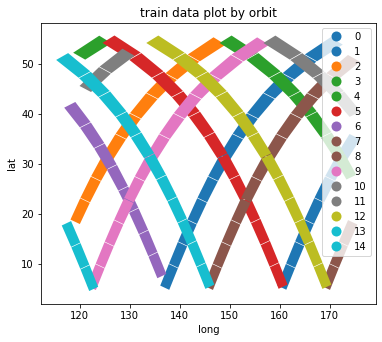

In [81]:
f, ax = plt.subplots(1, figsize=(6, 6))
ax = train_geoframe[ train_geoframe['orbit'].isin( list( range(15) ) )  ].plot(ax=ax, column='orbit', legend=True, categorical=True)
plt.title('train data plot by orbit') ; plt.ylabel('lat'); plt.xlabel('long')
plt.show()

####  train data orbit에 따라 다른 색상으로 시각화
>* train data은 각 oribt이 끊기지 않고 존재하는 것을 확인할 수 있다.
>* 한쪽 방향으로만 관측되는 것이 아닌 좌상단에서 우하단으로, 우상단에서 좌하단으로 2가지의 경로가 있는 것을 화인할 수 있다.

* test data를 geopandas Polygon으로 변경

In [47]:
orbit_dict = dict()

file_path_row = 0
while( True ):
    if len(test_files) <= file_path_row:
        print("all loading")
        break
    
    print('*' * 30)
    orbit = test_files[file_path_row].split('_')[1]

    start_row = file_path_row
    while(1):
        try:
            if test_files[file_path_row].split('_')[1] == orbit:
                file_path_row+=1
                continue
            else:
                break
        except:
            break
    
    orbit_dict[orbit] = []
    
    for data_row in range( start_row, file_path_row ):
        one_file = test_files[data_row]
        print( one_file )
        np_data = np.load(one_file)
        point1 = Point( np_data[0][0][10], np_data[0][0][11] )
        point2 = Point( np_data[0][39][10], np_data[0][39][11] )
        point3 = Point( np_data[39][39][10], np_data[39][39][11] )
        point4 = Point( np_data[39][0][10], np_data[39][0][11] )
        orbit_dict[orbit].append( Polygon( [point1, point2, point3, point4] ) )

******************************
./data/test\subset_029858_01.npy
./data/test\subset_029858_02.npy
./data/test\subset_029858_03.npy
./data/test\subset_029858_05.npy
./data/test\subset_029858_07.npy
./data/test\subset_029858_10.npy
./data/test\subset_029858_11.npy
******************************
./data/test\subset_029859_01.npy
./data/test\subset_029859_04.npy
./data/test\subset_029859_05.npy
./data/test\subset_029859_07.npy
******************************
./data/test\subset_029863_01.npy
./data/test\subset_029863_02.npy
./data/test\subset_029863_03.npy
./data/test\subset_029863_05.npy
./data/test\subset_029863_06.npy
./data/test\subset_029863_08.npy
******************************
./data/test\subset_029864_01.npy
./data/test\subset_029864_02.npy
./data/test\subset_029864_03.npy
./data/test\subset_029864_04.npy
./data/test\subset_029864_07.npy
./data/test\subset_029864_10.npy
./data/test\subset_029864_11.npy
./data/test\subset_029864_12.npy
******************************
./data/test\subset_0

./data/test\subset_029981_03.npy
./data/test\subset_029981_07.npy
./data/test\subset_029981_09.npy
./data/test\subset_029981_10.npy
******************************
./data/test\subset_029982_02.npy
./data/test\subset_029982_03.npy
./data/test\subset_029982_04.npy
./data/test\subset_029982_05.npy
******************************
./data/test\subset_029986_01.npy
./data/test\subset_029986_05.npy
******************************
./data/test\subset_029987_01.npy
./data/test\subset_029987_02.npy
./data/test\subset_029987_04.npy
./data/test\subset_029987_05.npy
./data/test\subset_029987_06.npy
./data/test\subset_029987_09.npy
./data/test\subset_029987_11.npy
******************************
./data/test\subset_029988_02.npy
./data/test\subset_029988_03.npy
******************************
./data/test\subset_029996_01.npy
./data/test\subset_029996_02.npy
./data/test\subset_029996_04.npy
./data/test\subset_029996_06.npy
******************************
./data/test\subset_029997_02.npy
./data/test\subset_029

./data/test\subset_030120_05.npy
./data/test\subset_030120_06.npy
./data/test\subset_030120_09.npy
******************************
./data/test\subset_030124_03.npy
./data/test\subset_030124_04.npy
./data/test\subset_030124_05.npy
******************************
./data/test\subset_030125_02.npy
./data/test\subset_030125_04.npy
./data/test\subset_030125_06.npy
./data/test\subset_030125_08.npy
******************************
./data/test\subset_030126_04.npy
./data/test\subset_030126_05.npy
./data/test\subset_030126_07.npy
./data/test\subset_030126_08.npy
******************************
./data/test\subset_030134_02.npy
./data/test\subset_030134_03.npy
./data/test\subset_030134_04.npy
./data/test\subset_030134_05.npy
./data/test\subset_030134_06.npy
./data/test\subset_030134_07.npy
./data/test\subset_030134_09.npy
******************************
./data/test\subset_030135_03.npy
./data/test\subset_030135_04.npy
./data/test\subset_030135_05.npy
./data/test\subset_030135_06.npy
./data/test\subset_0

./data/test\subset_030248_04.npy
./data/test\subset_030248_09.npy
./data/test\subset_030248_10.npy
./data/test\subset_030248_11.npy
******************************
./data/test\subset_030249_01.npy
./data/test\subset_030249_04.npy
./data/test\subset_030249_06.npy
******************************
./data/test\subset_030257_04.npy
./data/test\subset_030257_05.npy
./data/test\subset_030257_06.npy
./data/test\subset_030257_07.npy
./data/test\subset_030257_08.npy
./data/test\subset_030257_09.npy
******************************
./data/test\subset_030258_01.npy
./data/test\subset_030258_02.npy
./data/test\subset_030258_03.npy
./data/test\subset_030258_06.npy
./data/test\subset_030258_08.npy
./data/test\subset_030258_09.npy
./data/test\subset_030258_11.npy
******************************
./data/test\subset_030259_02.npy
******************************
./data/test\subset_030262_01.npy
******************************
./data/test\subset_030263_03.npy
./data/test\subset_030263_05.npy
./data/test\subset_030

******************************
./data/test\subset_030379_01.npy
******************************
./data/test\subset_030380_01.npy
./data/test\subset_030380_05.npy
./data/test\subset_030380_06.npy
./data/test\subset_030380_08.npy
./data/test\subset_030380_09.npy
******************************
./data/test\subset_030381_01.npy
./data/test\subset_030381_02.npy
./data/test\subset_030381_03.npy
./data/test\subset_030381_04.npy
./data/test\subset_030381_05.npy
./data/test\subset_030381_09.npy
******************************
./data/test\subset_030382_01.npy
./data/test\subset_030382_02.npy
./data/test\subset_030382_03.npy
******************************
./data/test\subset_030385_01.npy
./data/test\subset_030385_02.npy
./data/test\subset_030385_03.npy
******************************
./data/test\subset_030386_02.npy
./data/test\subset_030386_03.npy
./data/test\subset_030386_04.npy
./data/test\subset_030386_08.npy
./data/test\subset_030386_09.npy
./data/test\subset_030386_10.npy
./data/test\subset_030

./data/test\subset_030509_09.npy
./data/test\subset_030509_10.npy
******************************
./data/test\subset_030510_01.npy
./data/test\subset_030510_02.npy
./data/test\subset_030510_05.npy
./data/test\subset_030510_10.npy
******************************
./data/test\subset_030511_01.npy
******************************
./data/test\subset_030518_02.npy
./data/test\subset_030518_04.npy
./data/test\subset_030518_05.npy
./data/test\subset_030518_06.npy
******************************
./data/test\subset_030519_02.npy
./data/test\subset_030519_03.npy
./data/test\subset_030519_05.npy
./data/test\subset_030519_07.npy
./data/test\subset_030519_09.npy
******************************
./data/test\subset_030520_01.npy
./data/test\subset_030520_06.npy
******************************
./data/test\subset_030524_02.npy
./data/test\subset_030524_04.npy
./data/test\subset_030524_06.npy
./data/test\subset_030524_08.npy
******************************
./data/test\subset_030525_02.npy
./data/test\subset_03052

./data/test\subset_030648_11.npy
******************************
./data/test\subset_030649_01.npy
./data/test\subset_030649_04.npy
******************************
./data/test\subset_030656_01.npy
./data/test\subset_030656_04.npy
./data/test\subset_030656_06.npy
******************************
./data/test\subset_030657_01.npy
./data/test\subset_030657_04.npy
./data/test\subset_030657_08.npy
./data/test\subset_030657_11.npy
./data/test\subset_030657_12.npy
******************************
./data/test\subset_030658_01.npy
./data/test\subset_030658_02.npy
./data/test\subset_030658_03.npy
./data/test\subset_030658_04.npy
./data/test\subset_030658_06.npy
./data/test\subset_030658_07.npy
./data/test\subset_030658_08.npy
./data/test\subset_030658_09.npy
******************************
./data/test\subset_030659_01.npy
******************************
./data/test\subset_030662_01.npy
./data/test\subset_030662_02.npy
./data/test\subset_030662_03.npy
./data/test\subset_030662_06.npy
**********************

./data/test\subset_030770_10.npy
./data/test\subset_030770_11.npy
******************************
./data/test\subset_030771_02.npy
./data/test\subset_030771_06.npy
./data/test\subset_030771_11.npy
******************************
./data/test\subset_030772_02.npy
./data/test\subset_030772_03.npy
******************************
./data/test\subset_030779_01.npy
./data/test\subset_030779_03.npy
./data/test\subset_030779_04.npy
./data/test\subset_030779_05.npy
******************************
./data/test\subset_030780_03.npy
./data/test\subset_030780_05.npy
./data/test\subset_030780_06.npy
./data/test\subset_030780_07.npy
./data/test\subset_030780_10.npy
./data/test\subset_030780_12.npy
******************************
./data/test\subset_030781_03.npy
./data/test\subset_030781_04.npy
./data/test\subset_030781_06.npy
./data/test\subset_030781_07.npy
******************************
./data/test\subset_030785_02.npy
./data/test\subset_030785_04.npy
./data/test\subset_030785_05.npy
./data/test\subset_030

******************************
./data/test\subset_030892_01.npy
******************************
./data/test\subset_030893_04.npy
./data/test\subset_030893_07.npy
******************************
./data/test\subset_030894_01.npy
./data/test\subset_030894_02.npy
./data/test\subset_030894_04.npy
./data/test\subset_030894_06.npy
******************************
./data/test\subset_030895_01.npy
./data/test\subset_030895_02.npy
./data/test\subset_030895_03.npy
******************************
./data/test\subset_030902_01.npy
./data/test\subset_030902_02.npy
******************************
./data/test\subset_030903_02.npy
./data/test\subset_030903_04.npy
./data/test\subset_030903_05.npy
./data/test\subset_030903_07.npy
./data/test\subset_030903_08.npy
./data/test\subset_030903_09.npy
******************************
./data/test\subset_030904_01.npy
./data/test\subset_030904_02.npy
./data/test\subset_030904_03.npy
./data/test\subset_030904_07.npy
******************************
./data/test\subset_030908_

******************************
./data/test\subset_031033_03.npy
./data/test\subset_031033_04.npy
./data/test\subset_031033_06.npy
******************************
./data/test\subset_031040_01.npy
./data/test\subset_031040_02.npy
./data/test\subset_031040_03.npy
******************************
./data/test\subset_031041_02.npy
./data/test\subset_031041_05.npy
./data/test\subset_031041_07.npy
./data/test\subset_031041_10.npy
******************************
./data/test\subset_031042_01.npy
./data/test\subset_031042_02.npy
./data/test\subset_031042_10.npy
******************************
./data/test\subset_031043_01.npy
******************************
./data/test\subset_031046_01.npy
******************************
./data/test\subset_031047_02.npy
./data/test\subset_031047_03.npy
./data/test\subset_031047_05.npy
./data/test\subset_031047_06.npy
./data/test\subset_031047_07.npy
./data/test\subset_031047_09.npy
./data/test\subset_031047_10.npy
******************************
./data/test\subset_031048_

./data/test\subset_031154_03.npy
./data/test\subset_031154_04.npy
./data/test\subset_031154_05.npy
******************************
./data/test\subset_031155_02.npy
./data/test\subset_031155_03.npy
./data/test\subset_031155_04.npy
./data/test\subset_031155_05.npy
./data/test\subset_031155_07.npy
./data/test\subset_031155_08.npy
./data/test\subset_031155_09.npy
./data/test\subset_031155_10.npy
******************************
./data/test\subset_031156_02.npy
./data/test\subset_031156_04.npy
./data/test\subset_031156_05.npy
./data/test\subset_031156_07.npy
******************************
./data/test\subset_031163_02.npy
******************************
./data/test\subset_031164_02.npy
./data/test\subset_031164_06.npy
./data/test\subset_031164_10.npy
******************************
./data/test\subset_031165_03.npy
./data/test\subset_031165_05.npy
./data/test\subset_031165_08.npy
./data/test\subset_031165_09.npy
./data/test\subset_031165_11.npy
******************************
./data/test\subset_031

./data/test\subset_031272_08.npy
./data/test\subset_031272_09.npy
./data/test\subset_031272_12.npy
******************************
./data/test\subset_031273_03.npy
./data/test\subset_031273_05.npy
******************************
./data/test\subset_031277_01.npy
./data/test\subset_031277_02.npy
./data/test\subset_031277_03.npy
./data/test\subset_031277_07.npy
******************************
./data/test\subset_031278_05.npy
./data/test\subset_031278_06.npy
./data/test\subset_031278_08.npy
./data/test\subset_031278_09.npy
./data/test\subset_031278_10.npy
******************************
./data/test\subset_031279_03.npy
./data/test\subset_031279_04.npy
./data/test\subset_031279_05.npy
./data/test\subset_031279_06.npy
******************************
./data/test\subset_031286_01.npy
./data/test\subset_031286_04.npy
./data/test\subset_031286_05.npy
******************************
./data/test\subset_031287_01.npy
./data/test\subset_031287_02.npy
./data/test\subset_031287_07.npy
./data/test\subset_031

In [48]:
geodata_list = []
for i, orbit  in enumerate(orbit_dict.keys()):
    tmp = gpd.GeoDataFrame(orbit_dict[orbit], columns=['geometry'])
    tmp['orbit'] = i
    geodata_list.append( tmp )
test_geoframe = gpd.GeoDataFrame( pd.concat( geodata_list, ignore_index=True) )
test_geoframe['area'] = test_geoframe['geometry'].area

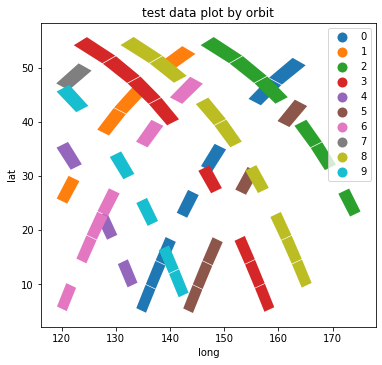

In [82]:
f, ax = plt.subplots(1, figsize=(6, 6))
ax = test_geoframe[ test_geoframe['orbit'].isin( list( range(10) ) )  ].plot(ax=ax, column='orbit', legend=True, categorical=True)
plt.title('test data plot by orbit') ; plt.ylabel('lat'); plt.xlabel('long')
plt.show()

####  test data orbit에 따라 다른 색상으로 시각화
>* test data은 각 oibit의 중간 데이터가 손실되어 있는 것을 확인 할 수 있다.
>* 한쪽 방향으로만 관측되는 것이 아닌 좌상단에서 후하단으로, 우상단에서 좌하단으로 2가지의 경로가 있는것을 화인할 수 있다.

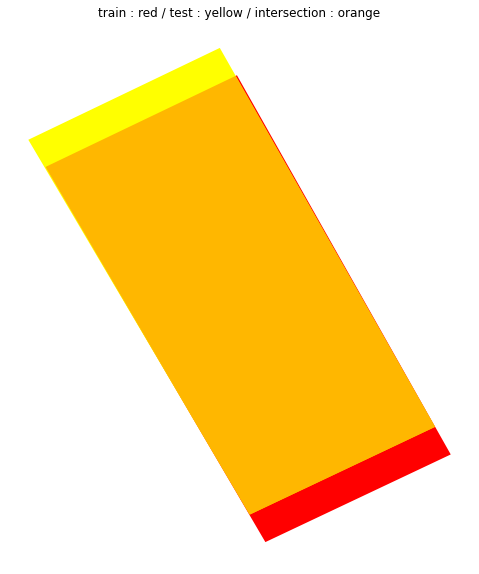

train data에는 700 번째의 test data와 0.9234093677913886 % 만큼 겹치는 data가 존재함.


In [101]:
index = 700
area = test_geoframe.loc[index, 'area']
target_geometry = test_geoframe.loc[index, 'geometry']

intersection_area = []
for data in train_geoframe['geometry'].values:
    intersection_area.append( data.intersection( target_geometry ).area / area )

fig, ax = plt.subplots(figsize=(10, 10))
gpd.GeoSeries(train_geoframe.loc[intersection_area.index(max(intersection_area)),'geometry']).plot(ax=ax, color="red", alpha = 1)
gpd.GeoSeries(target_geometry).plot(ax=ax, color="yellow", alpha = 1)
gpd.GeoSeries(target_geometry.intersection( train_geoframe.loc[intersection_area.index(max(intersection_area)),'geometry'] )  ).plot(ax=ax, color="orange", alpha = 0.8)
plt.title( 'train : red / test : yellow / intersection : orange' )
ax.set_axis_off()
plt.show()

print( 'train data에는',index ,'번째의 test data와', max(intersection_area), '% 만큼 겹치는 data가 존재함.' )

#### 해당 index에서 가장 겹치는 부분이 많은 부분을 시각화
>* red : train data
>* yellow : test data
>* orange : intersection area

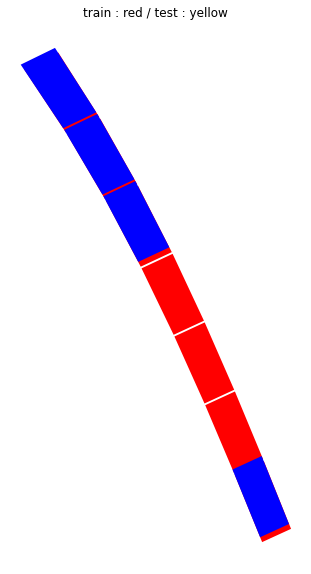

In [102]:
train_orbit = train_geoframe.loc[intersection_area.index(max(intersection_area)),'orbit']
test_orbit = test_geoframe.loc[index,'orbit']

fig, ax = plt.subplots(figsize=(10, 10))
for index_ in train_geoframe[ train_geoframe['orbit'] == train_orbit ].index:
    gpd.GeoSeries(train_geoframe.loc[index_, 'geometry']).plot(ax=ax, color="red")
for index_ in test_geoframe[ test_geoframe['orbit'] == test_orbit ].index:
    gpd.GeoSeries(test_geoframe.loc[index_, 'geometry']).plot(ax=ax, color="blue")
    
plt.title( 'train : red / test : yellow' )
ax.set_axis_off()
plt.show()

#### 다른 날에 비슷한 궤도를 측정
>* red : train data
>* blue : test data
>* 위에서 확인한 것 과같이 train data는 연속적으로 존재하고 test data는 그의 중간의 손실된 데이터로 존재

* test와 겹치는정도가 80%, 95%이상인 train 데이터만을 사용하기 위해 index번호 저장
* random index의 test data 와 가장 많이 겹치는 train data 시각화

In [69]:
test_geoframe['overlap_per'] = 0
over_95_index = []
over_80_index = []

In [76]:
for test_index in tqdm(range( len(test_geoframe) )):
    area = test_geoframe.loc[test_index, 'area']
    target_geometry = test_geoframe.loc[test_index, 'geometry']
    
    # test data 각각이 모든 train data에 대해서 겹치는 정도를 계산 ( 겹치는 부분의 면적 / test data의 면적)
    intersection_area = train_geoframe['geometry'].values.intersection( target_geometry ).area / area
    
    for data in list( intersection_area[intersection_area>0.95] ):
        over_95_index.append( np.where( intersection_area == data )[0][0] )
    
    for data in list( intersection_area[intersection_area>0.80] ):
        over_80_index.append( np.where( intersection_area == data )[0][0] )
    
    # 가장 높은 겹침 정도를 저장
    test_geoframe.loc[test_index, 'overlap_per'] = max( intersection_area )

100%|██████████| 2416/2416 [53:28<00:00,  1.33s/it]


In [85]:
# 중복되는 train index 제거
over_95_index = sorted( list(set(over_95_index)) )
over_80_index = sorted( list(set(over_80_index)) )

In [86]:
print( 'tarin data 갯수', len(train_geoframe) )
print( '95% 이상 갯수', len(over_95_index))
print( '80% 이상 갯수', len(over_80_index))

tarin data 갯수 61351
95% 이상 갯수 10189
80% 이상 갯수 40883


In [ ]:
# 메모리 공간을 차지하고 있기떄문에 제거함
del train_geoframe
del test_geoframe

#### 95%이상의 데이터는 데이터셋이 너무 적으므로 80%이상 겹치는 index들만 사용
* 공간적 위치가 같은 데이터 쌍은 해당 지역의 특색(type)을 더 잘 반영해 줄 것으로 기대한다

## 3.3 강수량  시각화를 위한 데이터 추출
* test와 겹치는정도가 80%이상인 train 데이터만을 load하여 시각화에 사용

In [111]:
over_80_fillter = [False for i in range( len( train_files ) )]
for index in over_80_index:
    over_80_fillter[ index ] = True
    
train_files = train_files[ over_80_fillter ]
train = train[ over_80_fillter ]
fourth_data_amount = len( train_files )
print( 'test data와 겹치는 train data만 추출후 data 갯수 변화', third_data_amount, '->', fourth_data_amount )

test data와 겹치는 train data만 추출후 data 갯수 변화 61351 -> 40883


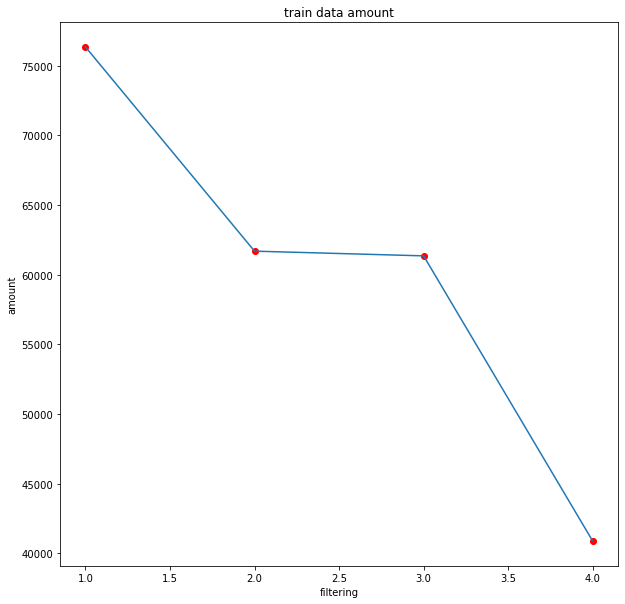

In [133]:
amount_y = [beginning_data_amount, second_data_amount, third_data_amount, fourth_data_amount]
amount_x = [1, 2, 3, 4]
plt.figure(figsize = (10,10))
plt.scatter( amount_x, amount_y, color='red' )
plt.plot( amount_x, amount_y )
plt.title( 'train data amount' ) ; plt.ylabel('amount'); plt.xlabel('filtering')
plt.show()

# 4. 모델링

In [2]:
import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, concatenate
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")

In [136]:
x_train = train[:,:,:,:10]
y_train = train[:,:,:,14]
y_train = y_train.reshape(y_train.shape[0], 40, 40, 1)
test = test[:,:,:,:10]

del train

In [137]:
print( 'x train shape :', x_train.shape)
print( 'y train shape :', y_train.shape)
print( 'test shape :', test.shape)

x train shape : (40883, 40, 40, 10)
y train shape : (40883, 40, 40, 1)
test shape : (2416, 40, 40, 10)


In [138]:
y_train_ = y_train.reshape(-1,y_train.shape[1]*y_train.shape[2])

### 데이터를 더 줄이기 위해, 40x40픽셀에서 전체강수량이 50이상인 데이터만 사용하기로함
* 밑에서 각 데이터를 회전/반전 시키게 되면 데이터쌍이 8배로 증가하기 때문에 더 줄여줄 필요가 있음

In [140]:
x_train = x_train[np.where(y_train_.sum(axis = 1)>=50)]
y_train = y_train[np.where(y_train_.sum(axis = 1)>=50)]
x_train.shape , y_train.shape

((18253, 40, 40, 10), (18253, 40, 40, 1))

### 가채점용 테스트 데이터 분리

In [141]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.025, random_state=7777)
print( 'x train shape :', x_train.shape)
print( 'y train shape :', y_train.shape)
print( 'test shape :', test.shape)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

x train shape : (17796, 40, 40, 10)
y train shape : (17796, 40, 40, 1)
test shape : (2416, 40, 40, 10)


((17796, 40, 40, 10), (17796, 40, 40, 1), (457, 40, 40, 10), (457, 40, 40, 1))

## 데이터를  회전, 반전을 시켜 8배 부풀림

In [142]:
def data_generator(x_train, y_train):
    rotate_X_90 = np.zeros_like(x_train)
    rotate_Y_90 = np.zeros_like(y_train)

    for j in range(rotate_X_90.shape[0]):
        rotate_x=np.zeros([x_train.shape[1],x_train.shape[2],10])
        rotate_y=np.zeros([x_train.shape[1],x_train.shape[2],1])
        for i in range(10):
            rotate_x[:,:,i]=np.rot90(x_train[j,:,:,i])
        rotate_y[:,:,0]=np.rot90(y_train[j,:,:,0])

        rotate_X_90[j,:,:,:] = rotate_x
        rotate_Y_90[j,:,:,:] = rotate_y

    rotate_X_180 = np.zeros_like(x_train)
    rotate_Y_180 = np.zeros_like(y_train)

    for j in range(rotate_X_180.shape[0]):
        rotate_x=np.zeros([x_train.shape[1],x_train.shape[2],10])
        rotate_y=np.zeros([x_train.shape[1],x_train.shape[2],1])
        for i in range(10):
            rotate_x[:,:,i]=np.rot90(x_train[j,:,:,i])
            rotate_x[:,:,i]=np.rot90(rotate_x[:,:,i])
        rotate_y[:,:,0]=np.rot90(y_train[j,:,:,0])
        rotate_y[:,:,0]=np.rot90(rotate_y[:,:,0])

        rotate_X_180[j,:,:,:] = rotate_x
        rotate_Y_180[j,:,:,:] = rotate_y

    rotate_X_270 = np.zeros_like(x_train)
    rotate_Y_270 = np.zeros_like(y_train)

    for j in range(rotate_X_270.shape[0]):
        rotate_x=np.zeros([x_train.shape[1],x_train.shape[2],10])
        rotate_y=np.zeros([x_train.shape[1],x_train.shape[2],1])
        for i in range(10):
            rotate_x[:,:,i]=np.rot90(x_train[j,:,:,i])
            rotate_x[:,:,i]=np.rot90(rotate_x[:,:,i])
            rotate_x[:,:,i]=np.rot90(rotate_x[:,:,i])
        rotate_y[:,:,0]=np.rot90(y_train[j,:,:,0])
        rotate_y[:,:,0]=np.rot90(rotate_y[:,:,0])
        rotate_y[:,:,0]=np.rot90(rotate_y[:,:,0])

        rotate_X_270[j,:,:,:] = rotate_x
        rotate_Y_270[j,:,:,:] = rotate_y

    x_train = np.concatenate((x_train, rotate_X_90, rotate_X_180, rotate_X_270), axis = 0)
    y_train = np.concatenate((y_train, rotate_Y_90, rotate_Y_180, rotate_Y_270), axis = 0)
    del rotate_X_90, rotate_X_180, rotate_X_270

    x_T = np.zeros_like(x_train)
    y_T = np.zeros_like(y_train)

    for i in range(x_train.shape[0]):
        for j in range(x_train.shape[3]):
            x_T[i,:,:,j] = x_train[i,:,:,j].T
        y_T[i,:,:,0] = y_train[i,:,:,0].T

    x_train = np.concatenate((x_train, x_T), axis = 0)
    y_train = np.concatenate((y_train, y_T), axis = 0)

    del x_T,y_T
    
    return x_train, y_train

## 평가 함수 정의


In [143]:
def mae_over_fscore(y_true, y_pred):
    '''
    y_true: sample_submission.csv 형태의 실제 값
    y_pred: sample_submission.csv 형태의 예측 값
    '''

    y_true = np.array(y_true)
    y_true = y_true.reshape(1, -1)[0]  
    
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(1, -1)[0]
    
    # 실제값이 0.1 이상인 픽셀의 위치 확인
    IsGreaterThanEqualTo_PointOne = y_true >= 0.1
    
    # 실제 값에 결측값이 없는 픽셀의 위치 확인 
    IsNotMissing = y_true >= 0
    
    # mae 계산
    mae = np.mean(np.abs(y_true[IsGreaterThanEqualTo_PointOne] - y_pred[IsGreaterThanEqualTo_PointOne]))
    
    # f1_score 계산 위해, 실제값에 결측값이 없는 픽셀에 대해 1과 0으로 값 변환
    y_true = np.where(y_true[IsNotMissing] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[IsNotMissing] >= 0.1, 1, 0)
    
    # f1_score 계산    
    f_score = f1_score(y_true, y_pred) 
    # f1_score가 0일 나올 경우를 대비하여 소량의 값 (1e-07) 추가 
    return mae / (f_score + 1e-07) 

## 손실 함수 정의


In [144]:
def mae(y_true, y_pred):    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def score(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

## 모델


In [145]:
def create_model():
    inputs=Input(x_train.shape[1:])
    
    bn=BatchNormalization()(inputs)
    conv0=Conv2D(128, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    bn=BatchNormalization()(conv0)
    conv=Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([conv0, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    conv=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([concat, conv], axis=3)
        
    for i in range(5):
        bn=BatchNormalization()(concat)
        conv=Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    outputs=Conv2D(1, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

In [146]:
# GPU setting
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### validation data 생성

In [147]:
x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=321)

### train data 쌍 부풀리기 

In [148]:
x_train_, y_train_ = data_generator(x_train_, y_train_)

In [153]:
model = create_model()

model.compile(loss='mae', optimizer='adam', metrics=[score, fscore_keras])

callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=3,
        factor=0.8
    ),

    tf.keras.callbacks.ModelCheckpoint(
        filepath = './model_check_point/model.h5',
        monitor='val_score',
        save_best_only=True
    )
]

In [154]:
model.fit(x_train_, y_train_, epochs=50, batch_size=64, validation_data=(x_val, y_val), callbacks=callbacks_list)

Train on 95384 samples, validate on 5873 samples
Epoch 1/50
95384/95384 [==============================] - 256s 3ms/sample - loss: 0.2227 - score: 1.8766 - fscore_keras: 0.7389 - val_loss: 0.2176 - val_score: 1.6769 - val_fscore_keras: 0.7794
Epoch 2/50
95384/95384 [==============================] - 254s 3ms/sample - loss: 0.2080 - score: 1.6760 - fscore_keras: 0.7688 - val_loss: 0.2171 - val_score: 1.6994 - val_fscore_keras: 0.7764
Epoch 3/50
95384/95384 [==============================] - 258s 3ms/sample - loss: 0.2042 - score: 1.6290 - fscore_keras: 0.7769 - val_loss: 0.2255 - val_score: 1.7336 - val_fscore_keras: 0.7494
Epoch 4/50
95384/95384 [==============================] - 257s 3ms/sample - loss: 0.2023 - score: 1.6034 - fscore_keras: 0.7818 - val_loss: 0.2077 - val_score: 1.5869 - val_fscore_keras: 0.7915
Epoch 5/50
95384/95384 [==============================] - 257s 3ms/sample - loss: 0.2010 - score: 1.5850 - fscore_keras: 0.7846 - val_loss: 0.2063 - val_score: 1.6353 - val_fs

KeyboardInterrupt: 

## 시각화
 * loss 시각화

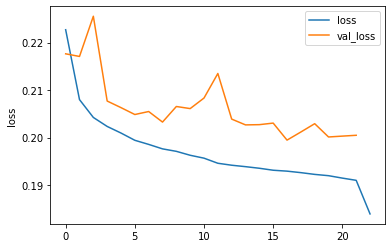

In [159]:
plt.plot(model.history.history['loss'] , label = 'loss')
plt.plot(model.history.history['val_loss'] , label = 'val_loss')
plt.legend()
plt.ylabel('loss')
plt.show()

In [163]:
# 최상의 모델 load
model = load_model('./model_check_point/model.h5', custom_objects = {'score':score,'fscore_keras':fscore_keras})

### 가채점

In [164]:
mae_over_fscore(y_test, model.predict(x_test))

1.4866551847621214

## Submission 생성

In [165]:
submission = pd.read_csv('data/sample_submission.csv')
submission.iloc[:,1:] = model.predict(test).reshape(-1,1600)
submission

id      px_1      px_2      px_3      px_4      px_5      px_6  \
0     029858_01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1     029858_02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2     029858_03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3     029858_05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4     029858_07  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
2411  031287_08  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2412  031288_01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2413  031288_02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2414  031288_08  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2415  031288_11  0.503985  0.545893  0.589709  0.324956  0.362819  0.496677   

      px_7  px_8  px_9  ...   px_1591   px_1592   px_1593  px_1594   px_1595  \
0      0.0   0.0   0.0  ...  0.000000  0.000000  0.000000  0.00000  0.000000   
1      0.0   0.0   0.0  ...  0.000000  0.000000  0.000000  0.00000  0.000000   
2      0.0   0.0   0.0  ...  0.000000  0.000000  0.000000  0.00000  0.000000   
3      0.0   0.0   0.0  ...  0.000000  0.000000  0.000000  0.00000  0.000000   
4      0.0   0.0   0.0  ...  1.318975  1.871766  1.421221  0.80376  0.765745   
...    ...   ...   ...  ...       ...       ...       ...      ...       ...   
2411   0.0   0.0   0.0  ...  0.000000  0.000000  0.000000  0.00000  0.000000   
2412   0.0   0.0   0.0  ...  0.000000  0.000000  0.000000  0.00000  0.000000   
2413   0.0   0.0   0.0  ...  0.000000  0.000000  0.000000  0.00000  0.000000   
2414   0.0   0.0   0.0  ...  0.000000  0.000000  0.000000  0.00000  0.000000   
2415   0.0   0.0   0.0  ...  0.000000  0.000000  0.000000  0.00000  0.000000   

       px_1596   px_1597   px_1598   px_1599   px_1600  
0     0.000000  0.000000  0.000000  0.000000  0.000000  
1     0.000000  0.000000  0.000000  0.000000  0.000000  
2     0.000000  0.000000  0.000000  0.000000  0.000000  
3     0.000000  0.000000  0.000000  0.000000  0.000000  
4     1.859535  3.665199  3.343112  2.013926  1.054064  
...        ...       ...       ...       ...       ...  
2411  0.000000  0.000000  0.000000  0.000000  0.000000  
2412  0.000000  0.000000  0.000000  0.000000  0.000000  
2413  0.000000  0.000000  0.000000  0.000000  0.000000  
2414  0.000000  0.000000  0.000000  0.000000  0.000000  
2415  0.000000  0.000000  0.000000  0.000000  0.000000  

[2416 rows x 1601 columns]

In [166]:
submission.to_csv('submission/submission.csv', index=False)